# Matthew Garton - DSI Boston
# Regression Project - EDA

### Purpose: Exploratory Data Analysis using visualizations and other strategies to support feature engineering and model design.

In [2]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# load training data
ames = pd.read_csv("../data/train.csv")

In [4]:
def clean_ames_data(df):
    '''Generalized function to clean a sample of Ames Housing Data'''
    
    # convert column names to useable format
    df.columns = [x.lower().replace(' ','_') for x in df.columns]
    
    # drop 'id' and 'pid' columns
    #df.drop(['id','pid'], axis=1, inplace=True)

    # Dealing with NaN values. Handling the special case of Masonry Veneer Type first
    
    df['mas_vnr_type'].fillna(value = 'None', inplace = True) # Assuming 'NaN' should be 'None' for Masonry Type
    df['mas_vnr_area'].fillna(value = 0.0, inplace = True) # Assuming masonry area is 0.0 for houses with 'NaN' type
    
    # for categorical variables, the missing values should actually be marked 'NA'
    nulls = df.columns[df.isnull().any()]
    for col in df[nulls].select_dtypes(include = 'object').columns:
        df[col].fillna(value = 'NA', inplace = True)
    
    # filtering for houses with no basement, replacing numerical columns 'NaNs' with 0.0
    no_bsmt = df['bsmt_qual'] == 'NA'    
    for col in df[no_bsmt].filter(regex = 'bsmt'):
        df[col].fillna(value = 0.0, inplace = True)
        
    # use the same procedure to handle numerical columns for houses with no garage
    no_garage = df['garage_type'] == 'NA' 
    for col in df[no_garage].filter(regex = 'garage'):
        df[col].fillna(value = 0.0, inplace = True)

In [5]:
# clean the data
clean_ames_data(ames)

In [6]:
# Split data into X an y
X = ames.loc[:,ames.columns != 'saleprice']
y = ames['saleprice']

In [7]:
# Train-test split before EDA
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 

In [8]:
# merge X_train and y_train for EDA
ames_train = pd.concat((X_train, y_train), axis = 1)
ames_train.head()

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
532   1612  526352080           20        RL          85.0     10667   Pave   
415   2045  904100100           70        RL         107.0     12888   Pave   
273   1962  535451110           20        RL          60.0      7200   Pave   
1460   229  905109130           60        RL          80.0     14000   Pave   
250   1105  528363020           60        RL           NaN     11929   Pave   

     alley lot_shape land_contour    ...     screen_porch pool_area pool_qc  \
532     NA       Reg          Lvl    ...                0         0      NA   
415     NA       Reg          Bnk    ...                0         0      NA   
273     NA       Reg          Lvl    ...                0         0      NA   
1460    NA       Reg          Lvl    ...                0         0      NA   
250     NA       IR1          Lvl    ...                0         0      NA   

     fence misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  
532     NA           NA        0       3    2007        WD      167300  
415     NA           NA        0       4    2007        WD      219000  
273     NA           NA        0       7    2007        WD      129000  
1460    NA           NA        0       4    2010        WD      328000  
250     NA           NA        0       6    2008        WD      290000  

[5 rows x 81 columns]

The cells below demonstrate the investigation I did to see how house prices vary by neighborhood, which lead me to create a more general categorical variable for 'Location' below. Rather than treating each neighborhood separately, I created four groups, based on which quartile of the salesprice distribution the neighborhood's median house price fell into.

In [23]:
ames_train.groupby('neighborhood')['saleprice'].mean().sort_values(ascending = True)

neighborhood
MeadowV     99591.666667
IDOTRR      99903.381818
BrDale     102582.142857
Edwards    125089.096154
BrkSide    128256.854839
OldTown    128473.610619
SWISU      136230.190476
Landmrk    137000.000000
Sawyer     137218.873563
NPkVill    140240.000000
NAmes      145057.286364
Blueste    148680.000000
Mitchel    163848.333333
Greens     180000.000000
SawyerW    186750.594203
Gilbert    189607.696629
NWAmes     193682.066667
Blmngtn    197375.684211
CollgCr    200085.642336
Crawfor    204617.760000
ClearCr    205236.600000
Somerst    224125.103774
Timber     246130.333333
Veenker    263720.000000
GrnHill    280000.000000
NoRidge    321712.315789
NridgHt    327450.607143
StoneBr    337674.793103
Name: saleprice, dtype: float64

In [24]:
ames_train.groupby('neighborhood')['saleprice'].median().sort_values(ascending = True)

neighborhood
MeadowV     94400.0
IDOTRR     100000.0
BrDale     102750.0
OldTown    122000.0
Edwards    122500.0
BrkSide    128125.0
Landmrk    137000.0
Sawyer     137000.0
SWISU      137000.0
NAmes      140000.0
NPkVill    143000.0
Blueste    151000.0
Mitchel    153500.0
Gilbert    179000.0
Greens     180000.0
SawyerW    181000.0
NWAmes     185750.0
Blmngtn    192000.0
CollgCr    196000.0
ClearCr    196250.0
Crawfor    198750.0
Somerst    218650.0
Timber     241500.0
Veenker    277350.0
GrnHill    280000.0
NoRidge    305750.0
NridgHt    312451.5
StoneBr    325000.0
Name: saleprice, dtype: float64

In [25]:
ames_train['saleprice'].describe()

count      1538.000000
mean     181061.993498
std       79552.718835
min       13100.000000
25%      129925.000000
50%      162250.000000
75%      213000.000000
max      611657.000000
Name: saleprice, dtype: float64

In [26]:
ames_train['neighborhood'].nunique()

28

In [9]:
# Create a categorical variable for 'Location'
location_q1 = ['MeadowV','IDOTRR','BrDale','OldTown','Edwards','BrkSide']
location_q2 = ['Landmrk','Sawyer','SWISU','NAmes','NPkVill','Blueste','Mitchel']
location_q3 = ['Gilbert','Greens','SawyerW','NWAmes','Blmngtn','CollgCr','ClearCr','Crawfor']
location_q4 = ['Somerst','Timber','Veenker','GrnHill','NoRidge','NridgHt','StoneBr']

ames_train['Location'] = ames_train['neighborhood']
ames_train['Location'].replace({'MeadowV':'Low','IDOTRR': 'Low','BrDale': 'Low','OldTown': 'Low',
                                'Edwards':'Low','BrkSide':'Low', 'Landmrk': 'LowMed','Sawyer': 'LowMed',
                                'SWISU':'LowMed','NAmes':'LowMed','NPkVill':'LowMed','Blueste':'LowMed',
                                'Mitchel':'LowMed','Gilbert':'MedHigh','Greens':'MedHigh','SawyerW':'MedHigh',
                                'NWAmes':'MedHigh','Blmngtn':'MedHigh','CollgCr':'MedHigh','ClearCr':'MedHigh',
                                'Crawfor':'MedHigh','Somerst':'High','Timber':'High','Veenker':'High','GrnHill':'High',
                                'NoRidge':'High','NridgHt':'High','StoneBr':'High'}, inplace = True)

In [10]:
ames_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1538 entries, 532 to 860
Data columns (total 82 columns):
id                 1538 non-null int64
pid                1538 non-null int64
ms_subclass        1538 non-null int64
ms_zoning          1538 non-null object
lot_frontage       1285 non-null float64
lot_area           1538 non-null int64
street             1538 non-null object
alley              1538 non-null object
lot_shape          1538 non-null object
land_contour       1538 non-null object
utilities          1538 non-null object
lot_config         1538 non-null object
land_slope         1538 non-null object
neighborhood       1538 non-null object
condition_1        1538 non-null object
condition_2        1538 non-null object
bldg_type          1538 non-null object
house_style        1538 non-null object
overall_qual       1538 non-null int64
overall_cond       1538 non-null int64
year_built         1538 non-null int64
year_remod/add     1538 non-null int64
roof_style         

# FIRST: How is my target variable distributed?

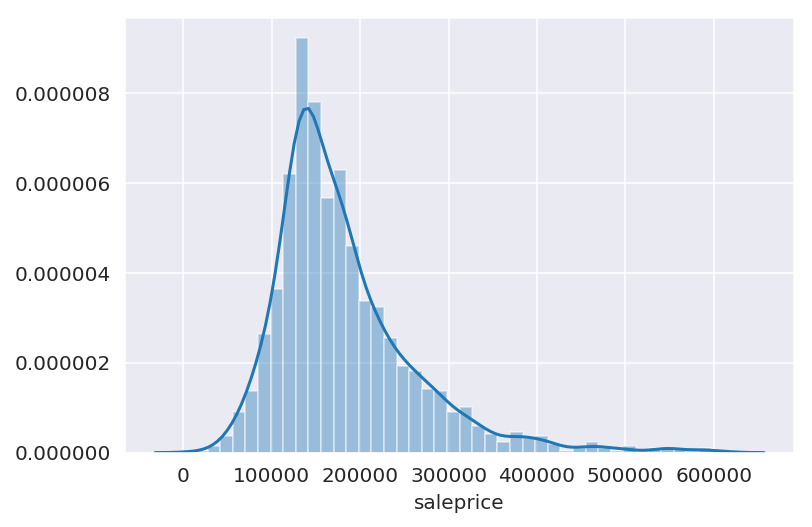

In [11]:
sns.distplot(ames_train['saleprice']);

For numeric columns, I will start with some basic scatterplots and heatmaps to try to look at correlation.

# Pairplots

### Looking for basic pairwise correlations. Adding a hue for location to see how location affects the distribution.

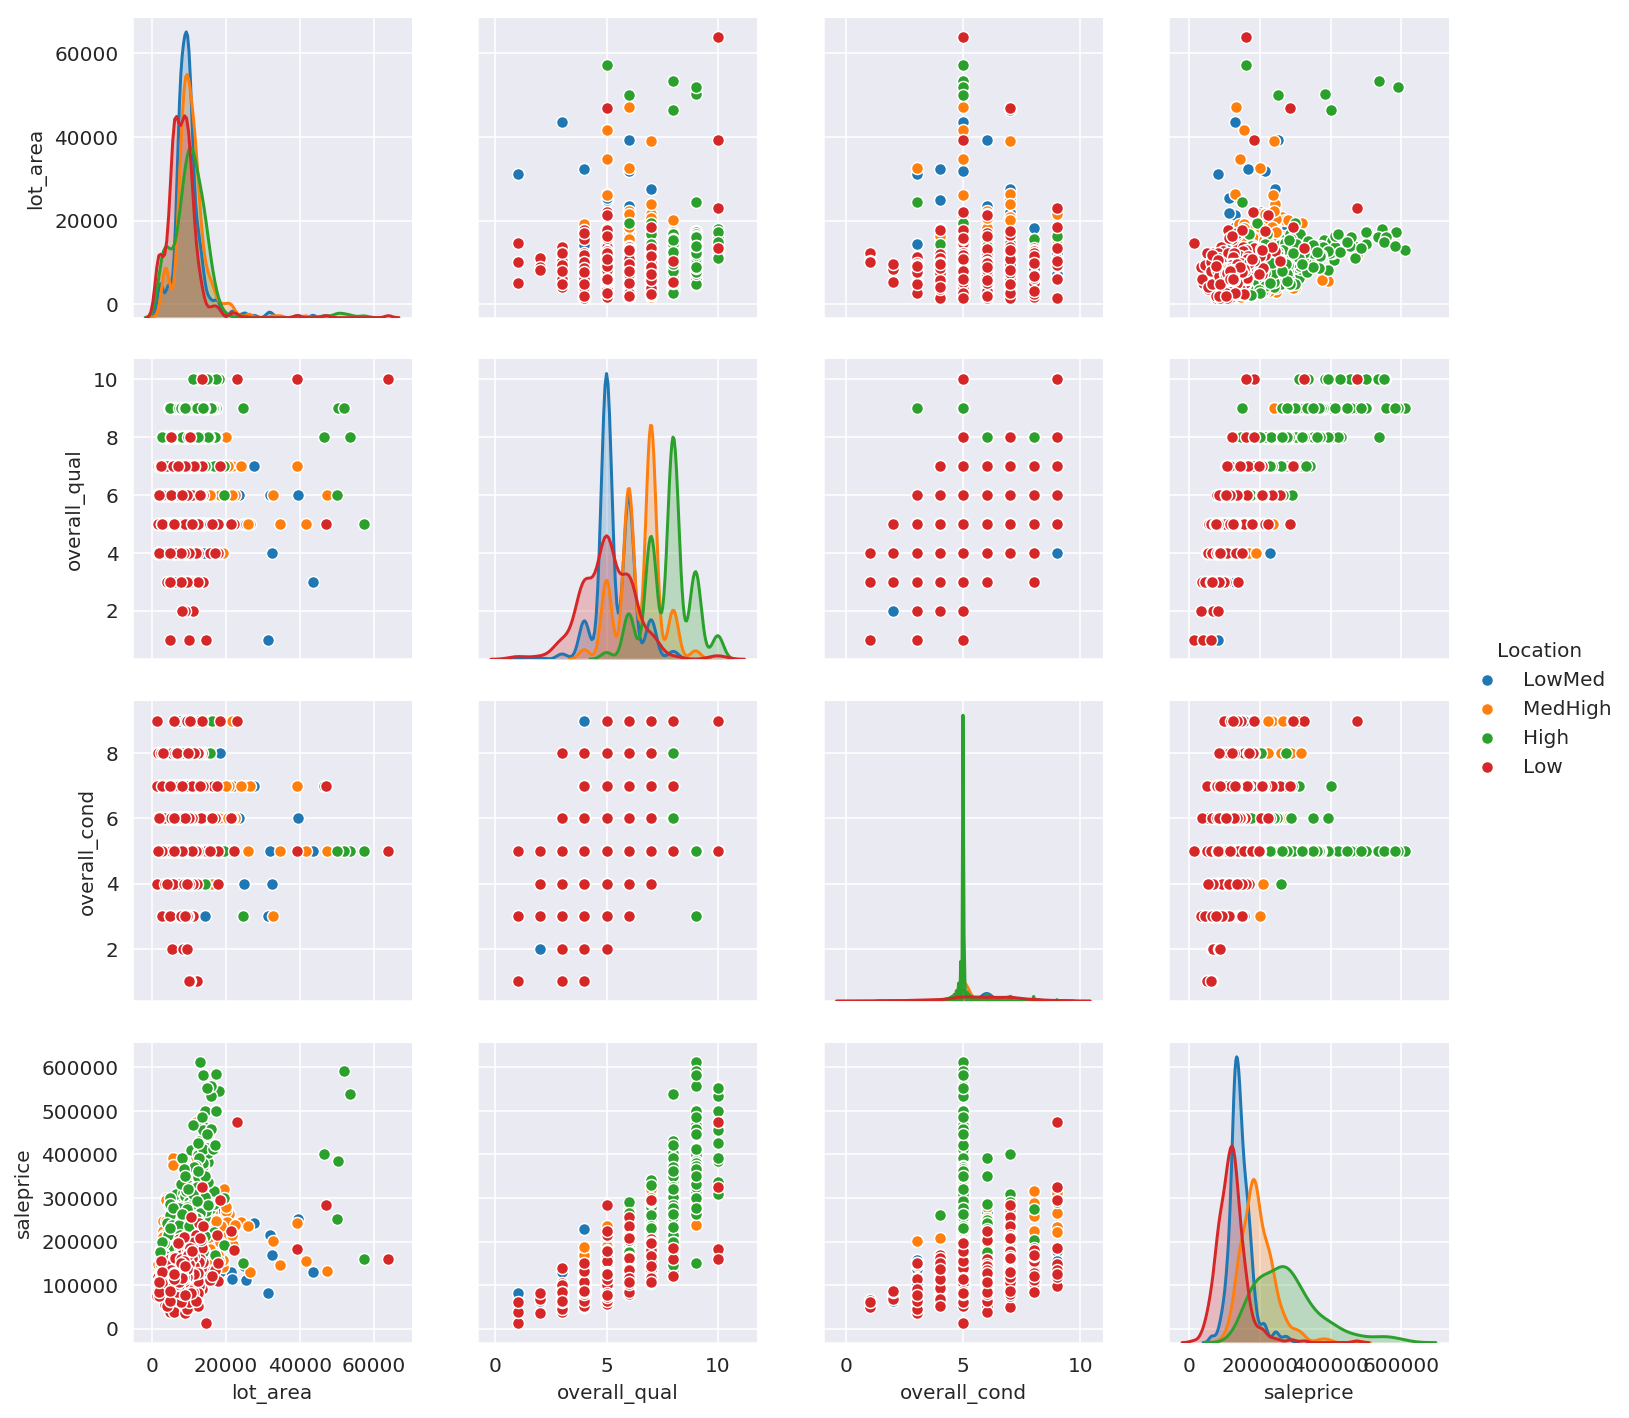

In [11]:
sns.pairplot(data = ames_train, 
             vars = ['lot_area','overall_qual','overall_cond','saleprice'], 
             hue = 'Location');

Of these variables, overall quality seems to be a strong predictor for saleprice.

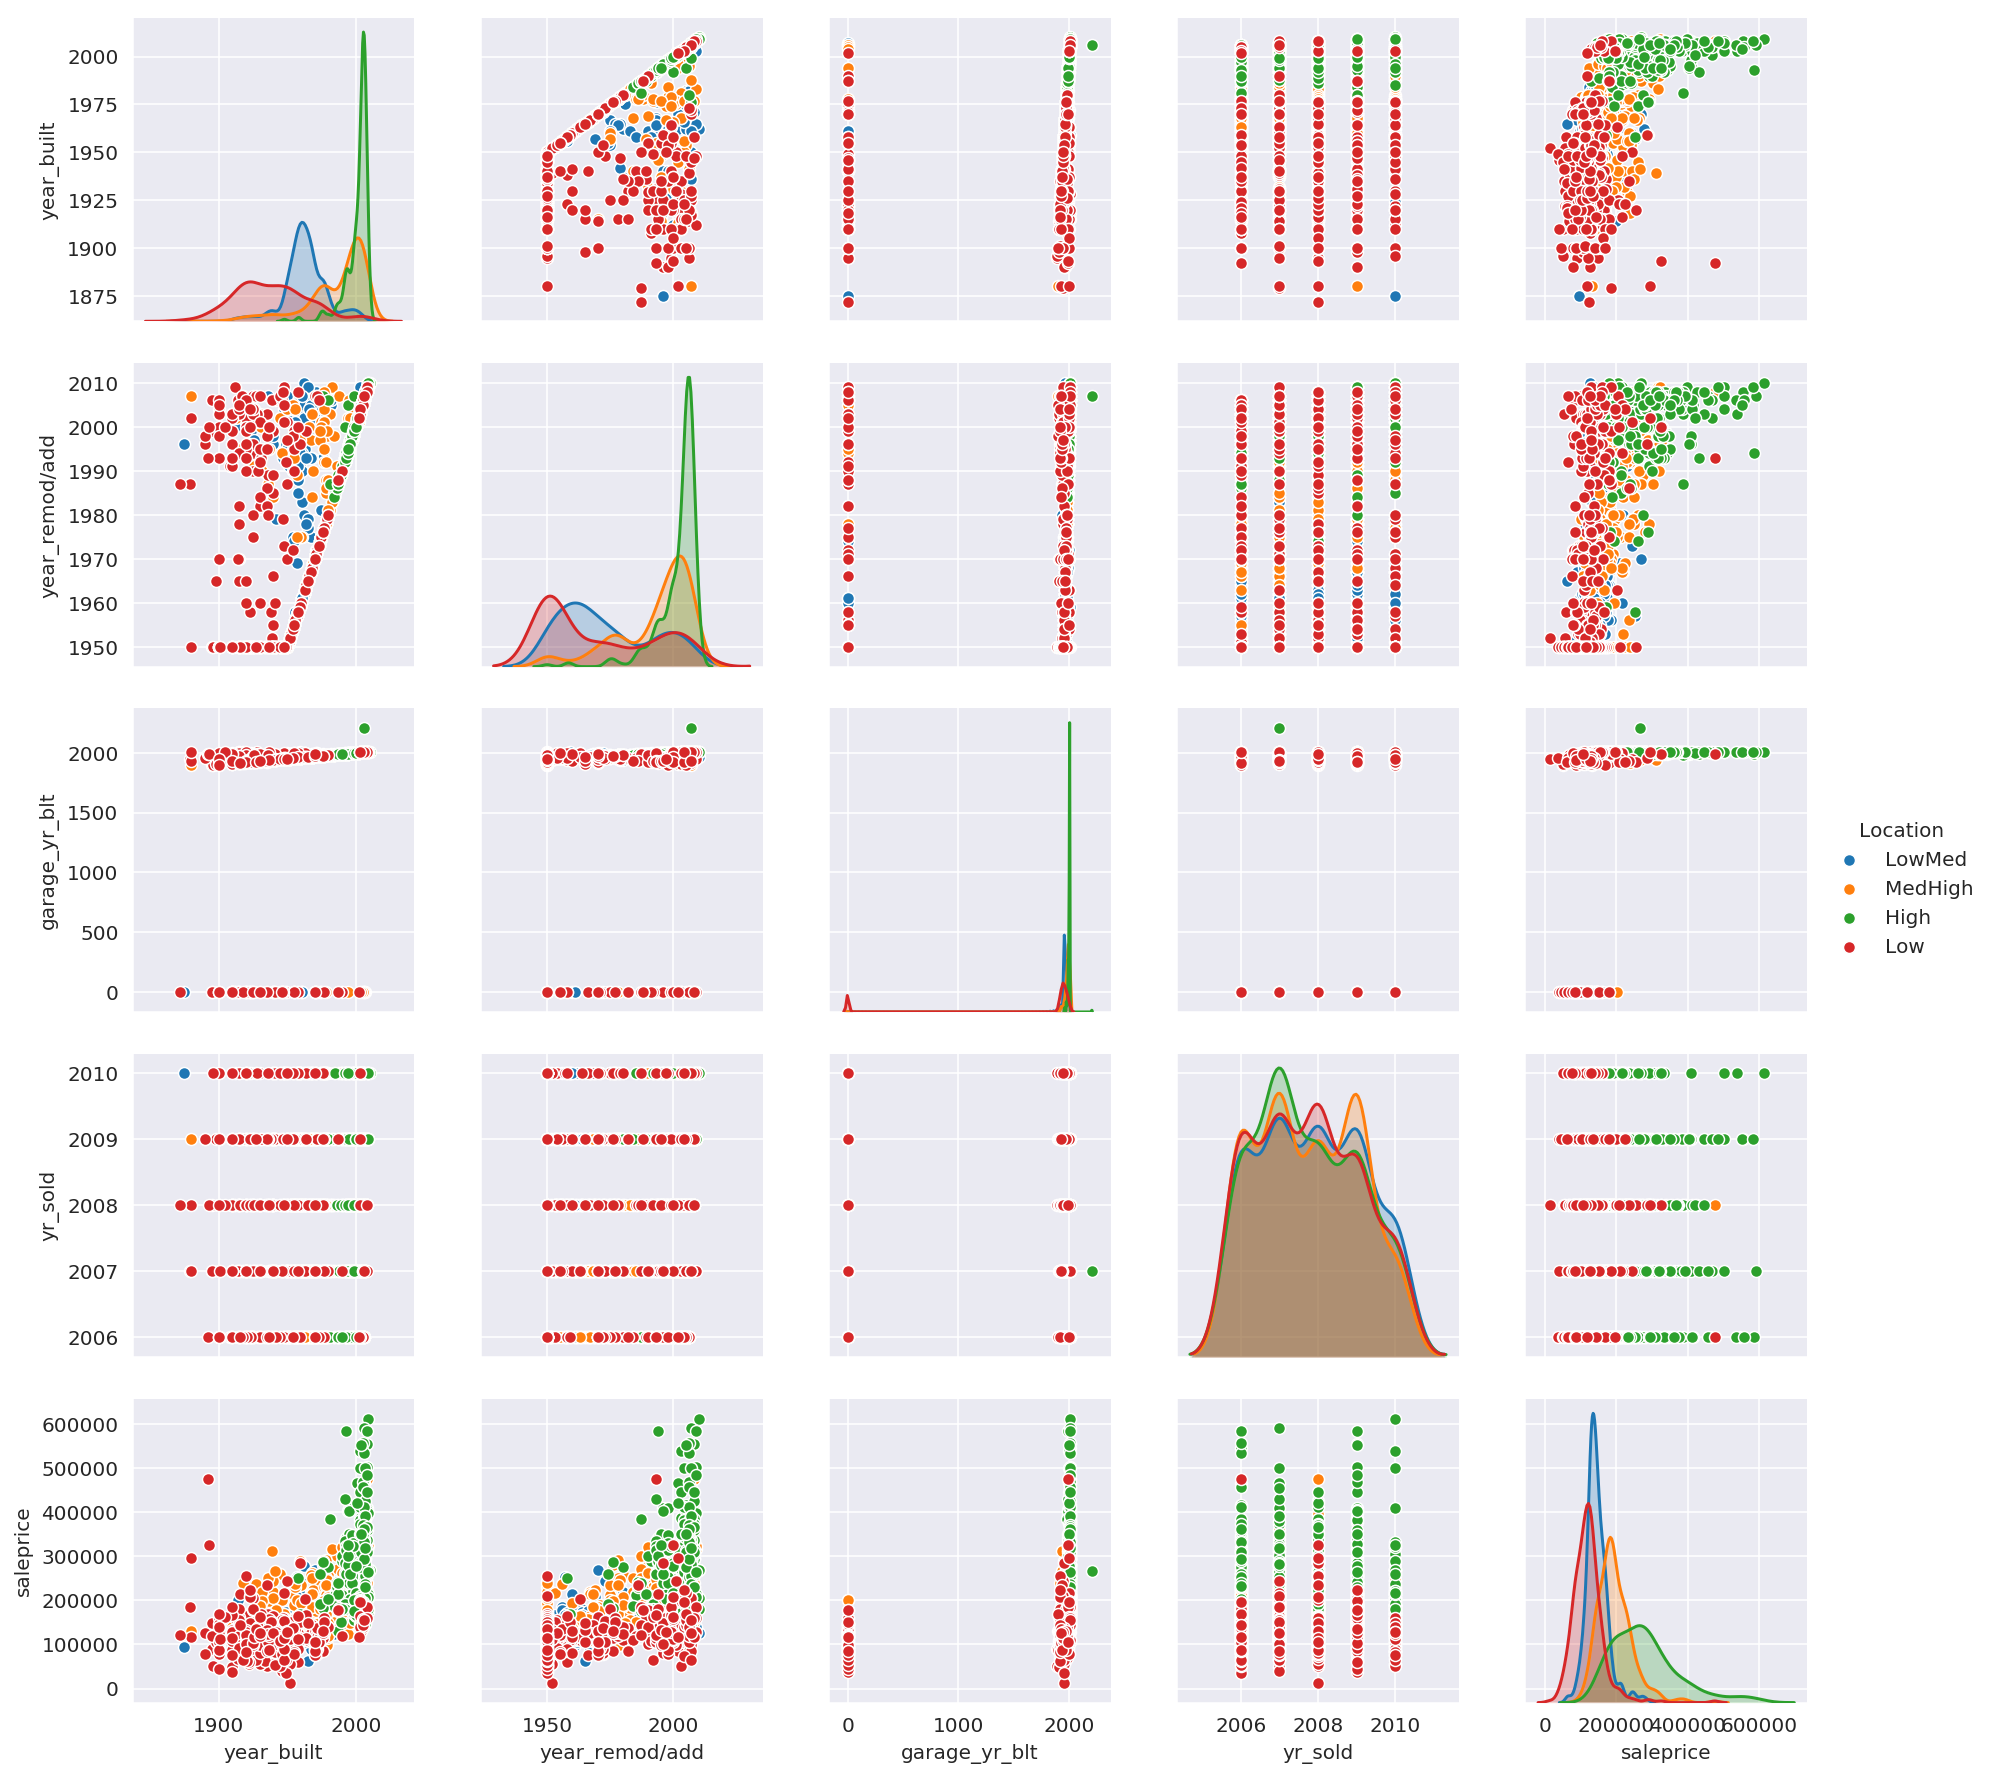

In [12]:
sns.pairplot(data = ames_train,
             vars = ['year_built','year_remod/add','garage_yr_blt','yr_sold','saleprice'],
             hue = 'Location');

Year built, and year remodeled, appear to have a slight correlation with saleprice, but year sold does not seem useful. Also, garage year built has some problematic data.

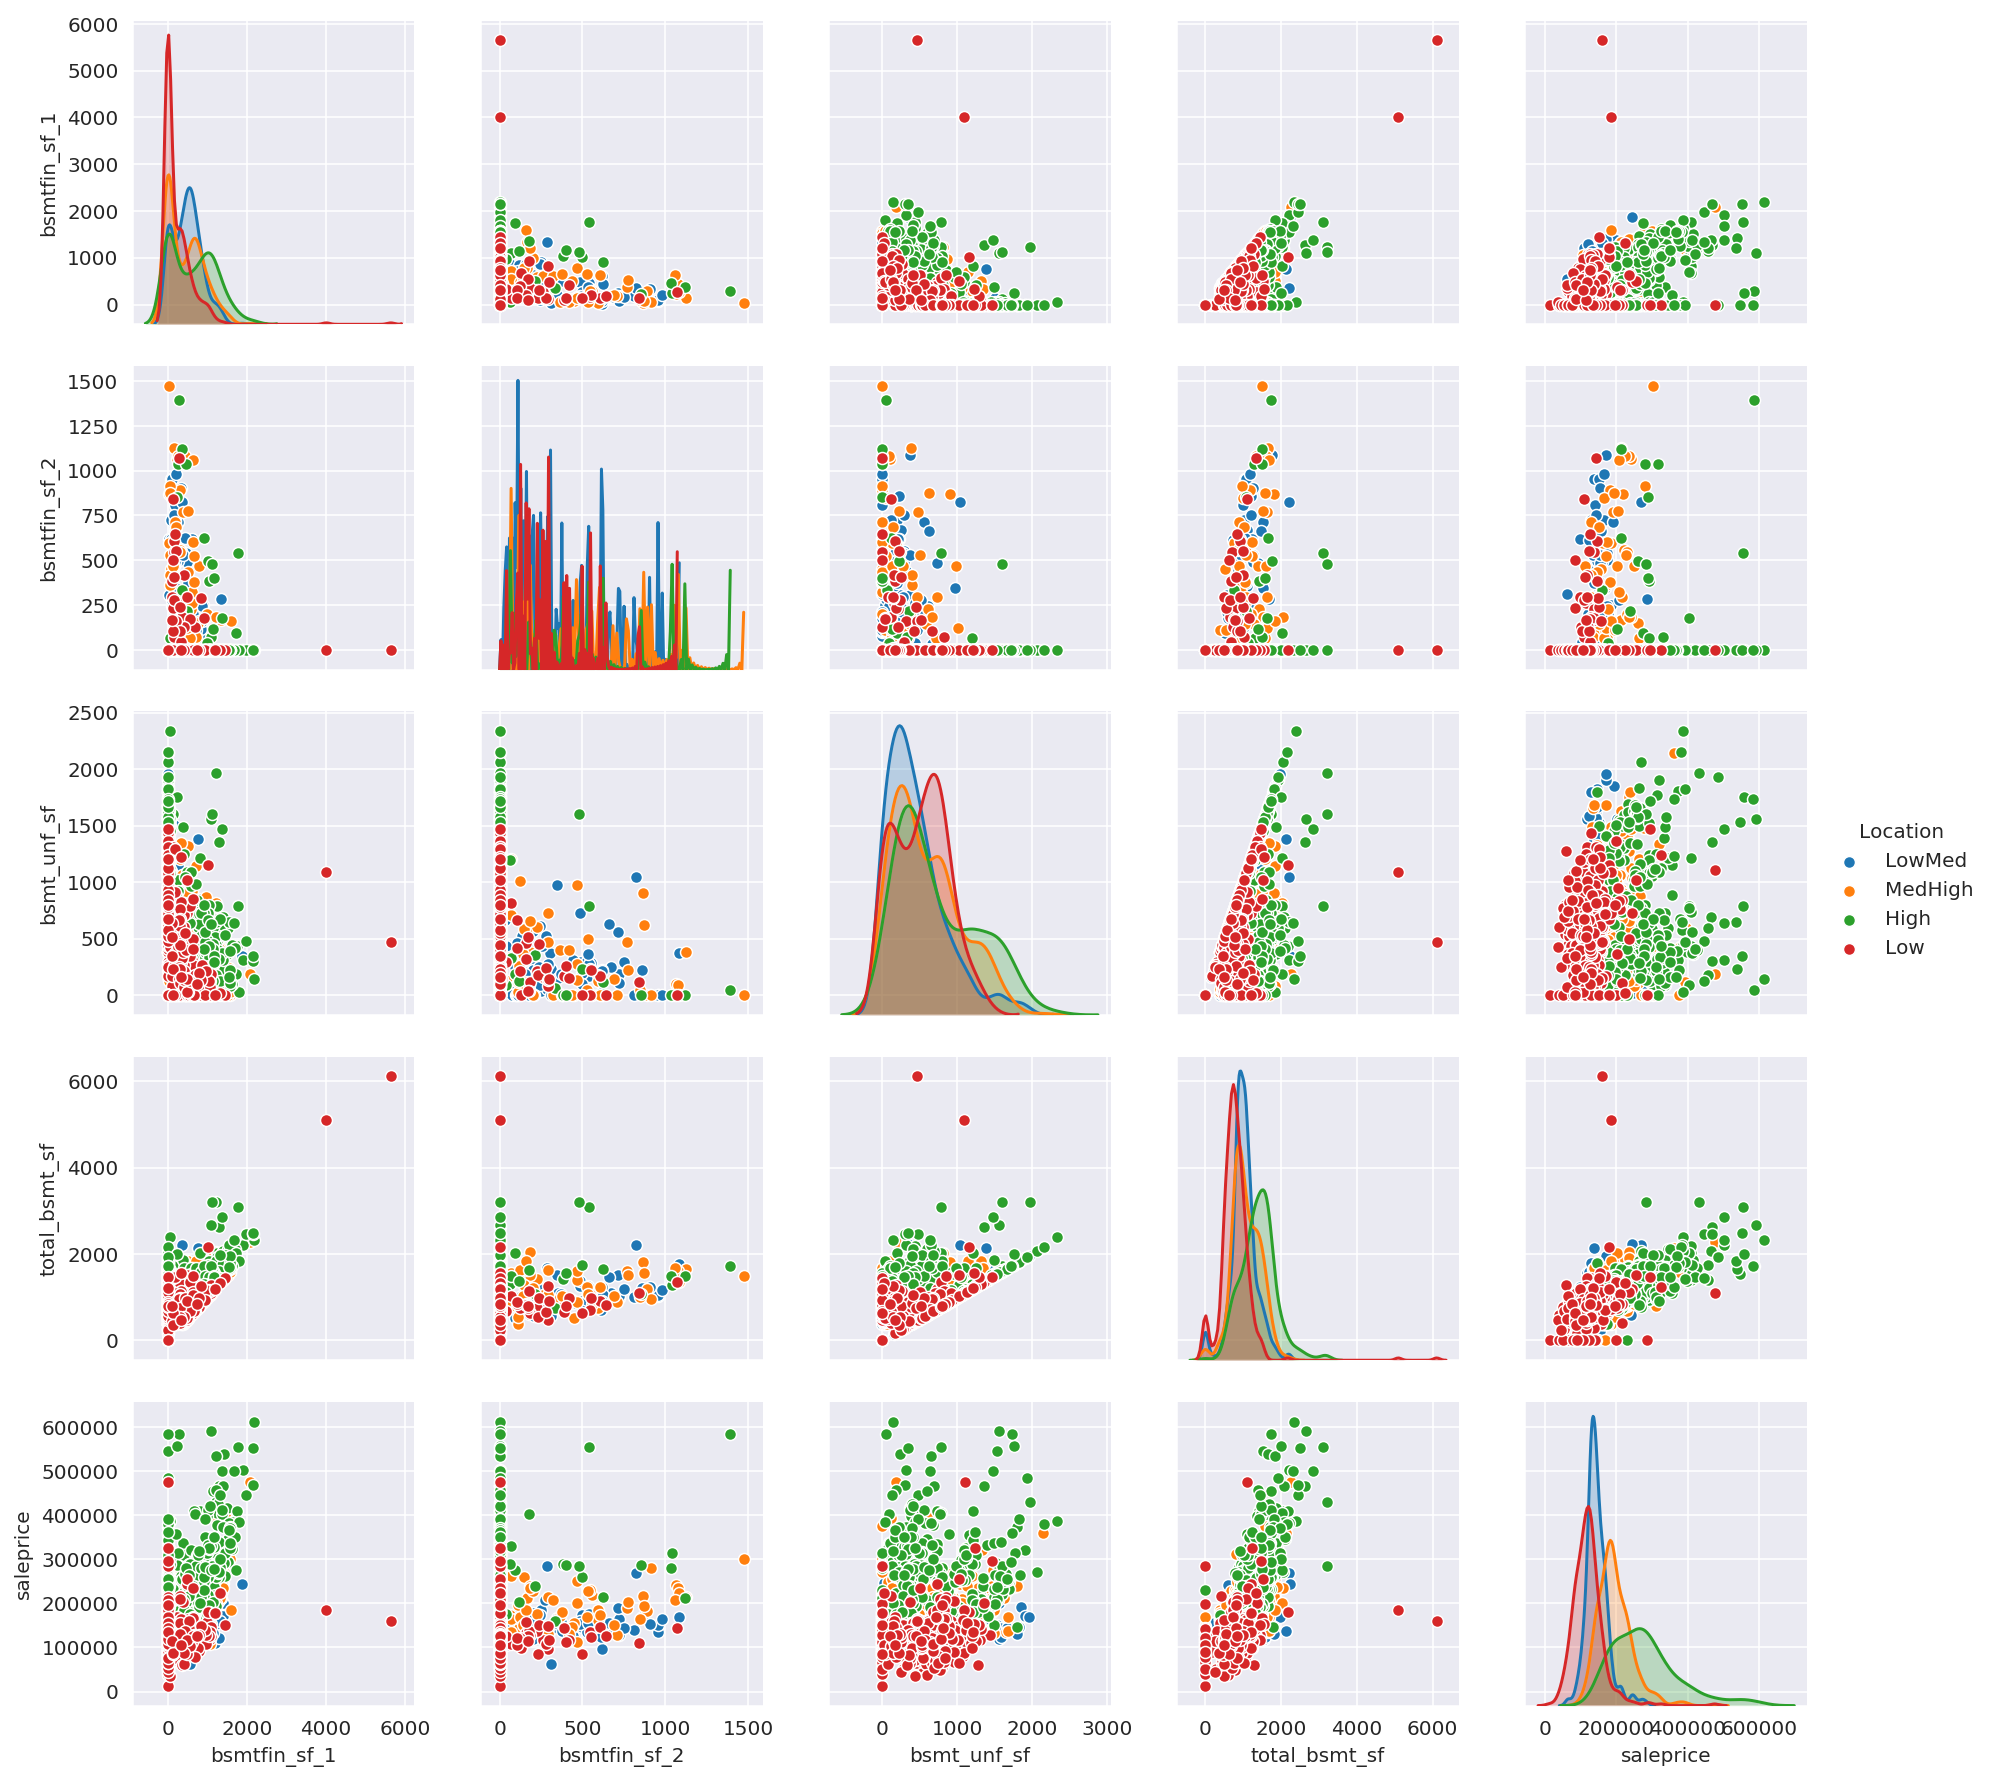

In [13]:
sns.pairplot(data = ames_train, 
             vars = ['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf','saleprice'],
             hue = 'Location');

Basement square footage appears to be a strong predictor of saleprice, with a couple of large outliers. Note that I may want to come back and examine those outliers.

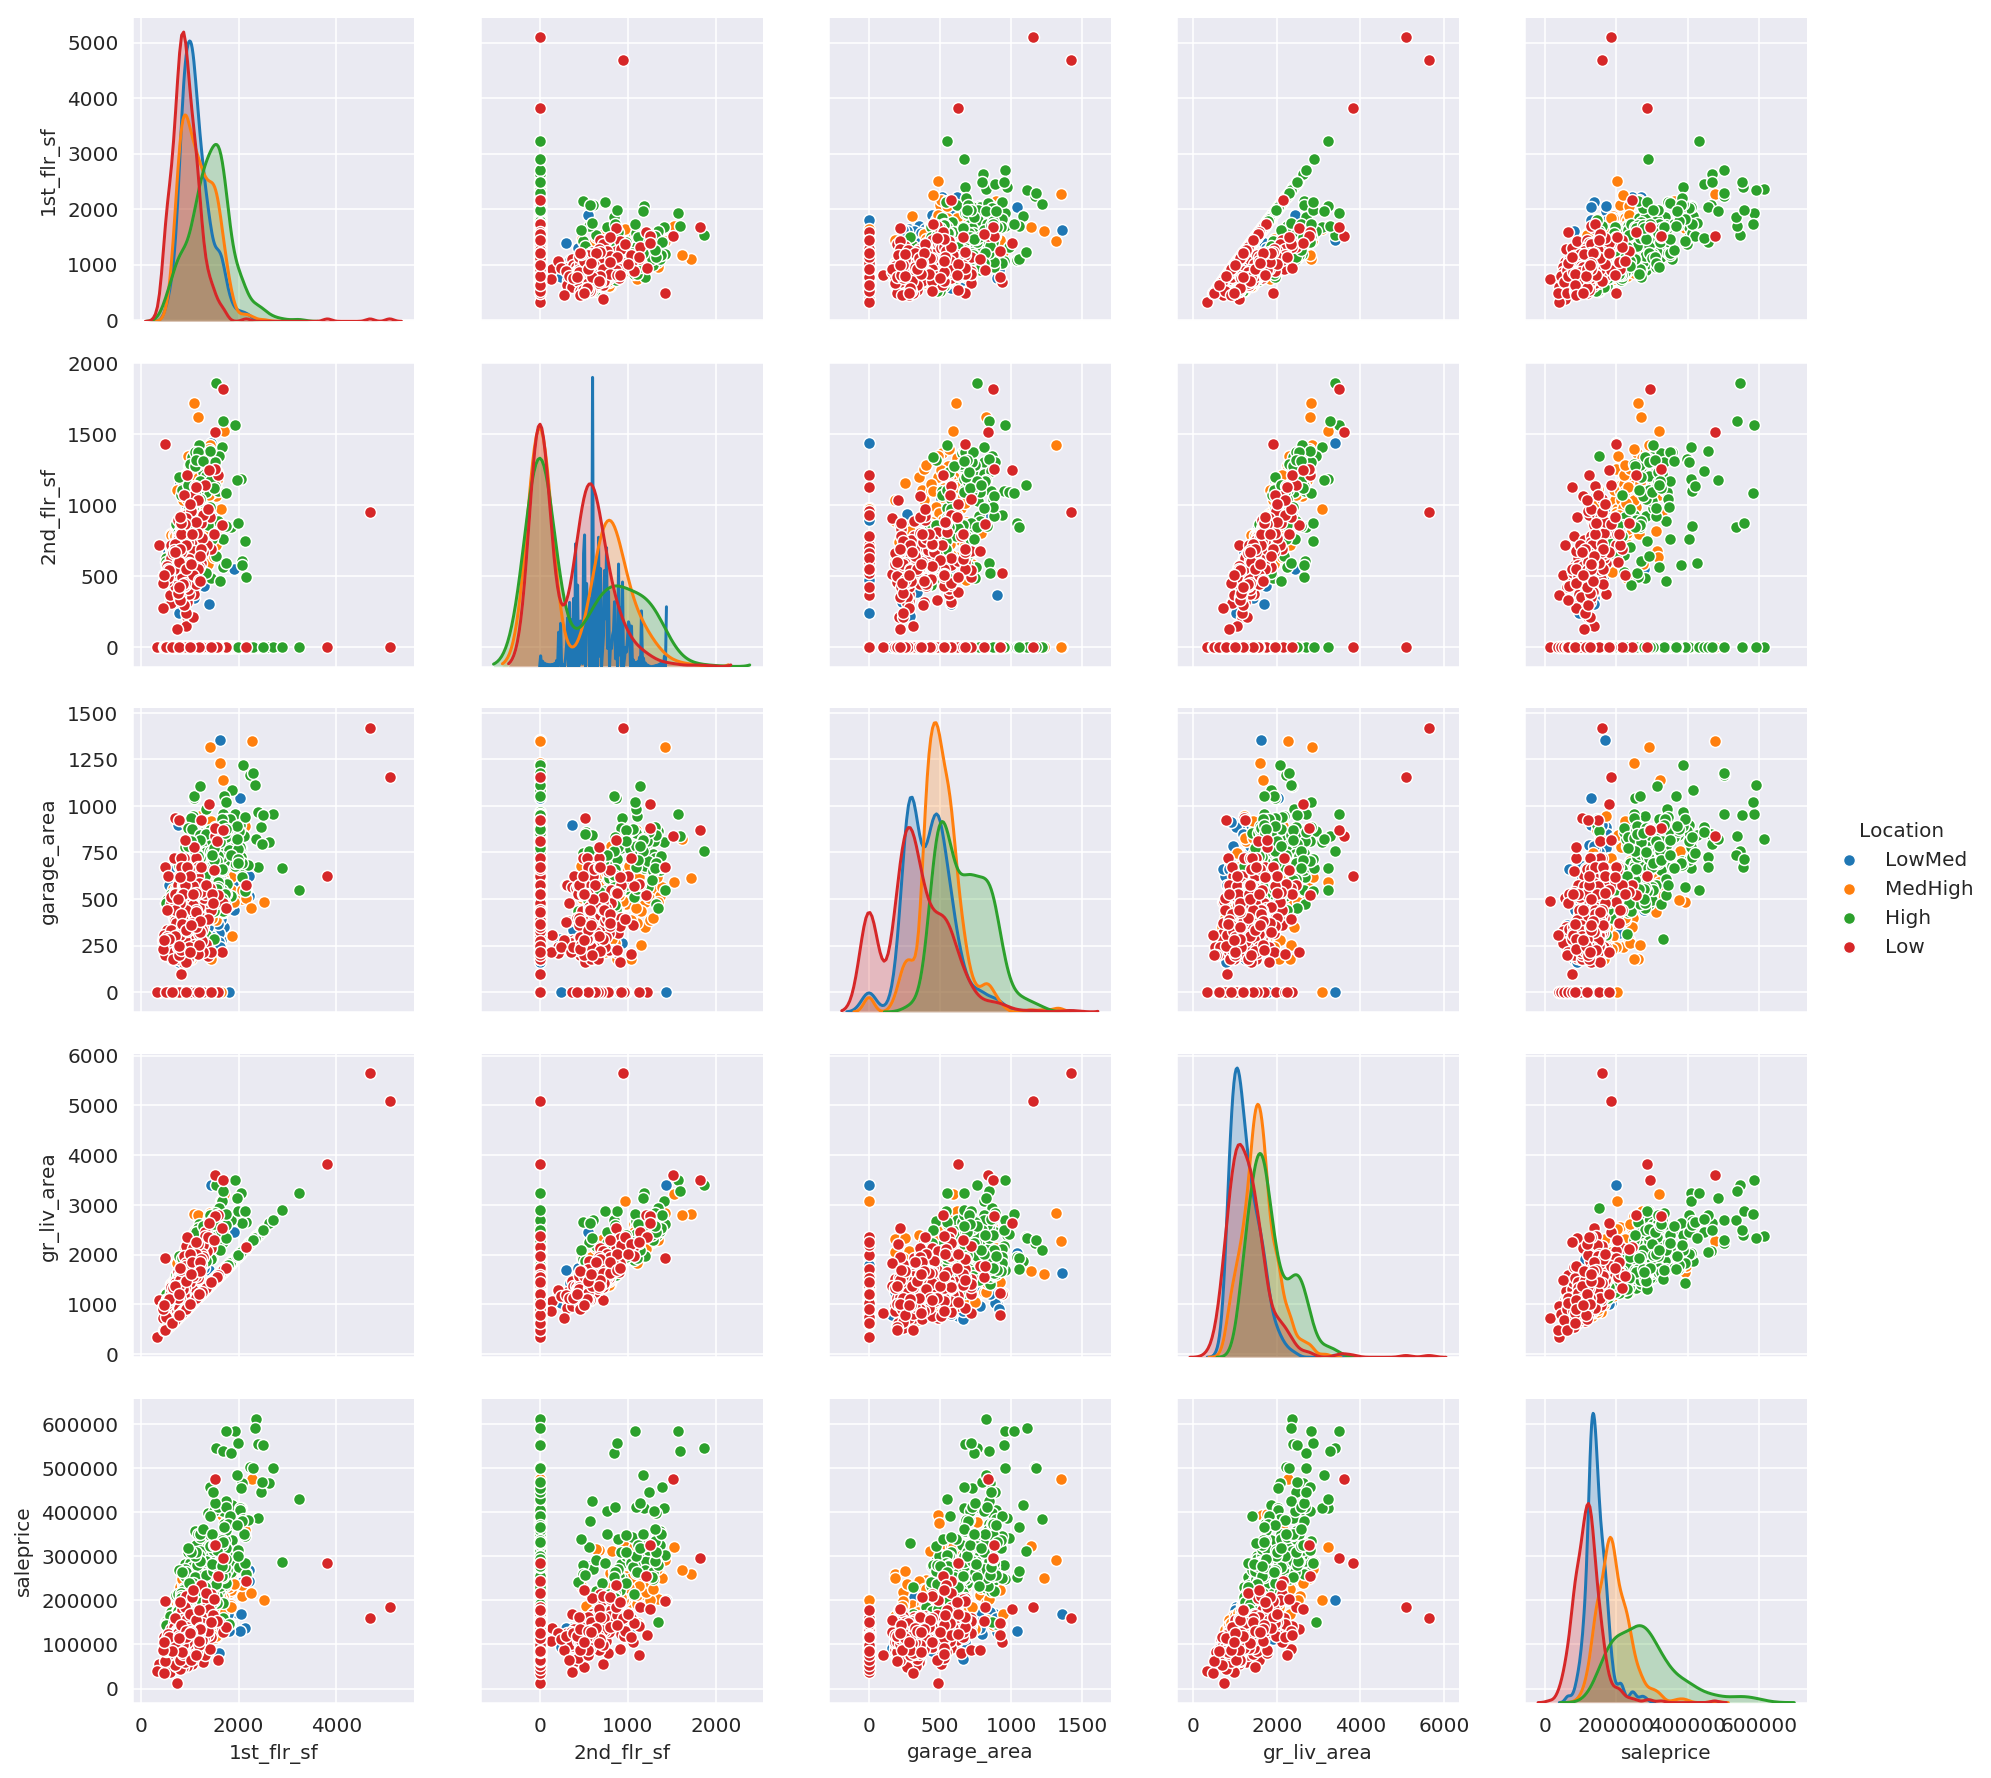

In [13]:
sns.pairplot(data = ames_train,
             vars = ['1st_flr_sf','2nd_flr_sf','garage_area','gr_liv_area','saleprice'],
             hue = 'Location');

I can see some clear outliers when I look at square footage (and living area) vs saleprice. In the visualizations above, it is obvious that the outliers are in neighborhoods with low median house prices. Originally I had not seen that dimension of the data, and the cells below show the digging that I did to discover what was driving the outliers.

In [15]:
pd.options.display.max_columns = 1000

mask = (ames_train['gr_liv_area'] > 3000) & (ames_train['saleprice'] < 200000)
ames_train[mask]

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
1885  2181  908154195           20        RL         128.0     39290   Pave   
960   1499  908154235           60        RL         313.0     63887   Pave   

     alley lot_shape land_contour utilities lot_config land_slope  \
1885    NA       IR1          Bnk    AllPub     Inside        Gtl   
960     NA       IR3          Bnk    AllPub     Corner        Gtl   

     neighborhood condition_1 condition_2 bldg_type house_style  overall_qual  \
1885      Edwards        Norm        Norm      1Fam      1Story            10   
960       Edwards       Feedr        Norm      1Fam      2Story            10   

      overall_cond  year_built  year_remod/add roof_style roof_matl  \
1885             5        2008            2009        Hip   CompShg   
960              5        2008            2008        Hip   ClyTile   

     exterior_1st exterior_2nd mas_vnr_type  mas_vnr_area exter_qual  \
1885      CemntBd      CmentBd        Stone        1224.0         Ex   
960        Stucco       Stucco        Stone         796.0         Ex   

     exter_cond foundation bsmt_qual bsmt_cond bsmt_exposure bsmtfin_type_1  \
1885         TA      PConc        Ex        TA            Gd            GLQ   
960          TA      PConc        Ex        TA            Gd            GLQ   

      bsmtfin_sf_1 bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  \
1885        4010.0            Unf           0.0       1085.0         5095.0   
960         5644.0            Unf           0.0        466.0         6110.0   

     heating heating_qc central_air electrical  1st_flr_sf  2nd_flr_sf  \
1885    GasA         Ex           Y      SBrkr        5095           0   
960     GasA         Ex           Y      SBrkr        4692         950   

      low_qual_fin_sf  gr_liv_area  bsmt_full_bath  bsmt_half_bath  full_bath  \
1885                0         5095             1.0             1.0          2   
960                 0         5642             2.0             0.0          2   

      half_bath  bedroom_abvgr  kitchen_abvgr kitchen_qual  totrms_abvgrd  \
1885          1              2              1           Ex             15   
960           1              3              1           Ex             12   

     functional  fireplaces fireplace_qu garage_type  garage_yr_blt  \
1885        Typ           2           Gd      Attchd         2008.0   
960         Typ           3           Gd      Attchd         2008.0   

     garage_finish  garage_cars  garage_area garage_qual garage_cond  \
1885           Fin          3.0       1154.0          TA          TA   
960            Fin          2.0       1418.0          TA          TA   

     paved_drive  wood_deck_sf  open_porch_sf  enclosed_porch  3ssn_porch  \
1885           Y           546            484               0           0   
960            Y           214            292               0           0   

      screen_porch  pool_area pool_qc fence misc_feature  misc_val  mo_sold  \
1885             0          0      NA    NA         Elev     17000       10   
960              0        480      Gd    NA           NA         0        1   

      yr_sold sale_type  saleprice Location  
1885     2007       New     183850      Low  
960      2008       New     160000      Low

Looking more closely at my two most egregious outliers, I can see they have a couple of things in common. Both were built and sold in 2008, and both are located in the Edwards neighborhood. At first, I decided to look into the Edwards neighborhood specifically, both in the data and in outside research. When I didn't find anything particularly striking about that neighborhood, I decided to try to group the neighborhoods according to median house price, to make visualization a little easier. This was one of the biggest breakthroughs in designing my model.

In [16]:
mask_edwards = (ames_train['neighborhood'] == 'Edwards')
ames_train[mask_edwards].describe().T

count          mean           std          min           25%  \
id               104.0  1.591644e+03  8.747281e+02        236.0  7.927500e+02   
pid              104.0  9.071072e+08  1.518195e+06  904301060.0  9.054522e+08   
ms_subclass      104.0  5.432692e+01  4.451496e+01         20.0  2.000000e+01   
lot_frontage      96.0  6.812500e+01  3.105759e+01         24.0  5.800000e+01   
lot_area         104.0  1.056308e+04  7.612898e+03       2522.0  7.835500e+03   
overall_qual     104.0  5.038462e+00  1.189950e+00          1.0  4.000000e+00   
overall_cond     104.0  5.461538e+00  1.291669e+00          1.0  5.000000e+00   
year_built       104.0  1.955125e+03  2.608823e+01       1900.0  1.941000e+03   
year_remod/add   104.0  1.971462e+03  2.215169e+01       1950.0  1.950000e+03   
mas_vnr_area     104.0  5.079808e+01  1.605268e+02          0.0  0.000000e+00   
bsmtfin_sf_1     104.0  4.334231e+02  7.337614e+02          0.0  0.000000e+00   
bsmtfin_sf_2     104.0  3.394231e+01  1.223957e+02          0.0  0.000000e+00   
bsmt_unf_sf      104.0  4.604808e+02  3.994133e+02          0.0  1.115000e+02   
total_bsmt_sf    104.0  9.278462e+02  7.506029e+02          0.0  6.802500e+02   
1st_flr_sf       104.0  1.123087e+03  6.540363e+02        495.0  8.312500e+02   
2nd_flr_sf       104.0  2.085192e+02  3.290414e+02          0.0  0.000000e+00   
low_qual_fin_sf  104.0  7.807692e+00  5.636257e+01          0.0  0.000000e+00   
gr_liv_area      104.0  1.339413e+03  7.036087e+02        605.0  1.053750e+03   
bsmt_full_bath   104.0  4.807692e-01  6.533078e-01          0.0  0.000000e+00   
bsmt_half_bath   104.0  9.615385e-02  3.557907e-01          0.0  0.000000e+00   
full_bath        104.0  1.346154e+00  5.706278e-01          0.0  1.000000e+00   
half_bath        104.0  2.019231e-01  4.267695e-01          0.0  0.000000e+00   
bedroom_abvgr    104.0  2.913462e+00  8.373627e-01          1.0  2.000000e+00   
kitchen_abvgr    104.0  1.057692e+00  3.061481e-01          0.0  1.000000e+00   
totrms_abvgrd    104.0  6.134615e+00  1.757413e+00          4.0  5.000000e+00   
fireplaces       104.0  3.365385e-01  6.326179e-01          0.0  0.000000e+00   
garage_yr_blt    104.0  1.492577e+03  8.439728e+02          0.0  1.920000e+03   
garage_cars      104.0  1.134615e+00  7.889737e-01          0.0  1.000000e+00   
garage_area      104.0  3.167115e+02  2.464515e+02          0.0  2.055000e+02   
wood_deck_sf     104.0  6.695192e+01  1.241134e+02          0.0  0.000000e+00   
open_porch_sf    104.0  2.988462e+01  7.413950e+01          0.0  0.000000e+00   
enclosed_porch   104.0  2.335577e+01  5.244820e+01          0.0  0.000000e+00   
3ssn_porch       104.0  0.000000e+00  0.000000e+00          0.0  0.000000e+00   
screen_porch     104.0  9.480769e+00  3.849070e+01          0.0  0.000000e+00   
pool_area        104.0  4.615385e+00  4.706787e+01          0.0  0.000000e+00   
misc_val         104.0  2.125000e+02  1.692111e+03          0.0  0.000000e+00   
mo_sold          104.0  5.932692e+00  2.349404e+00          1.0  4.000000e+00   
yr_sold          104.0  2.007856e+03  1.354018e+00       2006.0  2.007000e+03   
saleprice        104.0  1.250891e+05  3.795908e+04      60000.0  1.012500e+05   

                         50%           75%          max  
id                    1502.0  2.186250e+03       2842.0  
pid              908103200.0  9.082011e+08  909101140.0  
ms_subclass             50.0  7.000000e+01        190.0  
lot_frontage            64.5  7.400000e+01        313.0  
lot_area              9310.0  1.066875e+04      63887.0  
overall_qual             5.0  6.000000e+00         10.0  
overall_cond             5.0  6.000000e+00          9.0  
year_built            1954.0  1.966500e+03       2008.0  
year_remod/add        1960.0  1.996000e+03       2009.0  
mas_vnr_area             0.0  0.000000e+00       1224.0  
bsmtfin_sf_1           220.0  6.132500e+02       5644.0  
bsmtfin_sf_2             0.0  0.000000e+00        841.0  
bsmt_unf_sf           

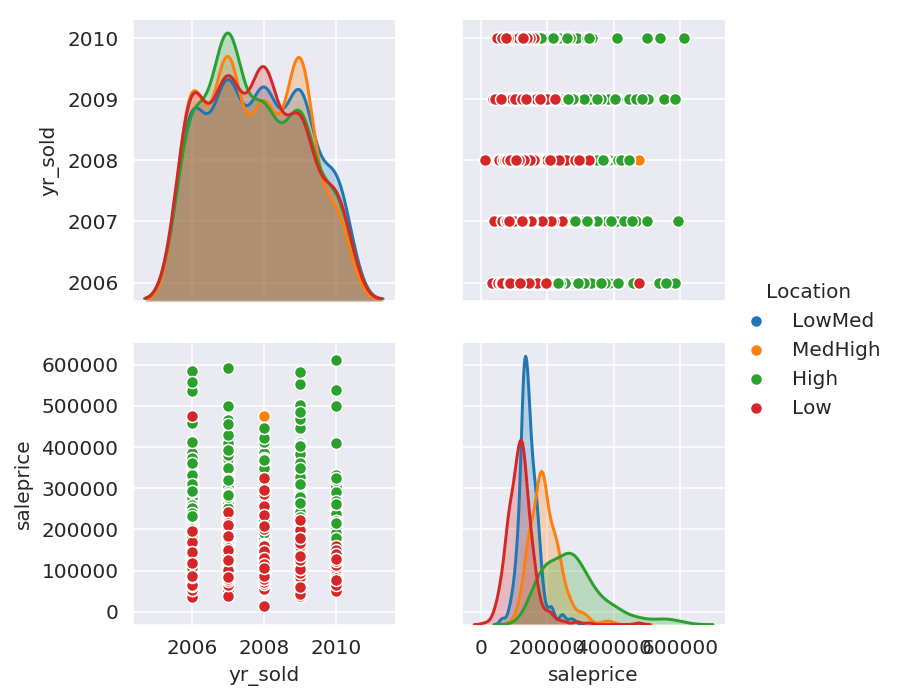

In [17]:
sns.pairplot(data = ames_train,
             vars = ['yr_sold','saleprice'],
             hue = 'Location');

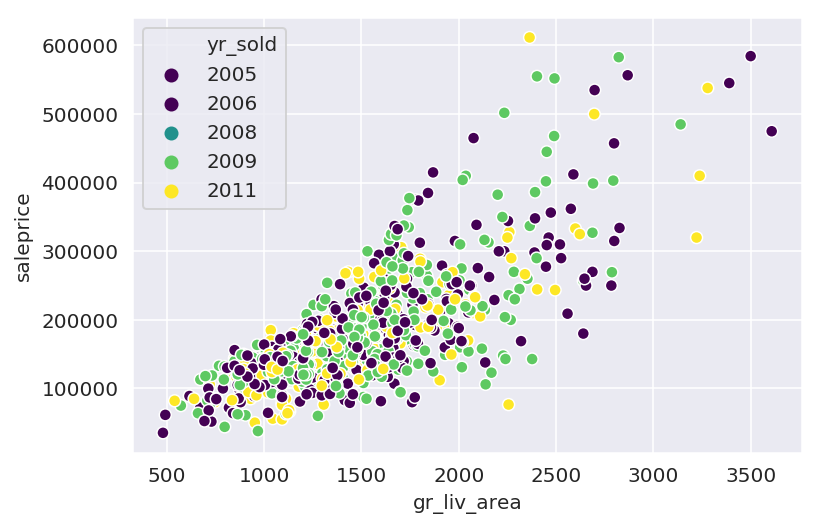

In [18]:
mask = (ames_train['yr_sold'] == 2007) | (ames_train['yr_sold'] == 2008)
sns.scatterplot(x = 'gr_liv_area', y = 'saleprice', hue = 'yr_sold', data = ames_train[~mask], palette = 'viridis')

I thought that perhaps the interaction of year sold and location might be a significant factor (if a particular neighborhood was severely hit by the 2008 crash for example) but did not find anything to note here.

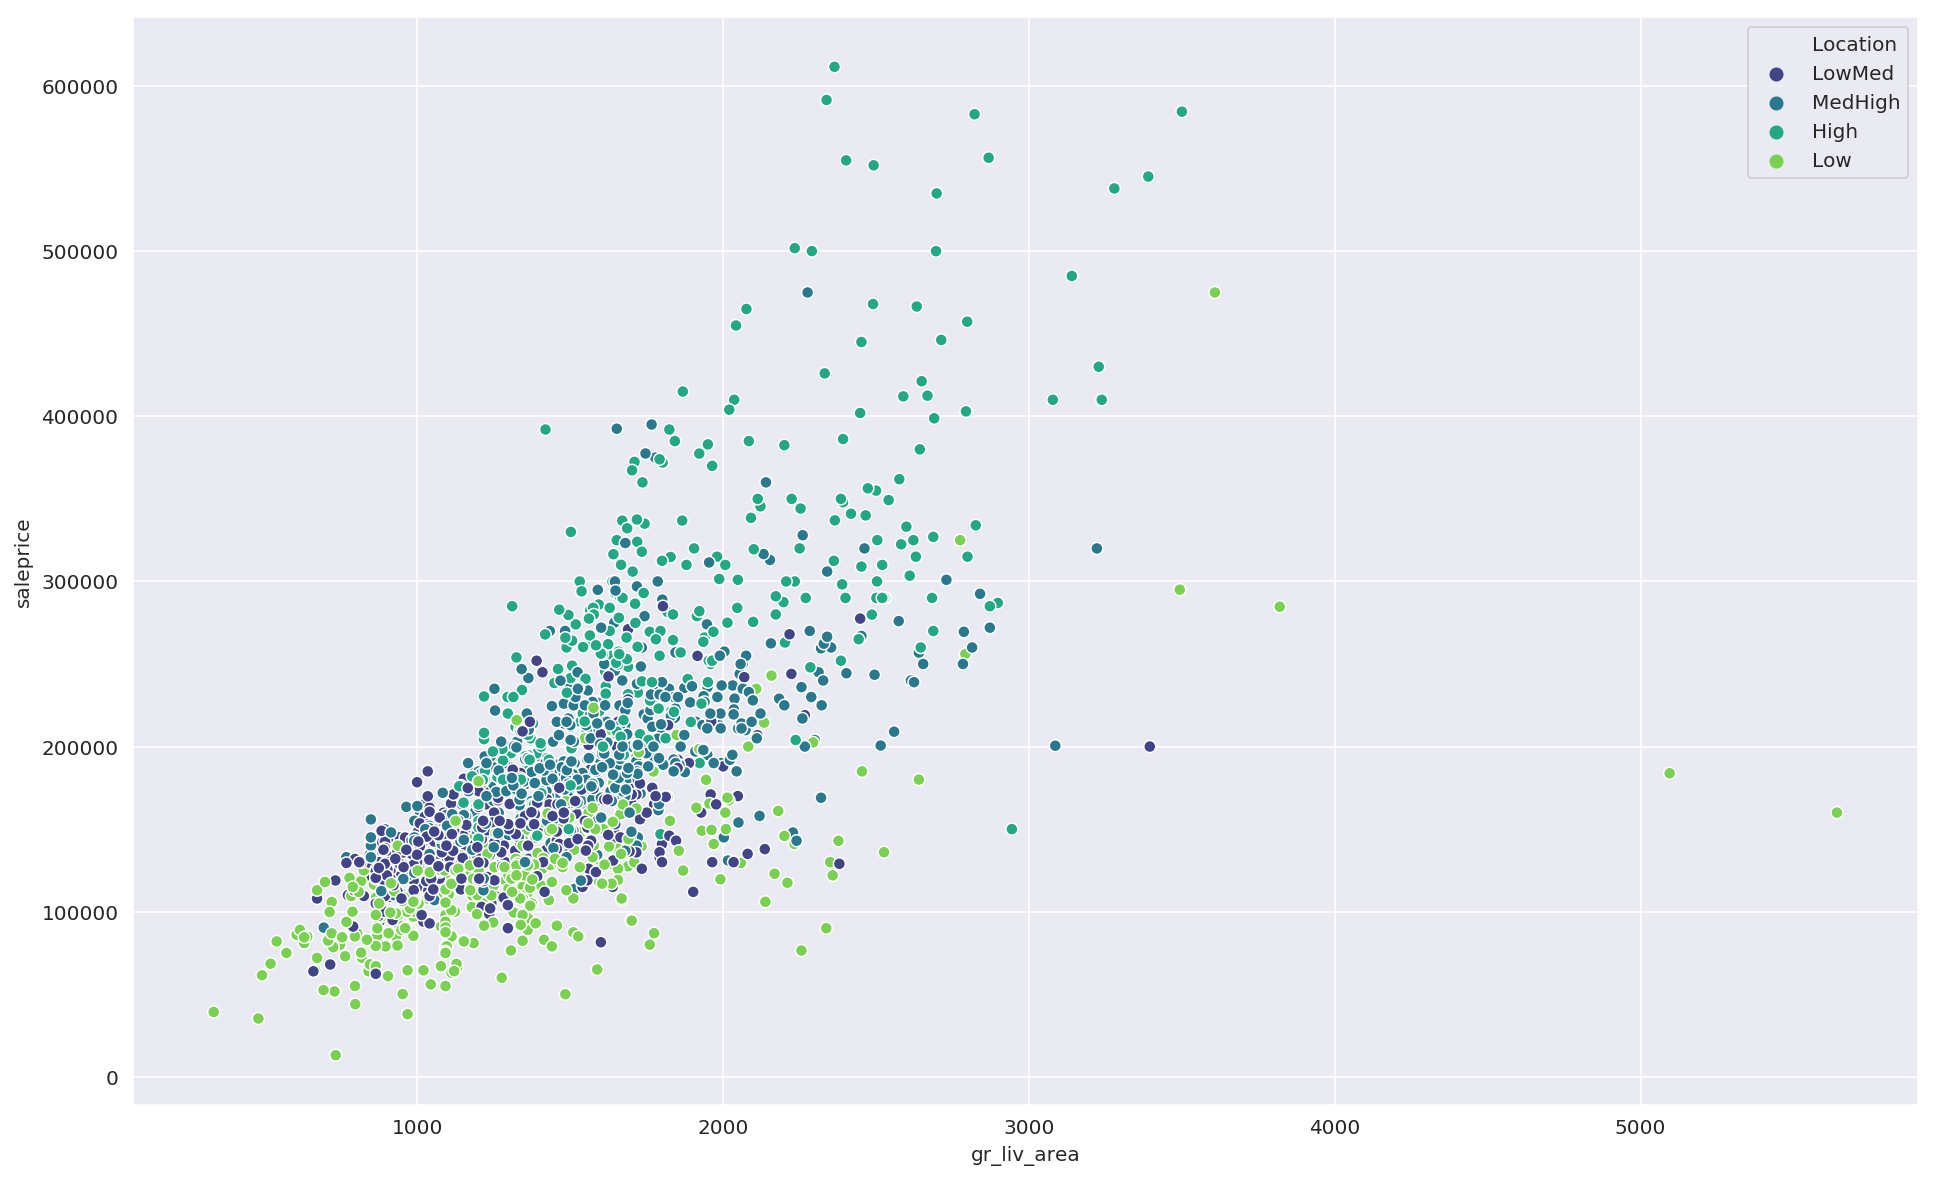

In [22]:
figure, ax = plt.subplots(figsize = (16,10))
sns.scatterplot(x = 'gr_liv_area', y = 'saleprice', hue = 'Location', data = ames_train, palette = 'viridis')

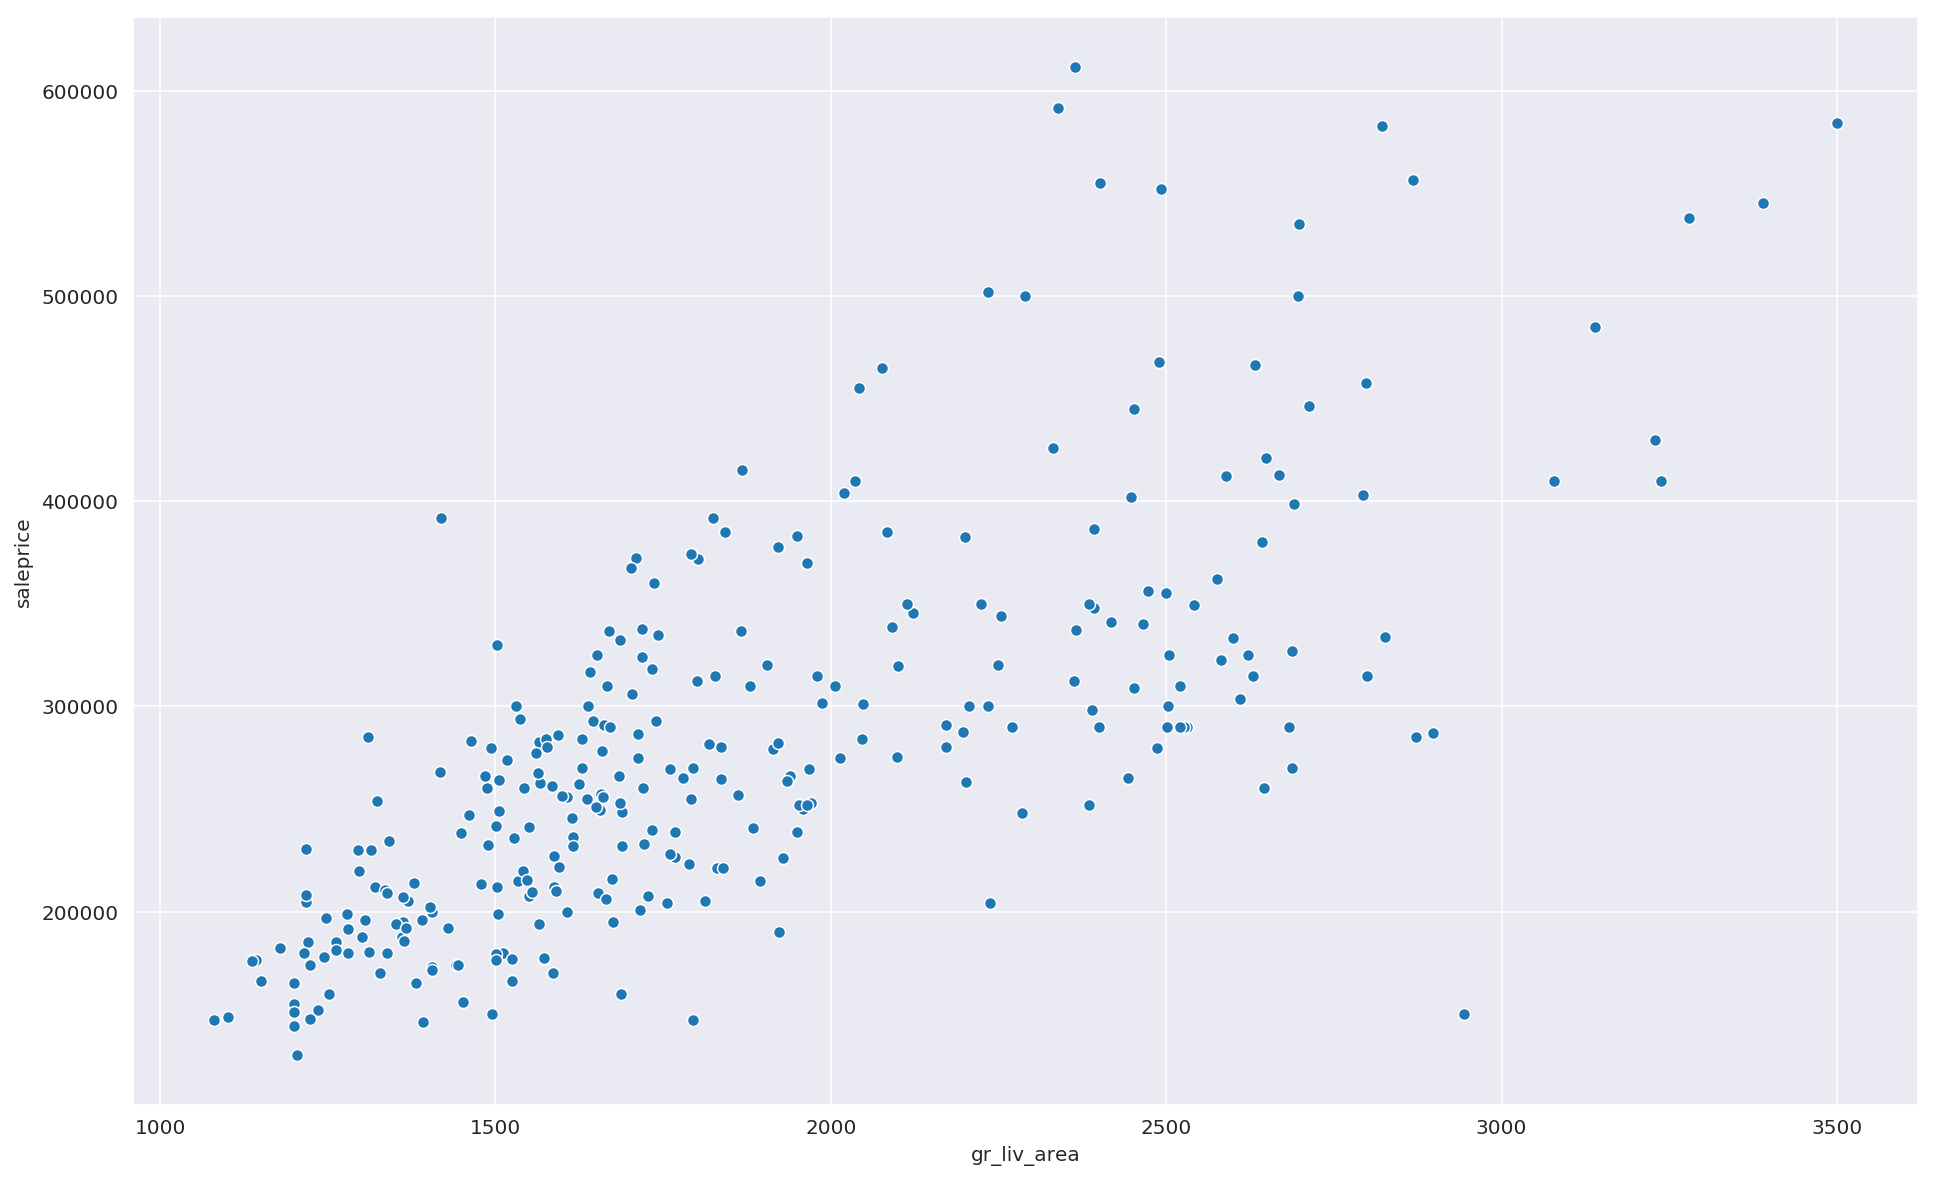

In [23]:
mask_high = ames_train['Location'] == 'High'
figure, ax = plt.subplots(figsize = (16,10))
sns.scatterplot(x = 'gr_liv_area', y = 'saleprice', data = ames_train[mask_high], palette = 'viridis')

Note the above graphs show how location affects the relationship between house size and sale price, and how much stronger the relationship appears after accounting for the anomaly of large houses in lower priced neighborhoods.

## More Scatterplots

### Exploring some other features...

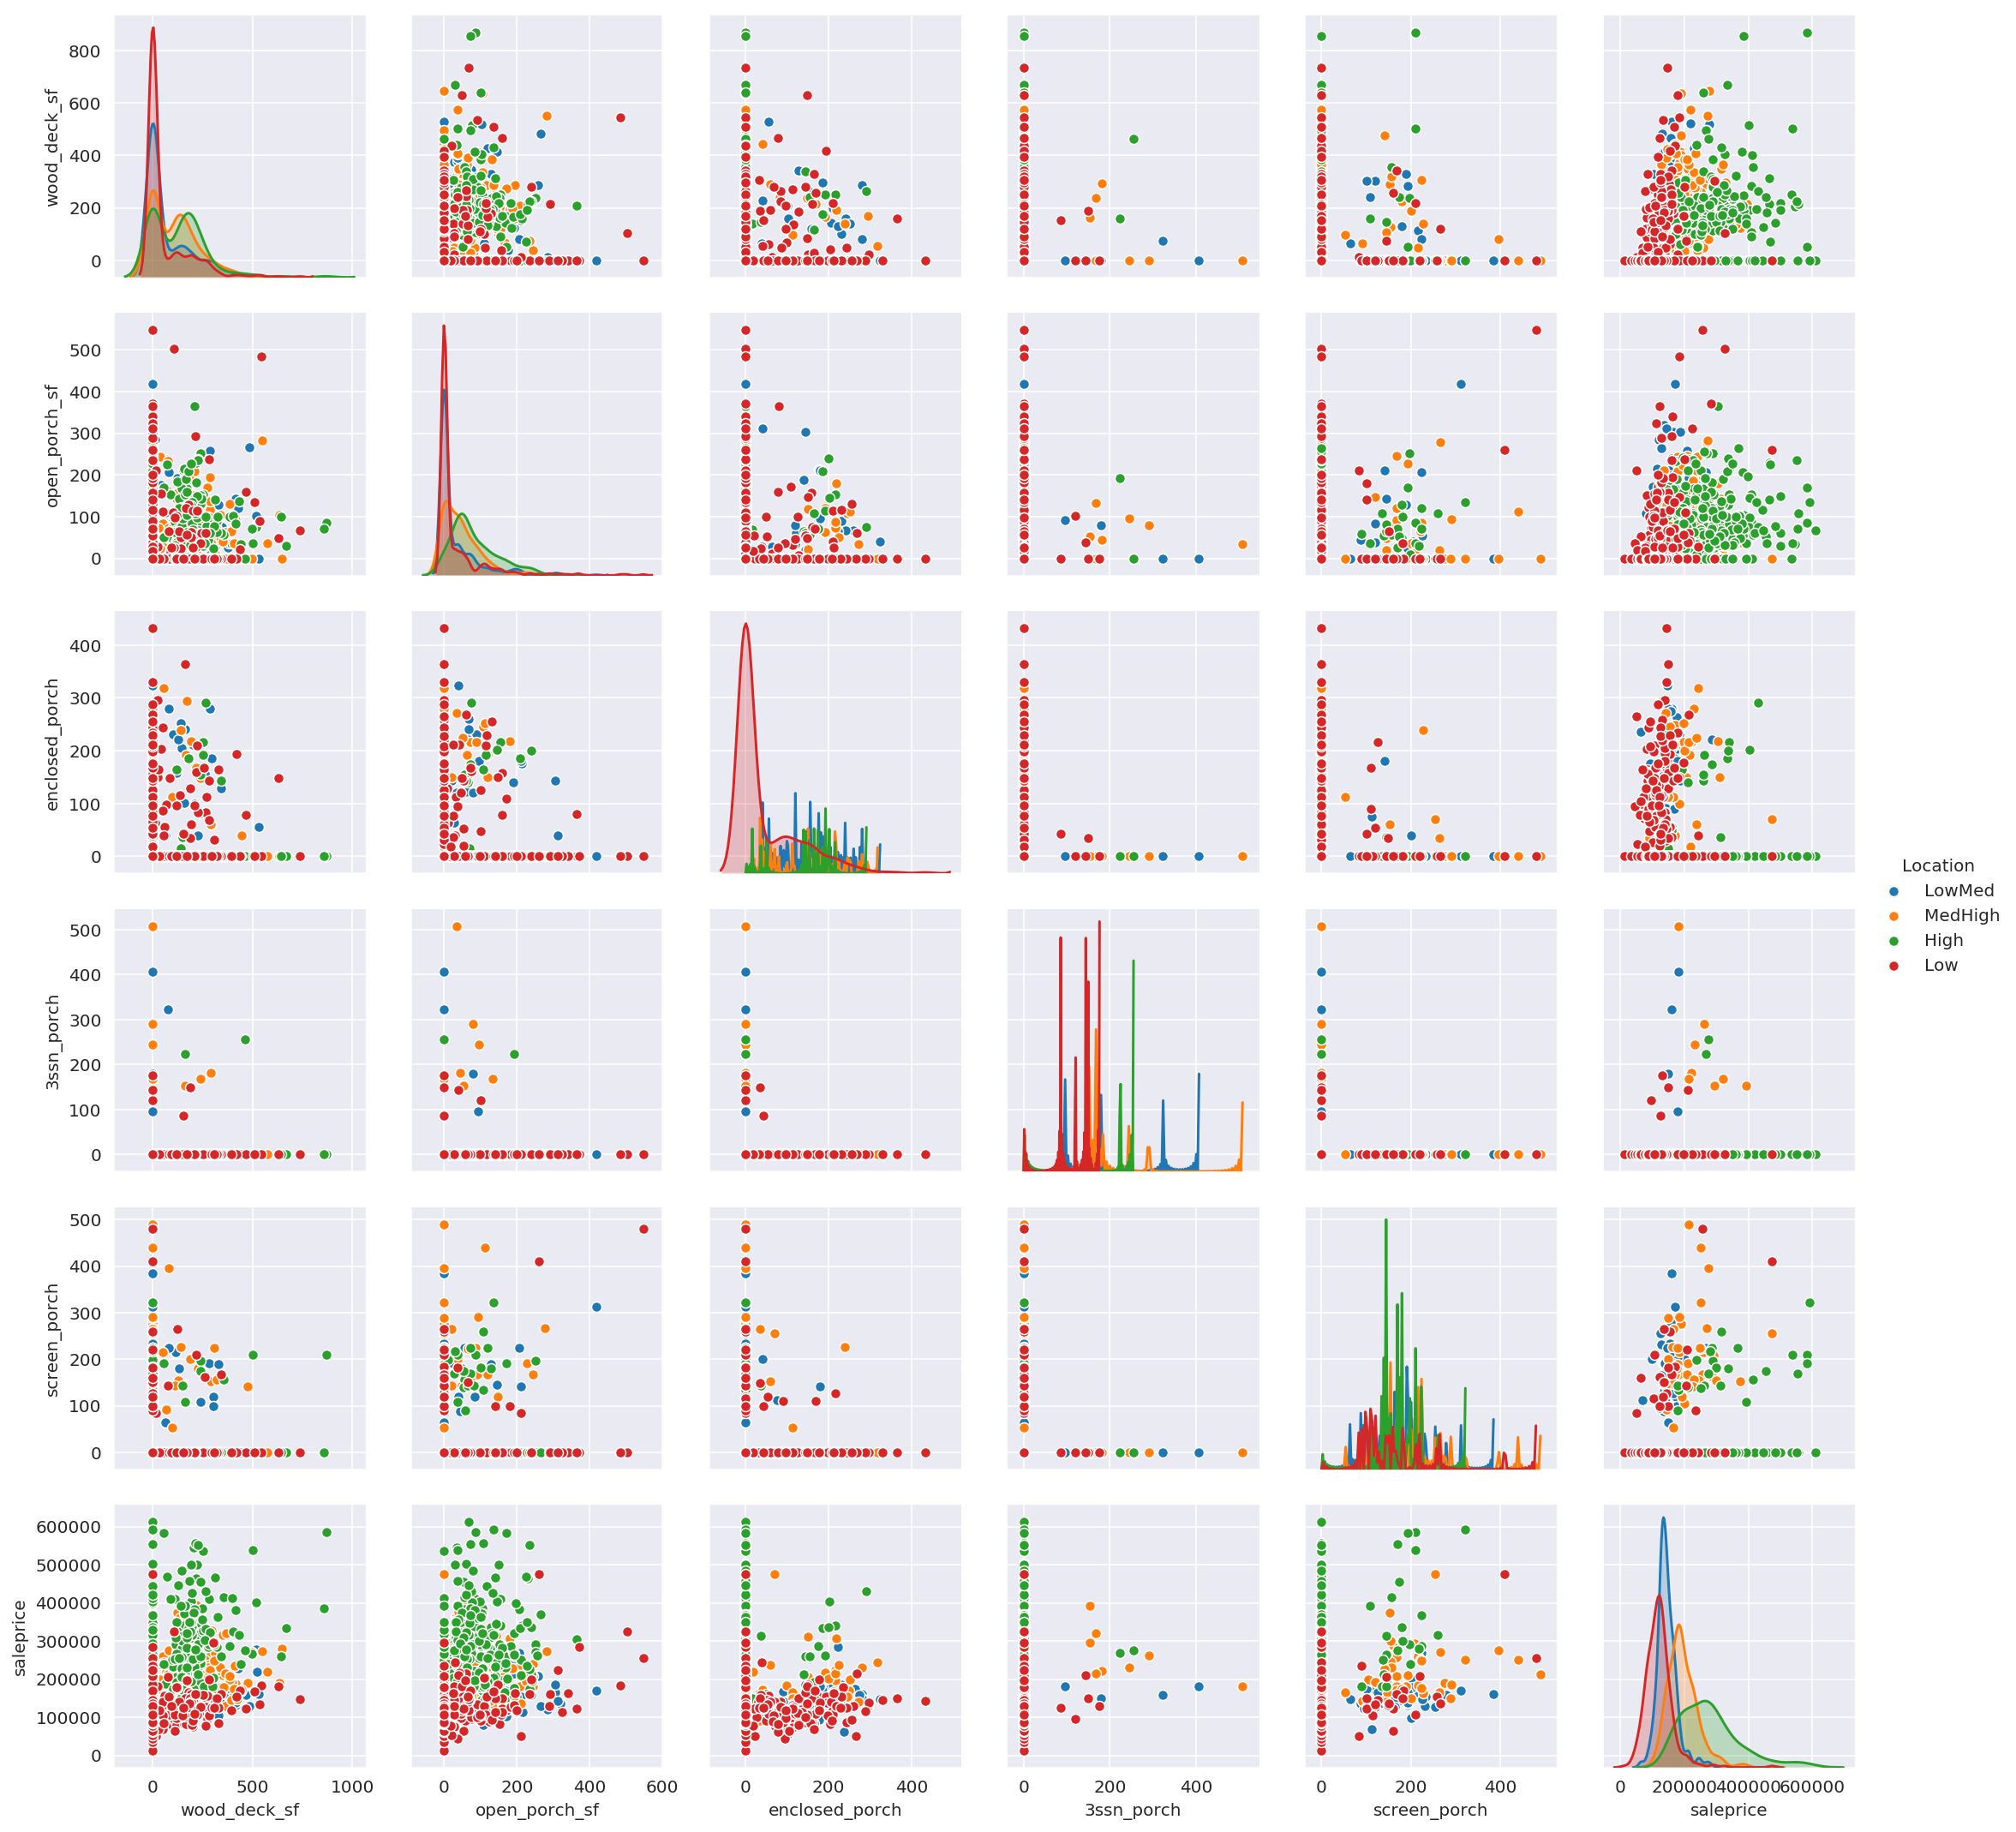

In [27]:
sns.pairplot(data = ames_train,
             vars = ['wood_deck_sf','open_porch_sf','enclosed_porch','3ssn_porch','screen_porch','saleprice'],
             hue = 'Location');

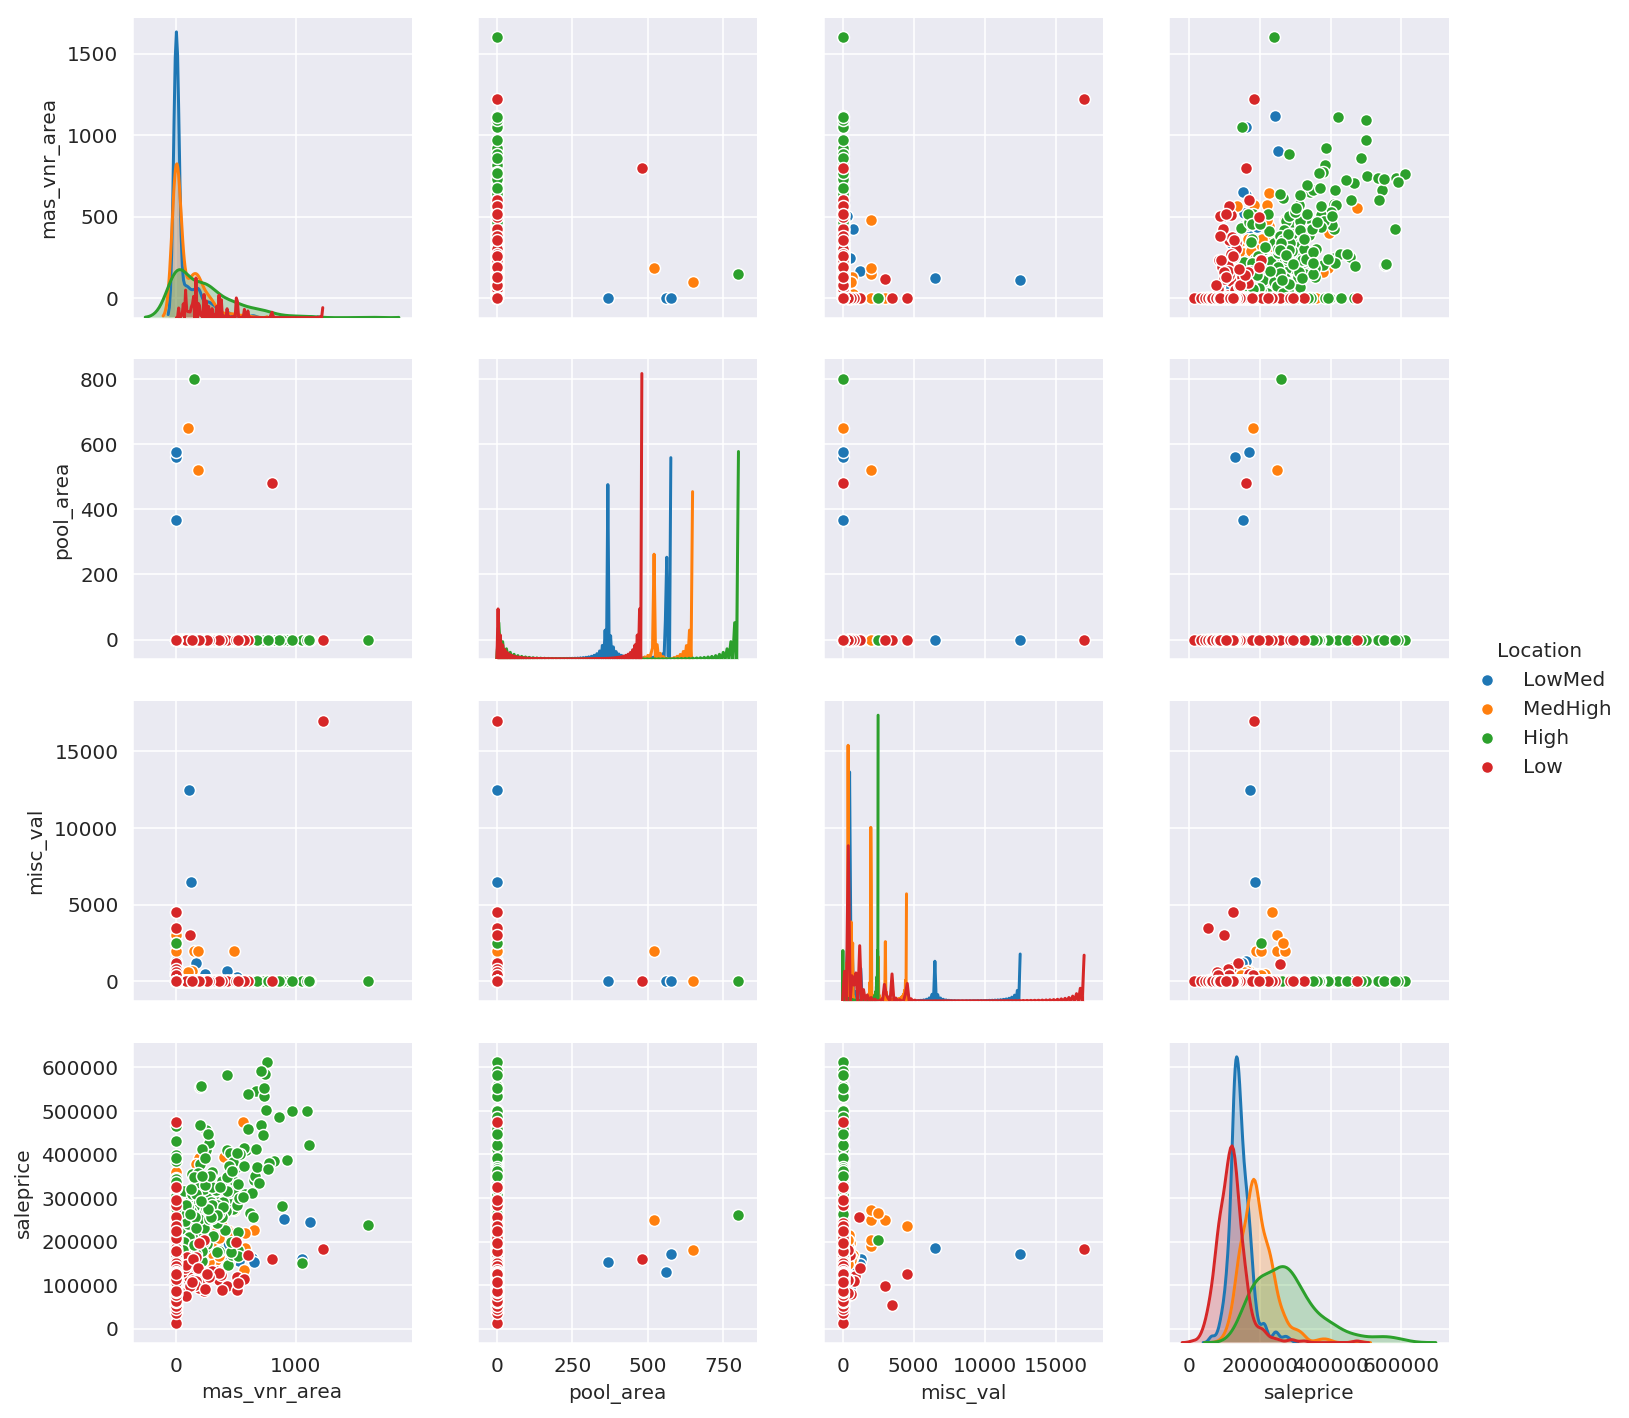

In [28]:
sns.pairplot(data = ames_train,
             vars = ['mas_vnr_area','pool_area','misc_val','saleprice'],
             hue = 'Location');

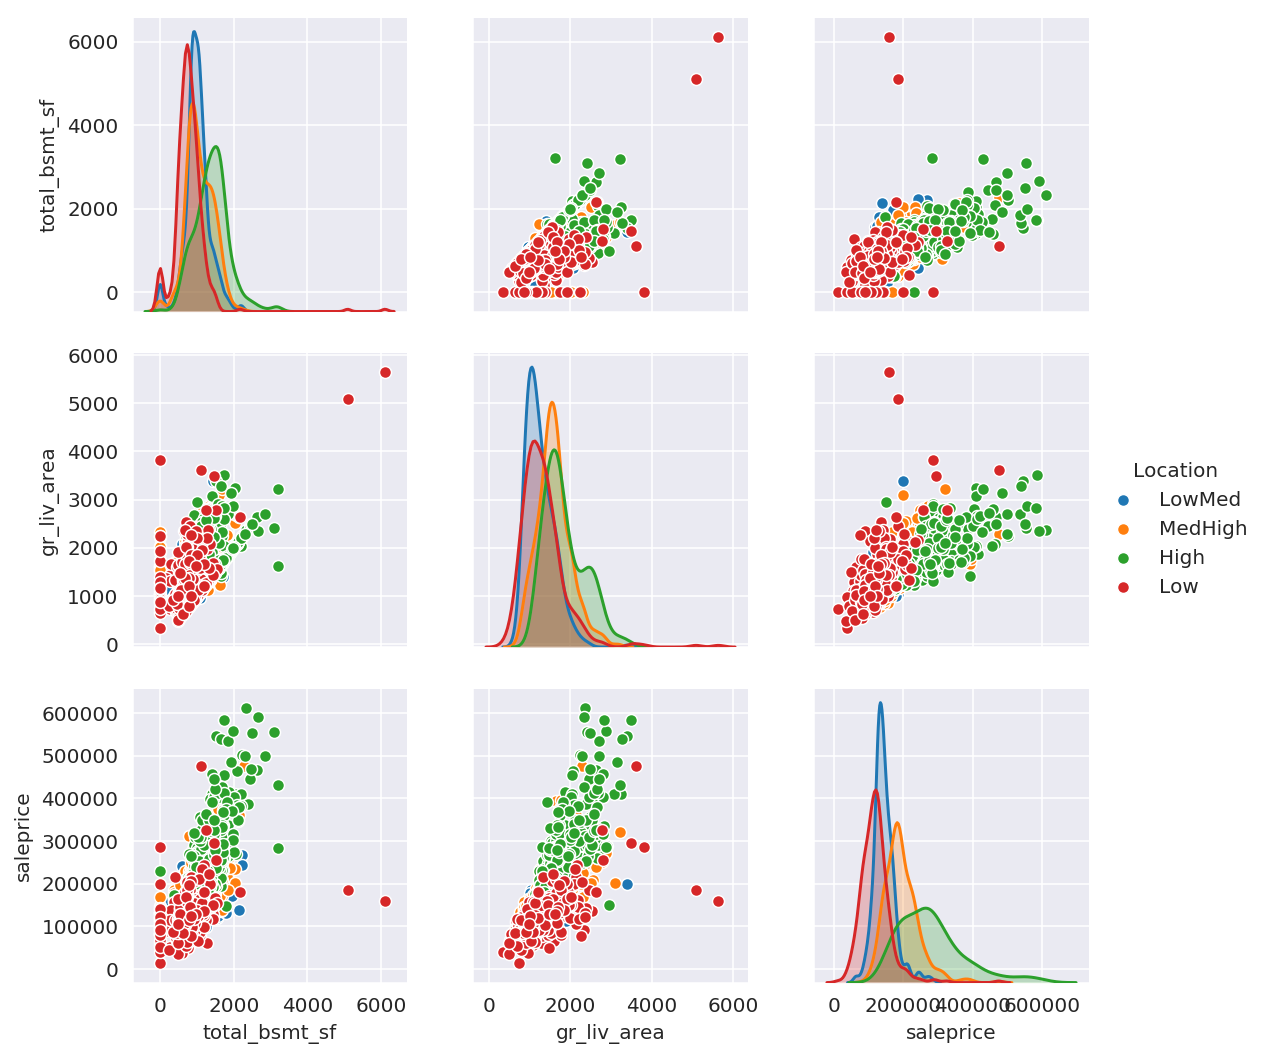

In [29]:
sns.pairplot(data = ames_train,
             vars = ['total_bsmt_sf','gr_liv_area','saleprice'],
             hue = 'Location');

# Heatmaps

### Another view into correlation. Taking the visualization a step further by looking at the strength of the relationships described above.

In [30]:
# Create objects to store the groups of variables I want to see heatmaps for
heatmap_grp_1 = ames_train[['lot_area','overall_qual','overall_cond','1st_flr_sf','2nd_flr_sf','garage_area','gr_liv_area','saleprice']].corr()
heatmap_grp_2 = ames_train[['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf','mas_vnr_area','pool_area','misc_val','saleprice']].corr()
heatmap_grp_3 = ames_train[['wood_deck_sf','open_porch_sf','enclosed_porch','3ssn_porch','screen_porch','saleprice']].corr()
heatmap_grp_4 = ames_train[['year_built','year_remod/add','garage_yr_blt','yr_sold','saleprice']].corr()


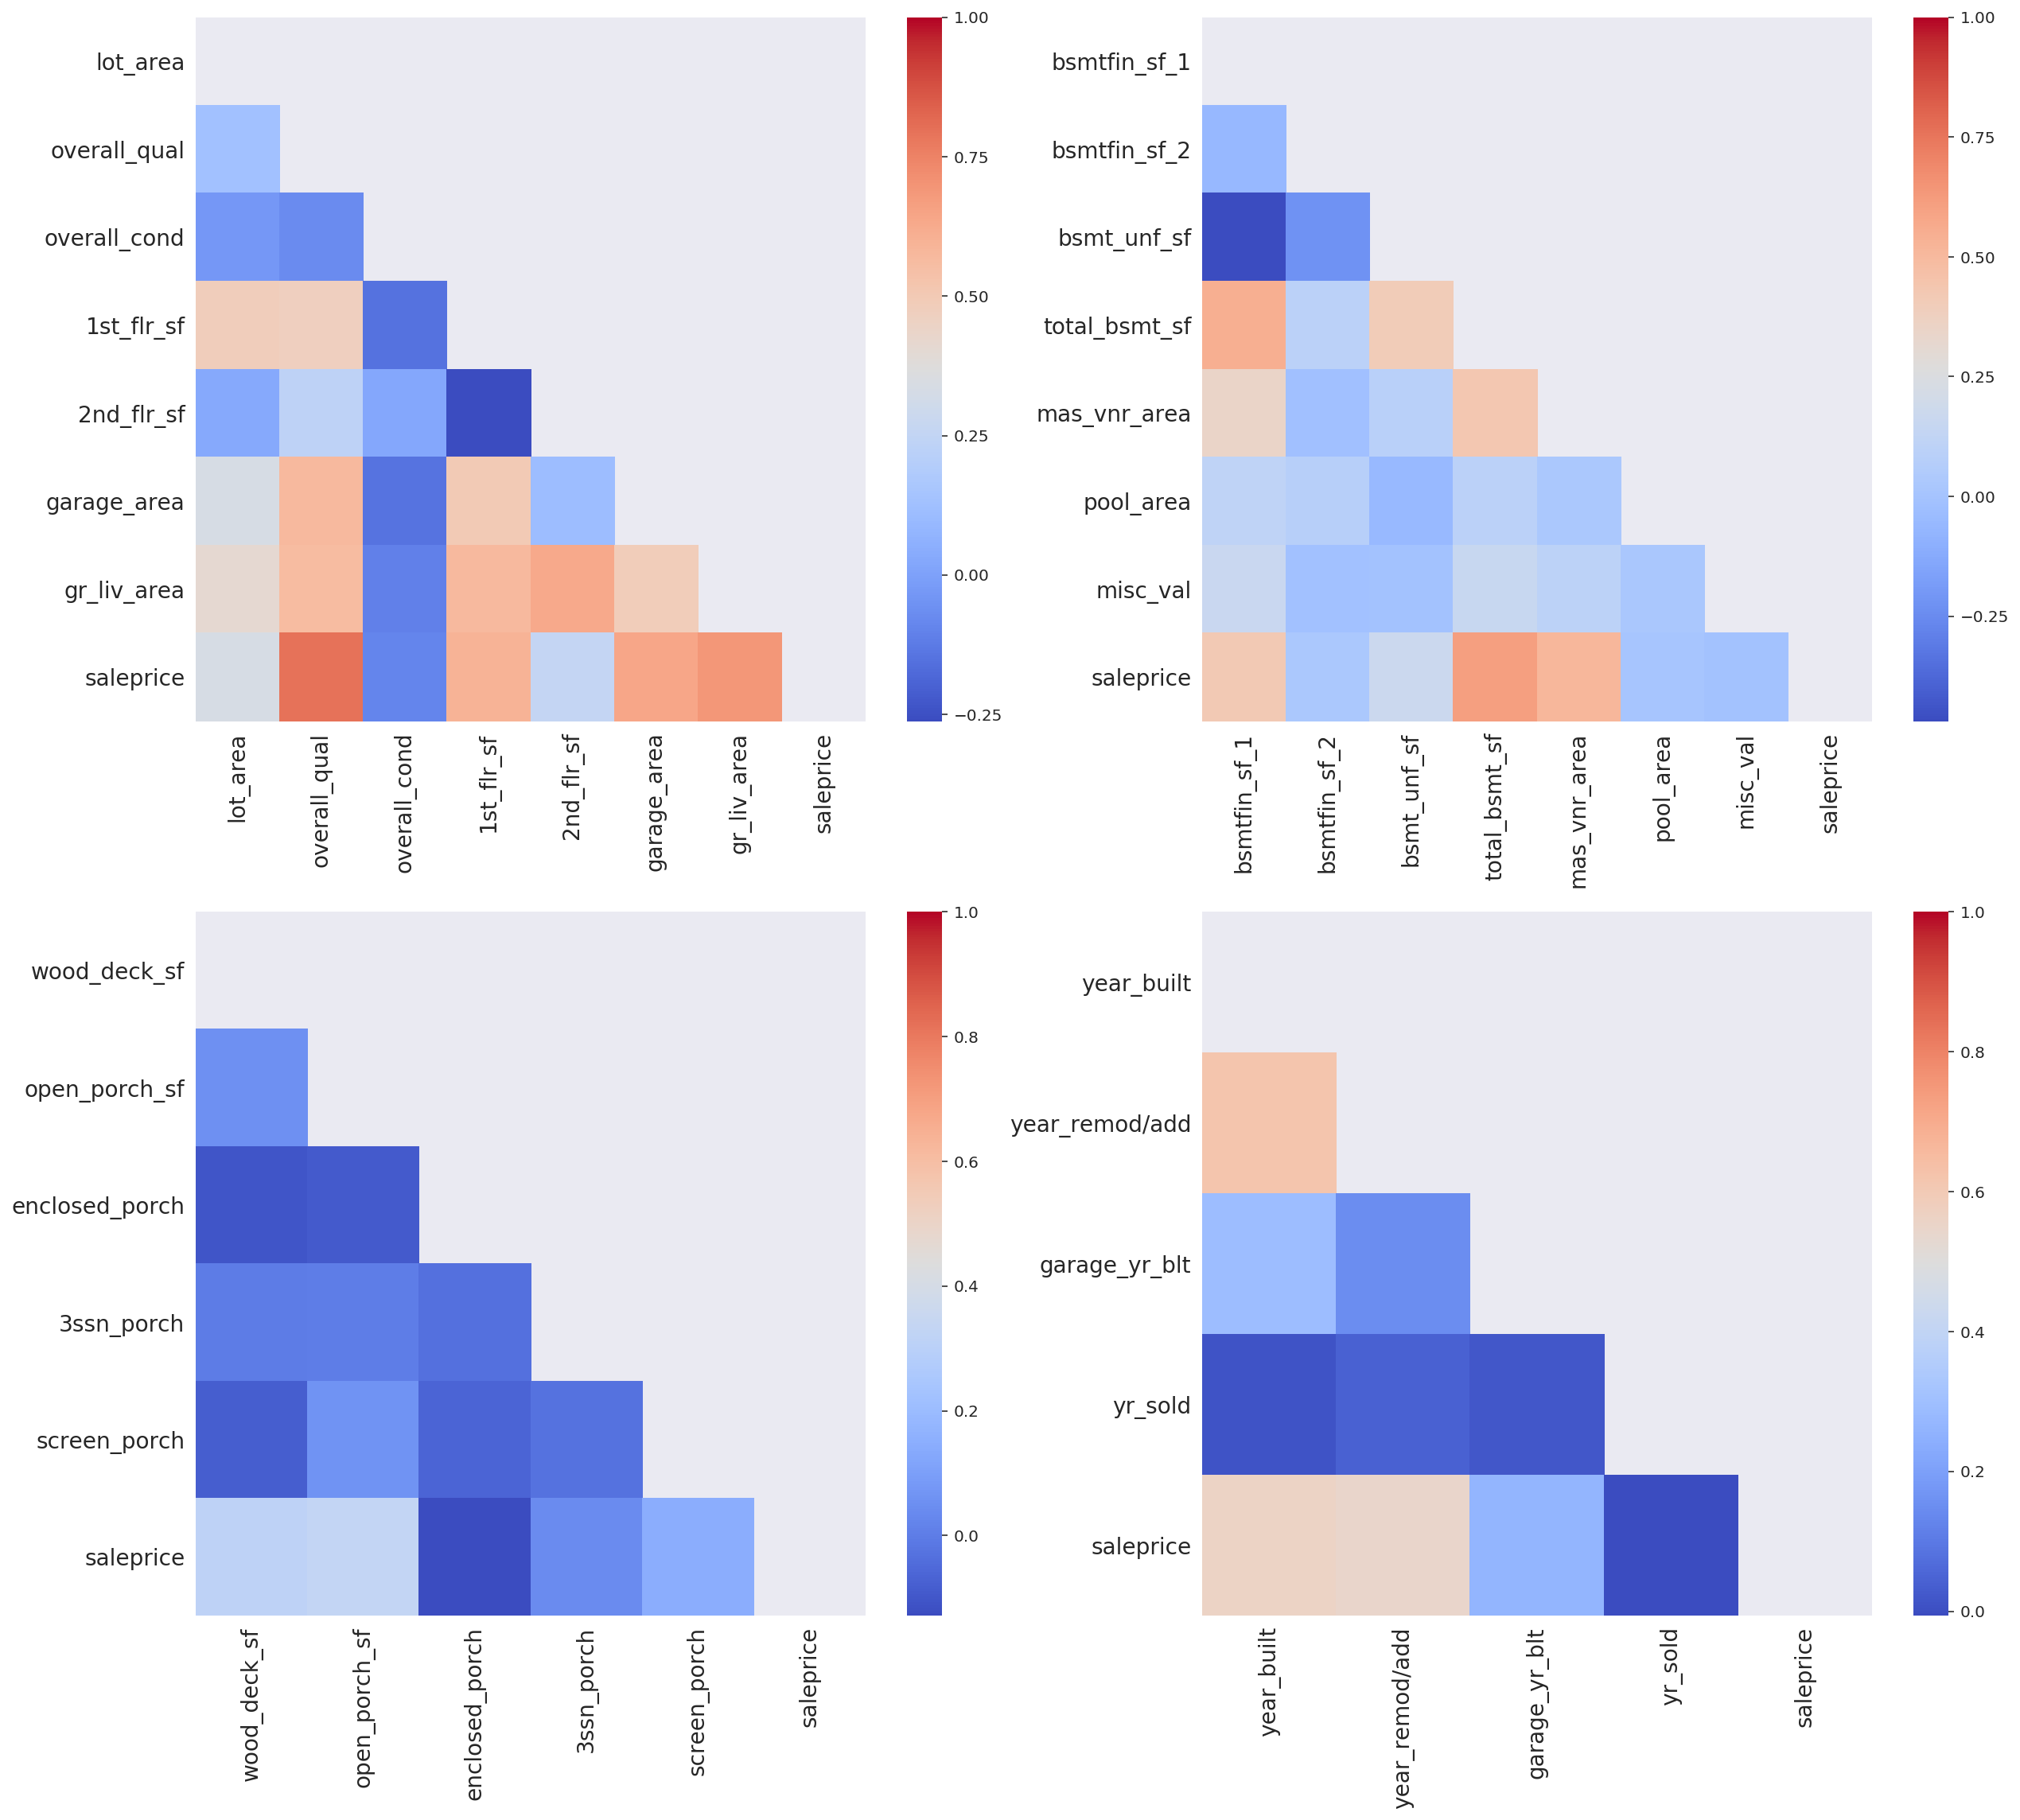

In [31]:
# create a figure with four axes objects
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize = (18,16), nrows = 2, ncols = 2)

# First: create heatmap subplot for group 1; assign it to ax1

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(heatmap_grp_1, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the seaborn heatmap to the matplotlib axis.
ax1 = sns.heatmap(heatmap_grp_1, mask = mask, ax = ax1, cmap = 'coolwarm')

# Resize the labels.
ax1.set_xticklabels(ax1.xaxis.get_ticklabels(), fontsize = 14)
ax1.set_yticklabels(ax1.yaxis.get_ticklabels(), fontsize = 14)

# Now repeat the process for group 2; assign it to ax2

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(heatmap_grp_2, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn, assign it to ax2
ax2 = sns.heatmap(heatmap_grp_2, mask = mask, ax = ax2, cmap = 'coolwarm')

# Resize the labels.
ax2.set_xticklabels(ax2.xaxis.get_ticklabels(), fontsize = 14)
ax2.set_yticklabels(ax2.yaxis.get_ticklabels(), fontsize = 14)

# Now repeat for group 3...

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(heatmap_grp_3, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot with seaborn, apply to axis, resize labels
ax3 = sns.heatmap(heatmap_grp_3, mask = mask, ax = ax3, cmap = 'coolwarm')
ax3.set_xticklabels(ax3.xaxis.get_ticklabels(), fontsize = 14)
ax3.set_yticklabels(ax3.yaxis.get_ticklabels(), fontsize = 14)

# Finally, do the same thing for group 4:

mask = np.zeros_like(heatmap_grp_4, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
ax4 = sns.heatmap(heatmap_grp_4, mask = mask, ax = ax4, cmap = 'coolwarm')
ax4.set_xticklabels(ax4.xaxis.get_ticklabels(), fontsize = 14)
ax4.set_yticklabels(ax4.yaxis.get_ticklabels(), fontsize = 14)

# tight_layout() and show() - to ensure a clean output
plt.tight_layout()
plt.show()

# Boxplots

### For categorical variables, I want to see how the target variable is distributed in each category.

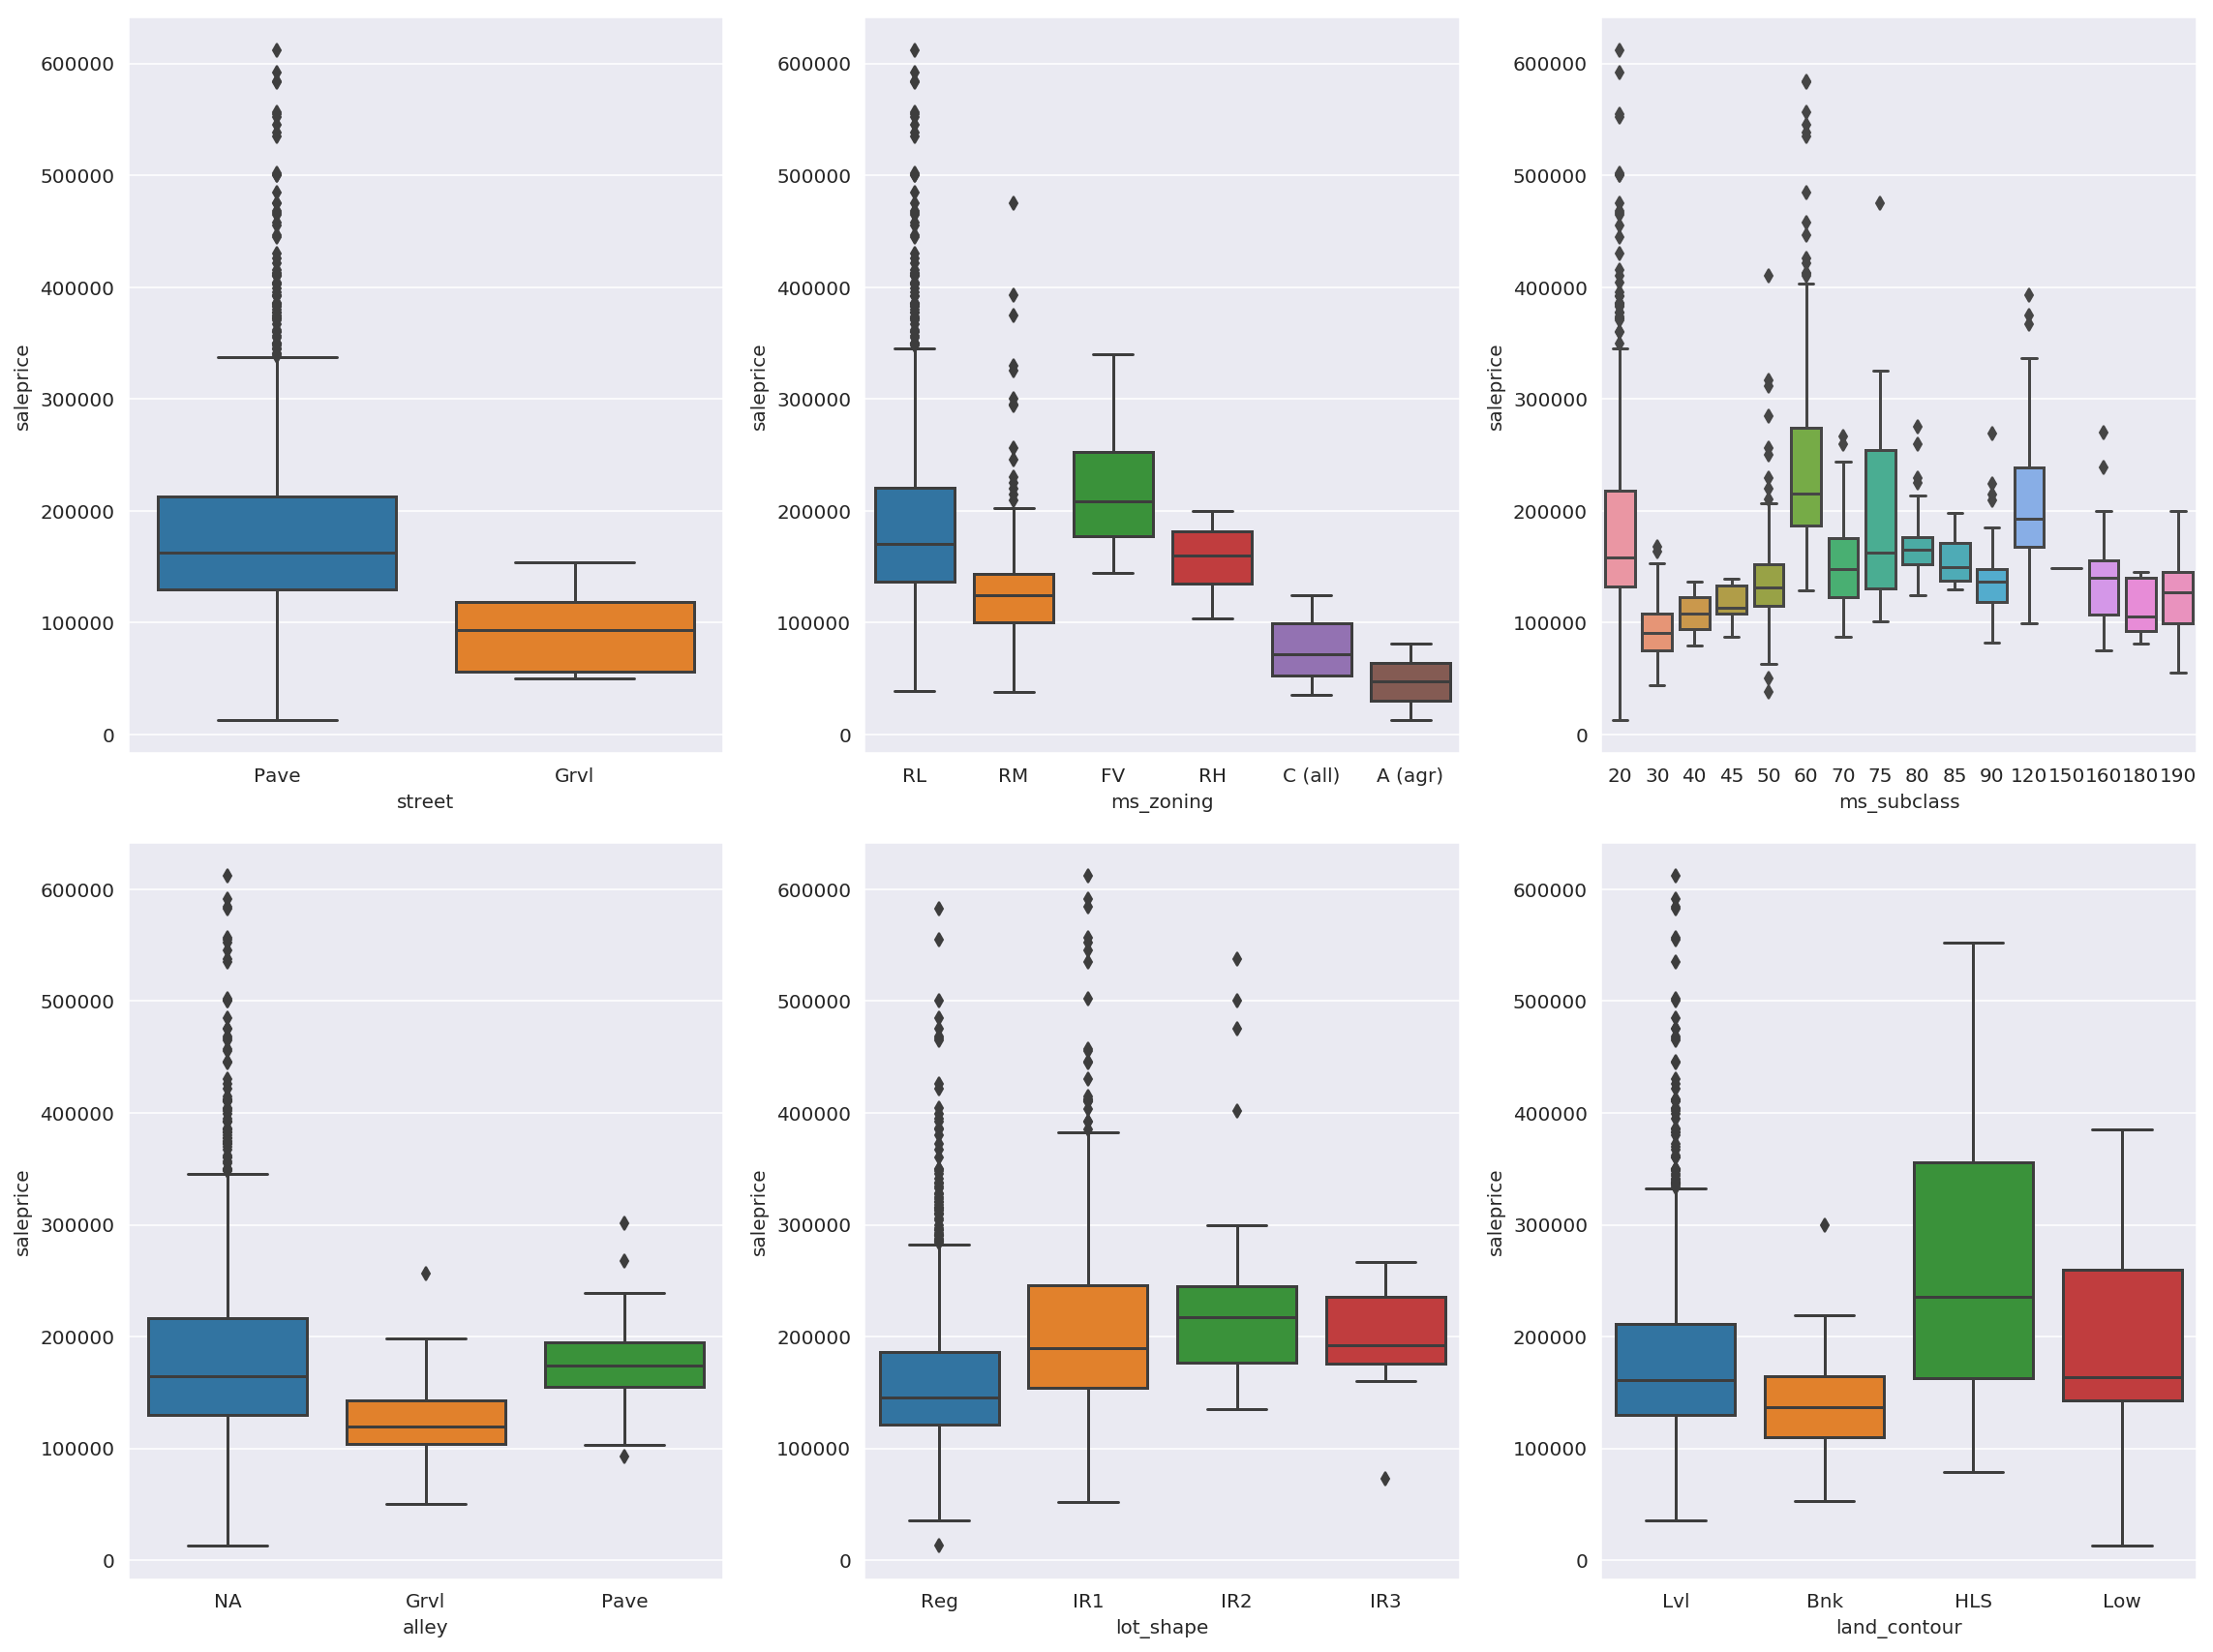

In [32]:
fig, ax = plt.subplots(figsize =(16,12), nrows = 2, ncols = 3)

sns.boxplot(x = 'street', y = 'saleprice', data = ames_train, ax = ax[0][0])
sns.boxplot(x = 'ms_zoning', y = 'saleprice', data = ames_train, ax = ax[0][1])
sns.boxplot(x = 'ms_subclass', y = 'saleprice', data = ames_train, ax = ax[0][2])
sns.boxplot(x = 'alley', y = 'saleprice', data = ames_train, ax = ax[1][0])
sns.boxplot(x = 'lot_shape', y = 'saleprice', data = ames_train, ax = ax[1][1])
sns.boxplot(x = 'land_contour', y = 'saleprice', data = ames_train, ax = ax[1][2])

plt.tight_layout();

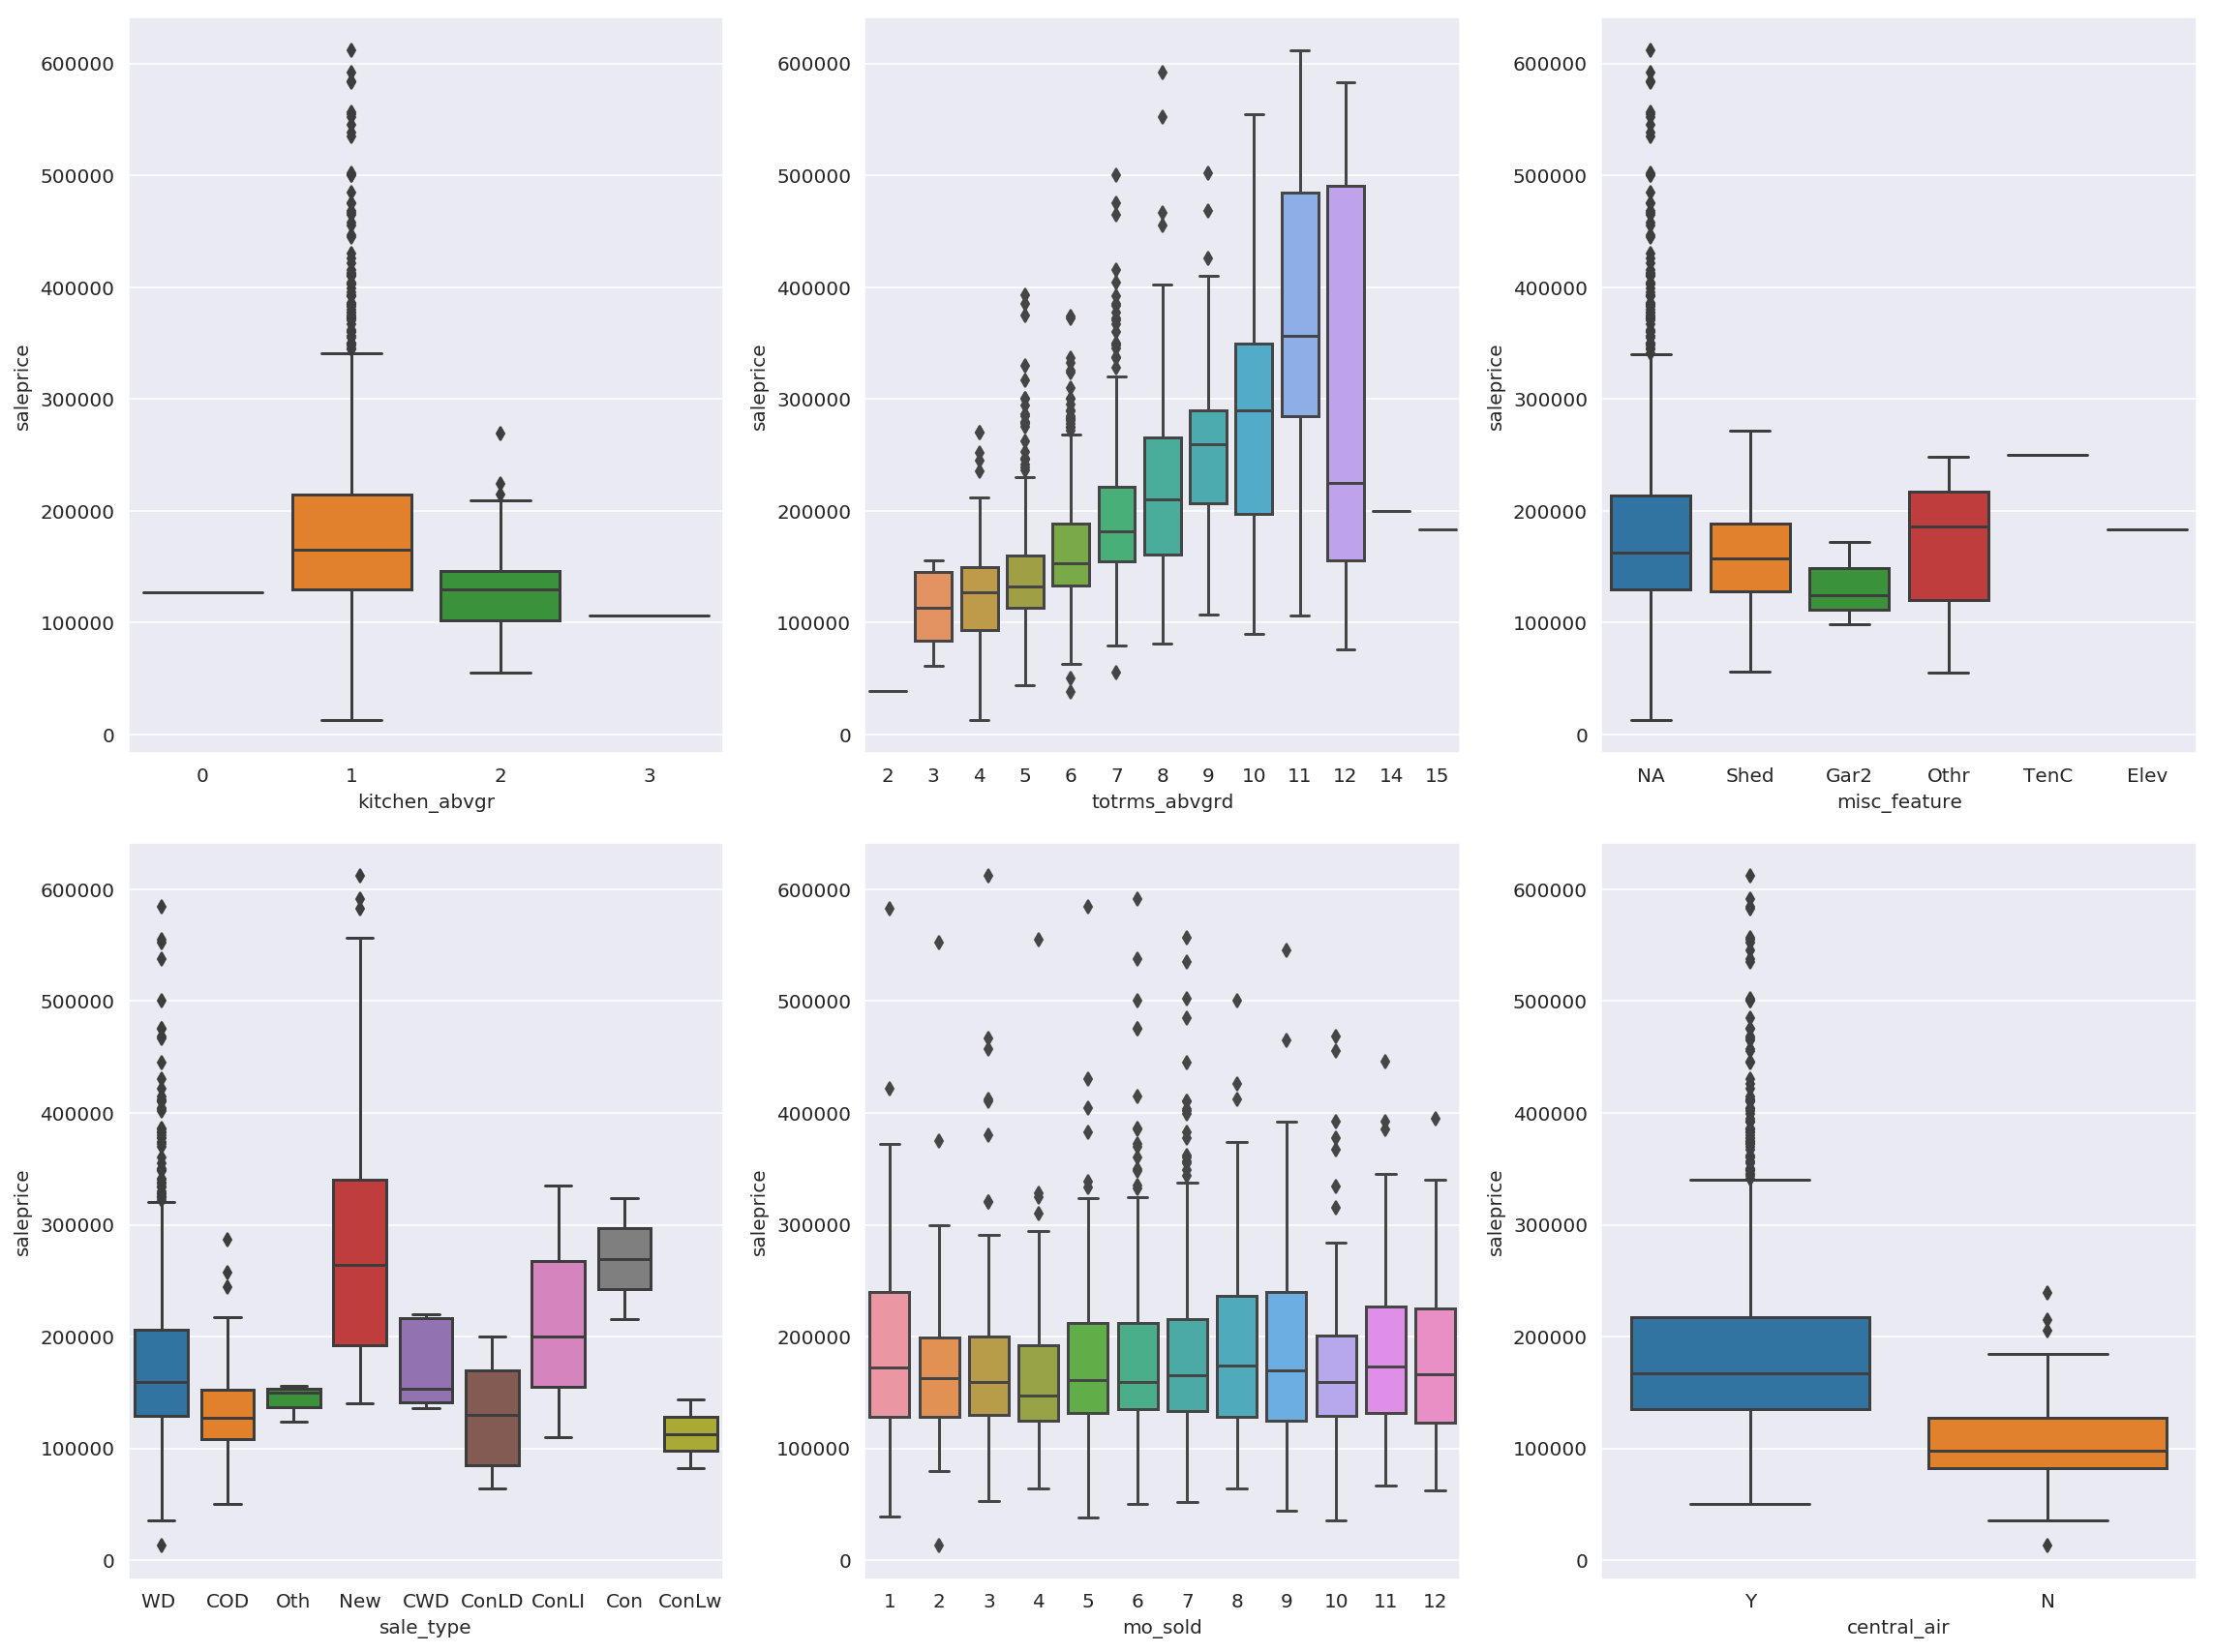

In [28]:
fig, ax = plt.subplots(figsize =(16,12), nrows = 2, ncols = 3)

sns.boxplot(x = 'kitchen_abvgr', y = 'saleprice', data = ames_train, ax = ax[0][0])
sns.boxplot(x = 'totrms_abvgrd', y = 'saleprice', data = ames_train, ax = ax[0][1])
sns.boxplot(x = 'misc_feature', y = 'saleprice', data = ames_train, ax = ax[0][2])
sns.boxplot(x = 'sale_type', y = 'saleprice', data = ames_train, ax = ax[1][0])
sns.boxplot(x = 'mo_sold', y = 'saleprice', data = ames_train, ax = ax[1][1])
sns.boxplot(x = 'central_air', y = 'saleprice', data = ames_train, ax = ax[1][2])

plt.tight_layout();

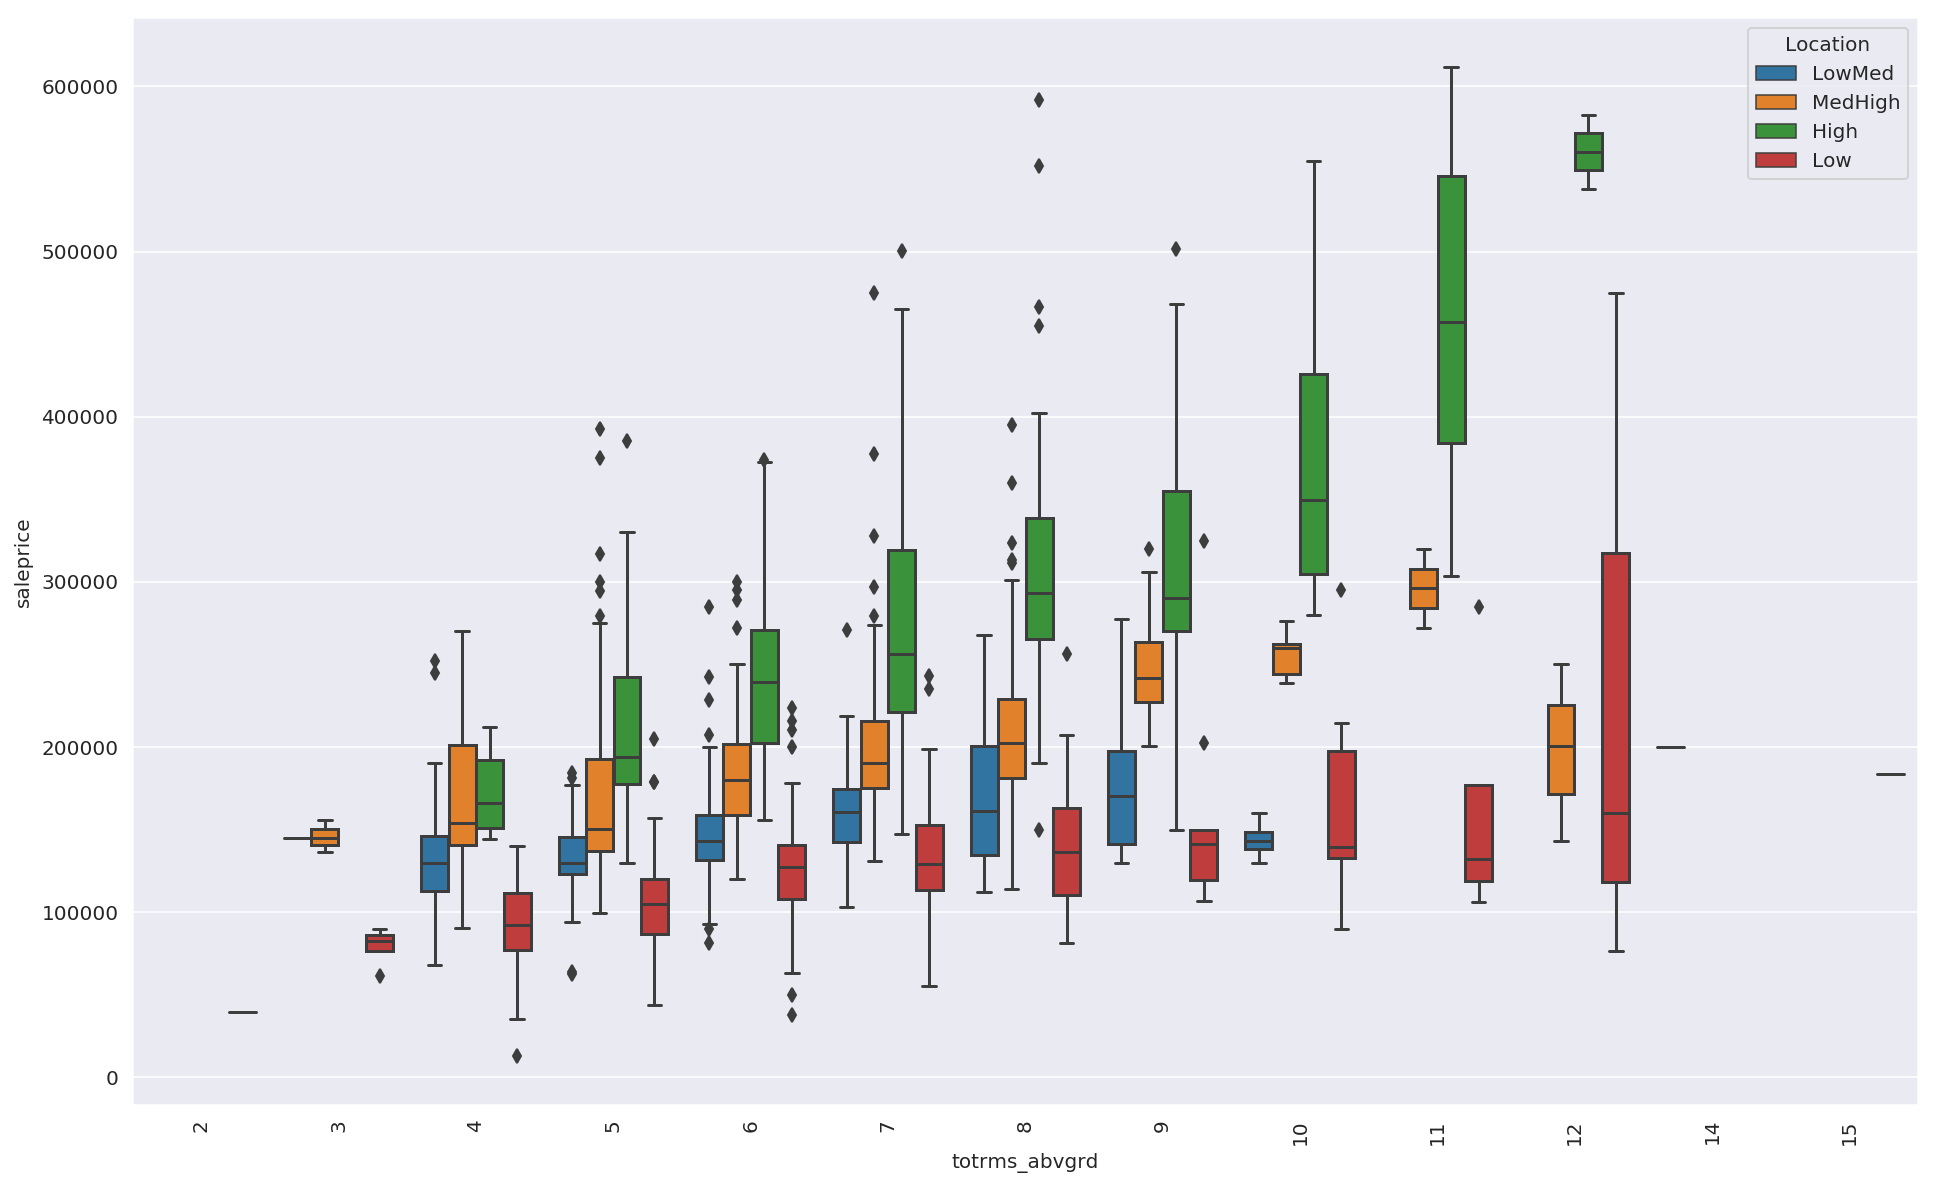

In [44]:
figure, ax = plt.subplots(figsize = (16, 10))
plt.xticks(rotation = 90)
sns.boxplot(x = 'totrms_abvgrd', y = 'saleprice', hue = 'Location', data = ames_train, ax = ax);

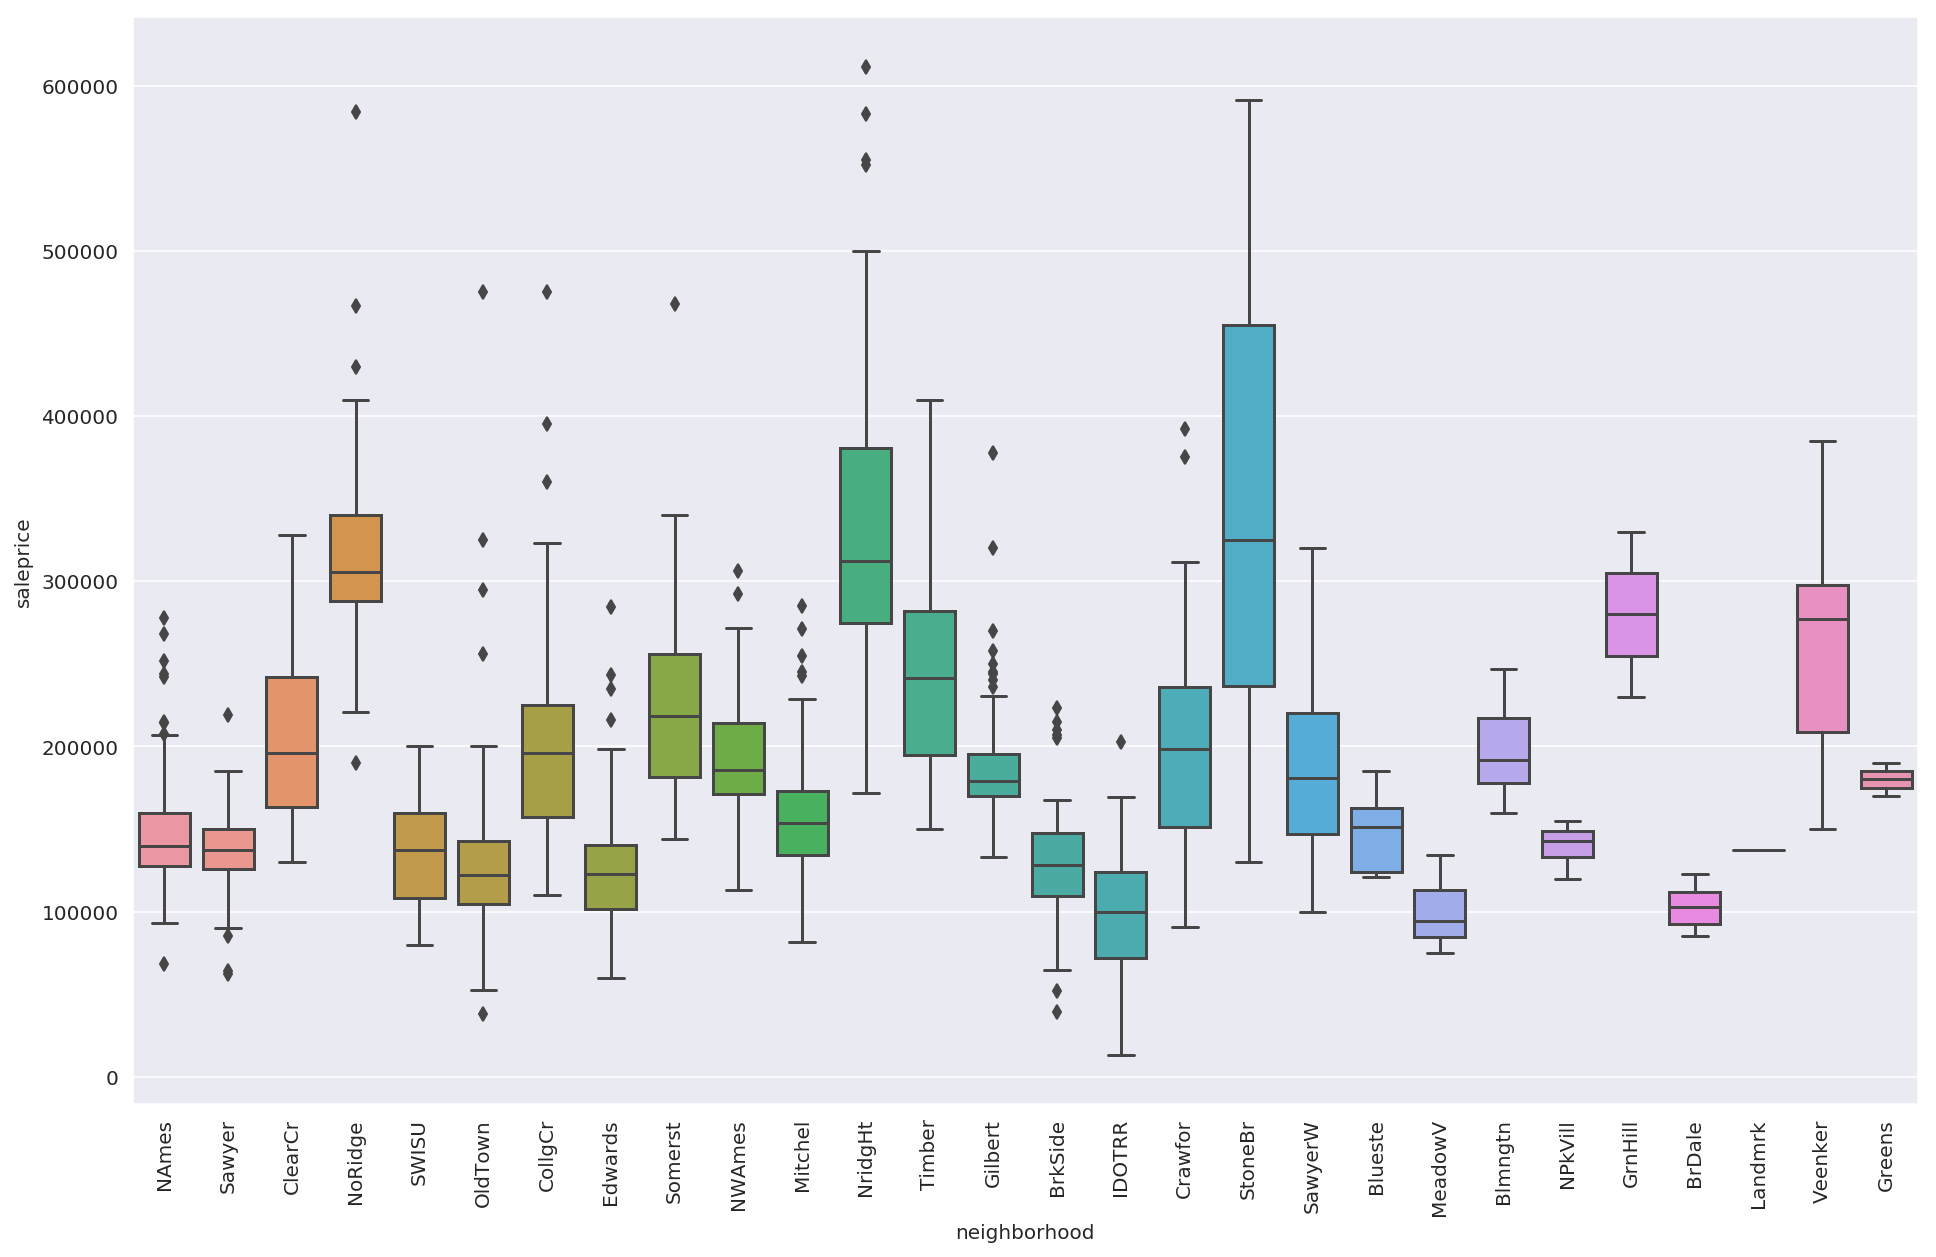

In [29]:
figure, ax = plt.subplots(figsize = (16, 10))
plt.xticks(rotation = 90)
sns.boxplot(x = 'neighborhood', y = 'saleprice', data = ames_train, ax = ax);

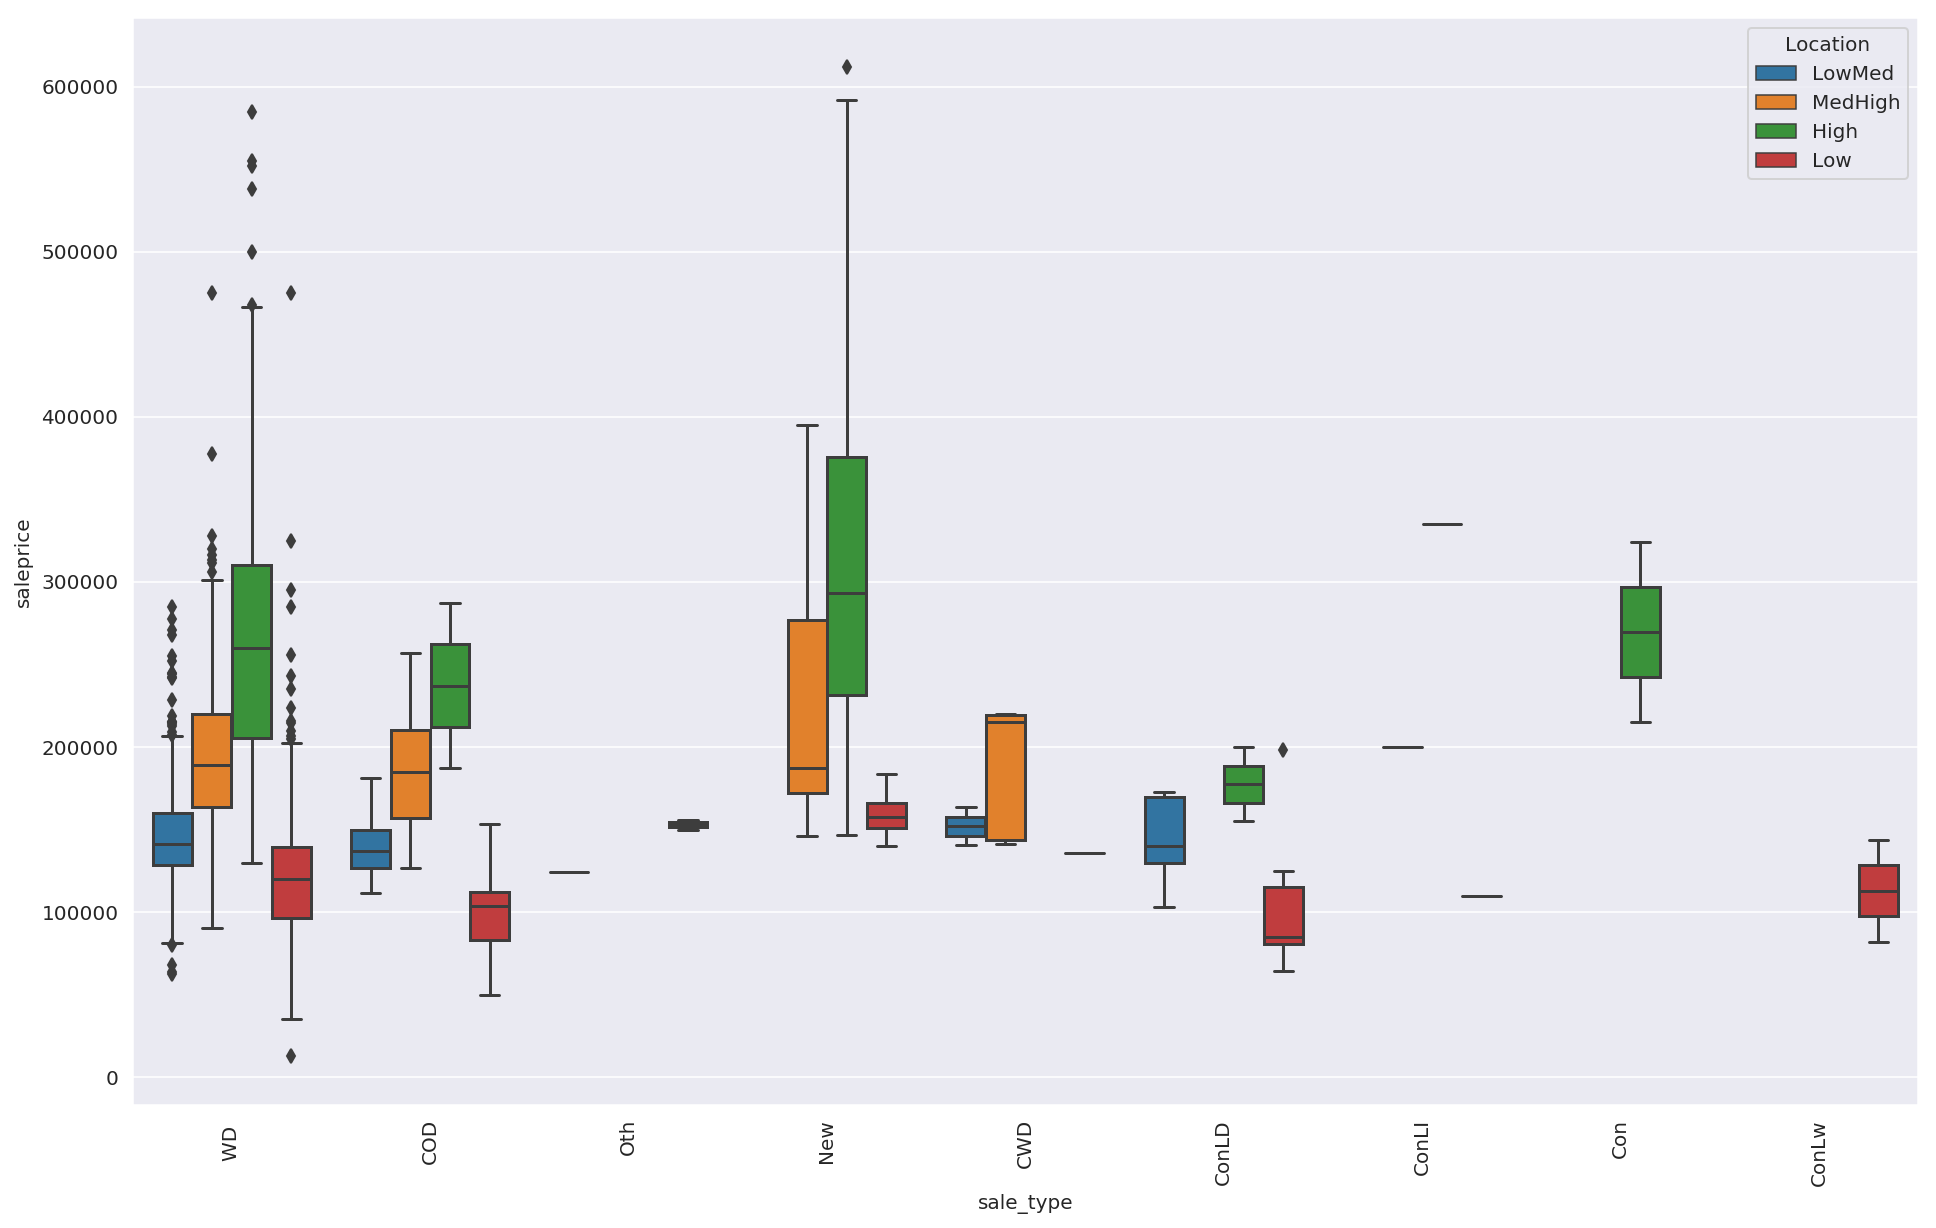

In [46]:
figure, ax = plt.subplots(figsize = (16, 10))
plt.xticks(rotation = 90)
sns.boxplot(x = 'sale_type', y = 'saleprice', hue = 'Location', data = ames_train, ax = ax);

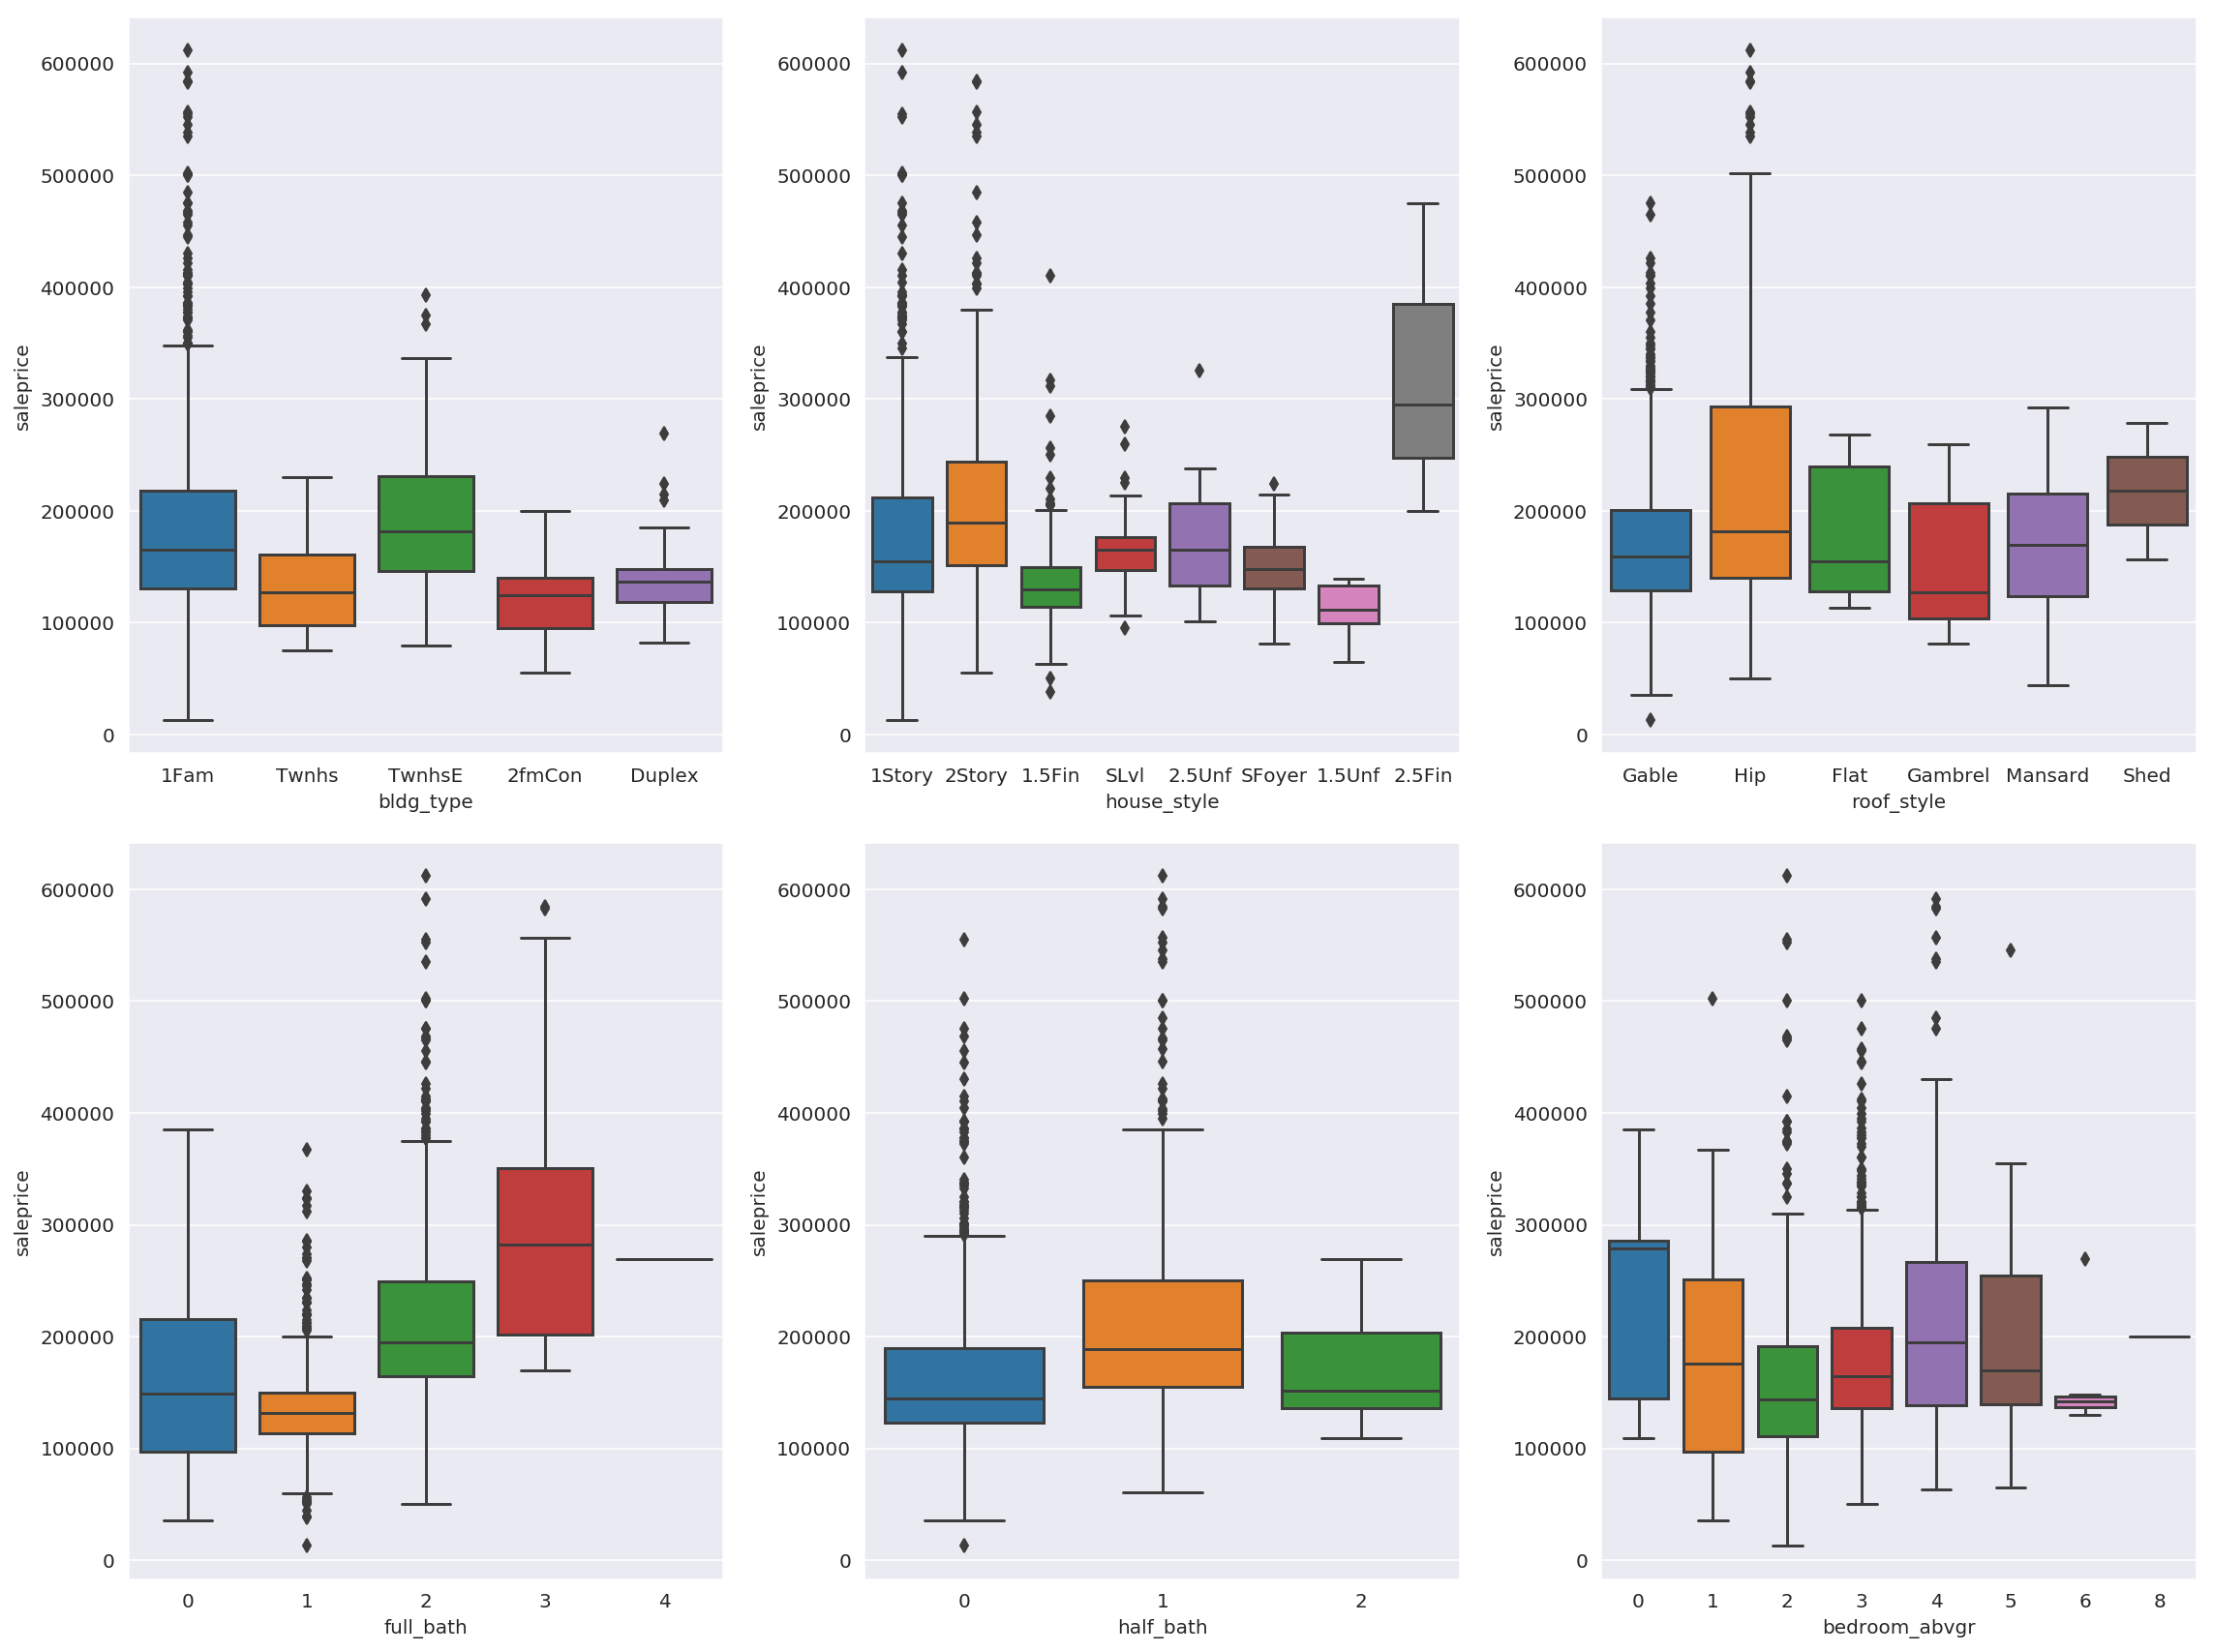

In [31]:
fig, ax = plt.subplots(figsize =(16,12), nrows = 2, ncols = 3)

sns.boxplot(x = 'bldg_type', y = 'saleprice', data = ames_train, ax = ax[0][0])
sns.boxplot(x = 'house_style', y = 'saleprice', data = ames_train, ax = ax[0][1])
sns.boxplot(x = 'roof_style', y = 'saleprice', data = ames_train, ax = ax[0][2])
sns.boxplot(x = 'full_bath', y = 'saleprice', data = ames_train, ax = ax[1][0])
sns.boxplot(x = 'half_bath', y = 'saleprice', data = ames_train, ax = ax[1][1])
sns.boxplot(x = 'bedroom_abvgr', y = 'saleprice', data = ames_train, ax = ax[1][2])

plt.tight_layout();

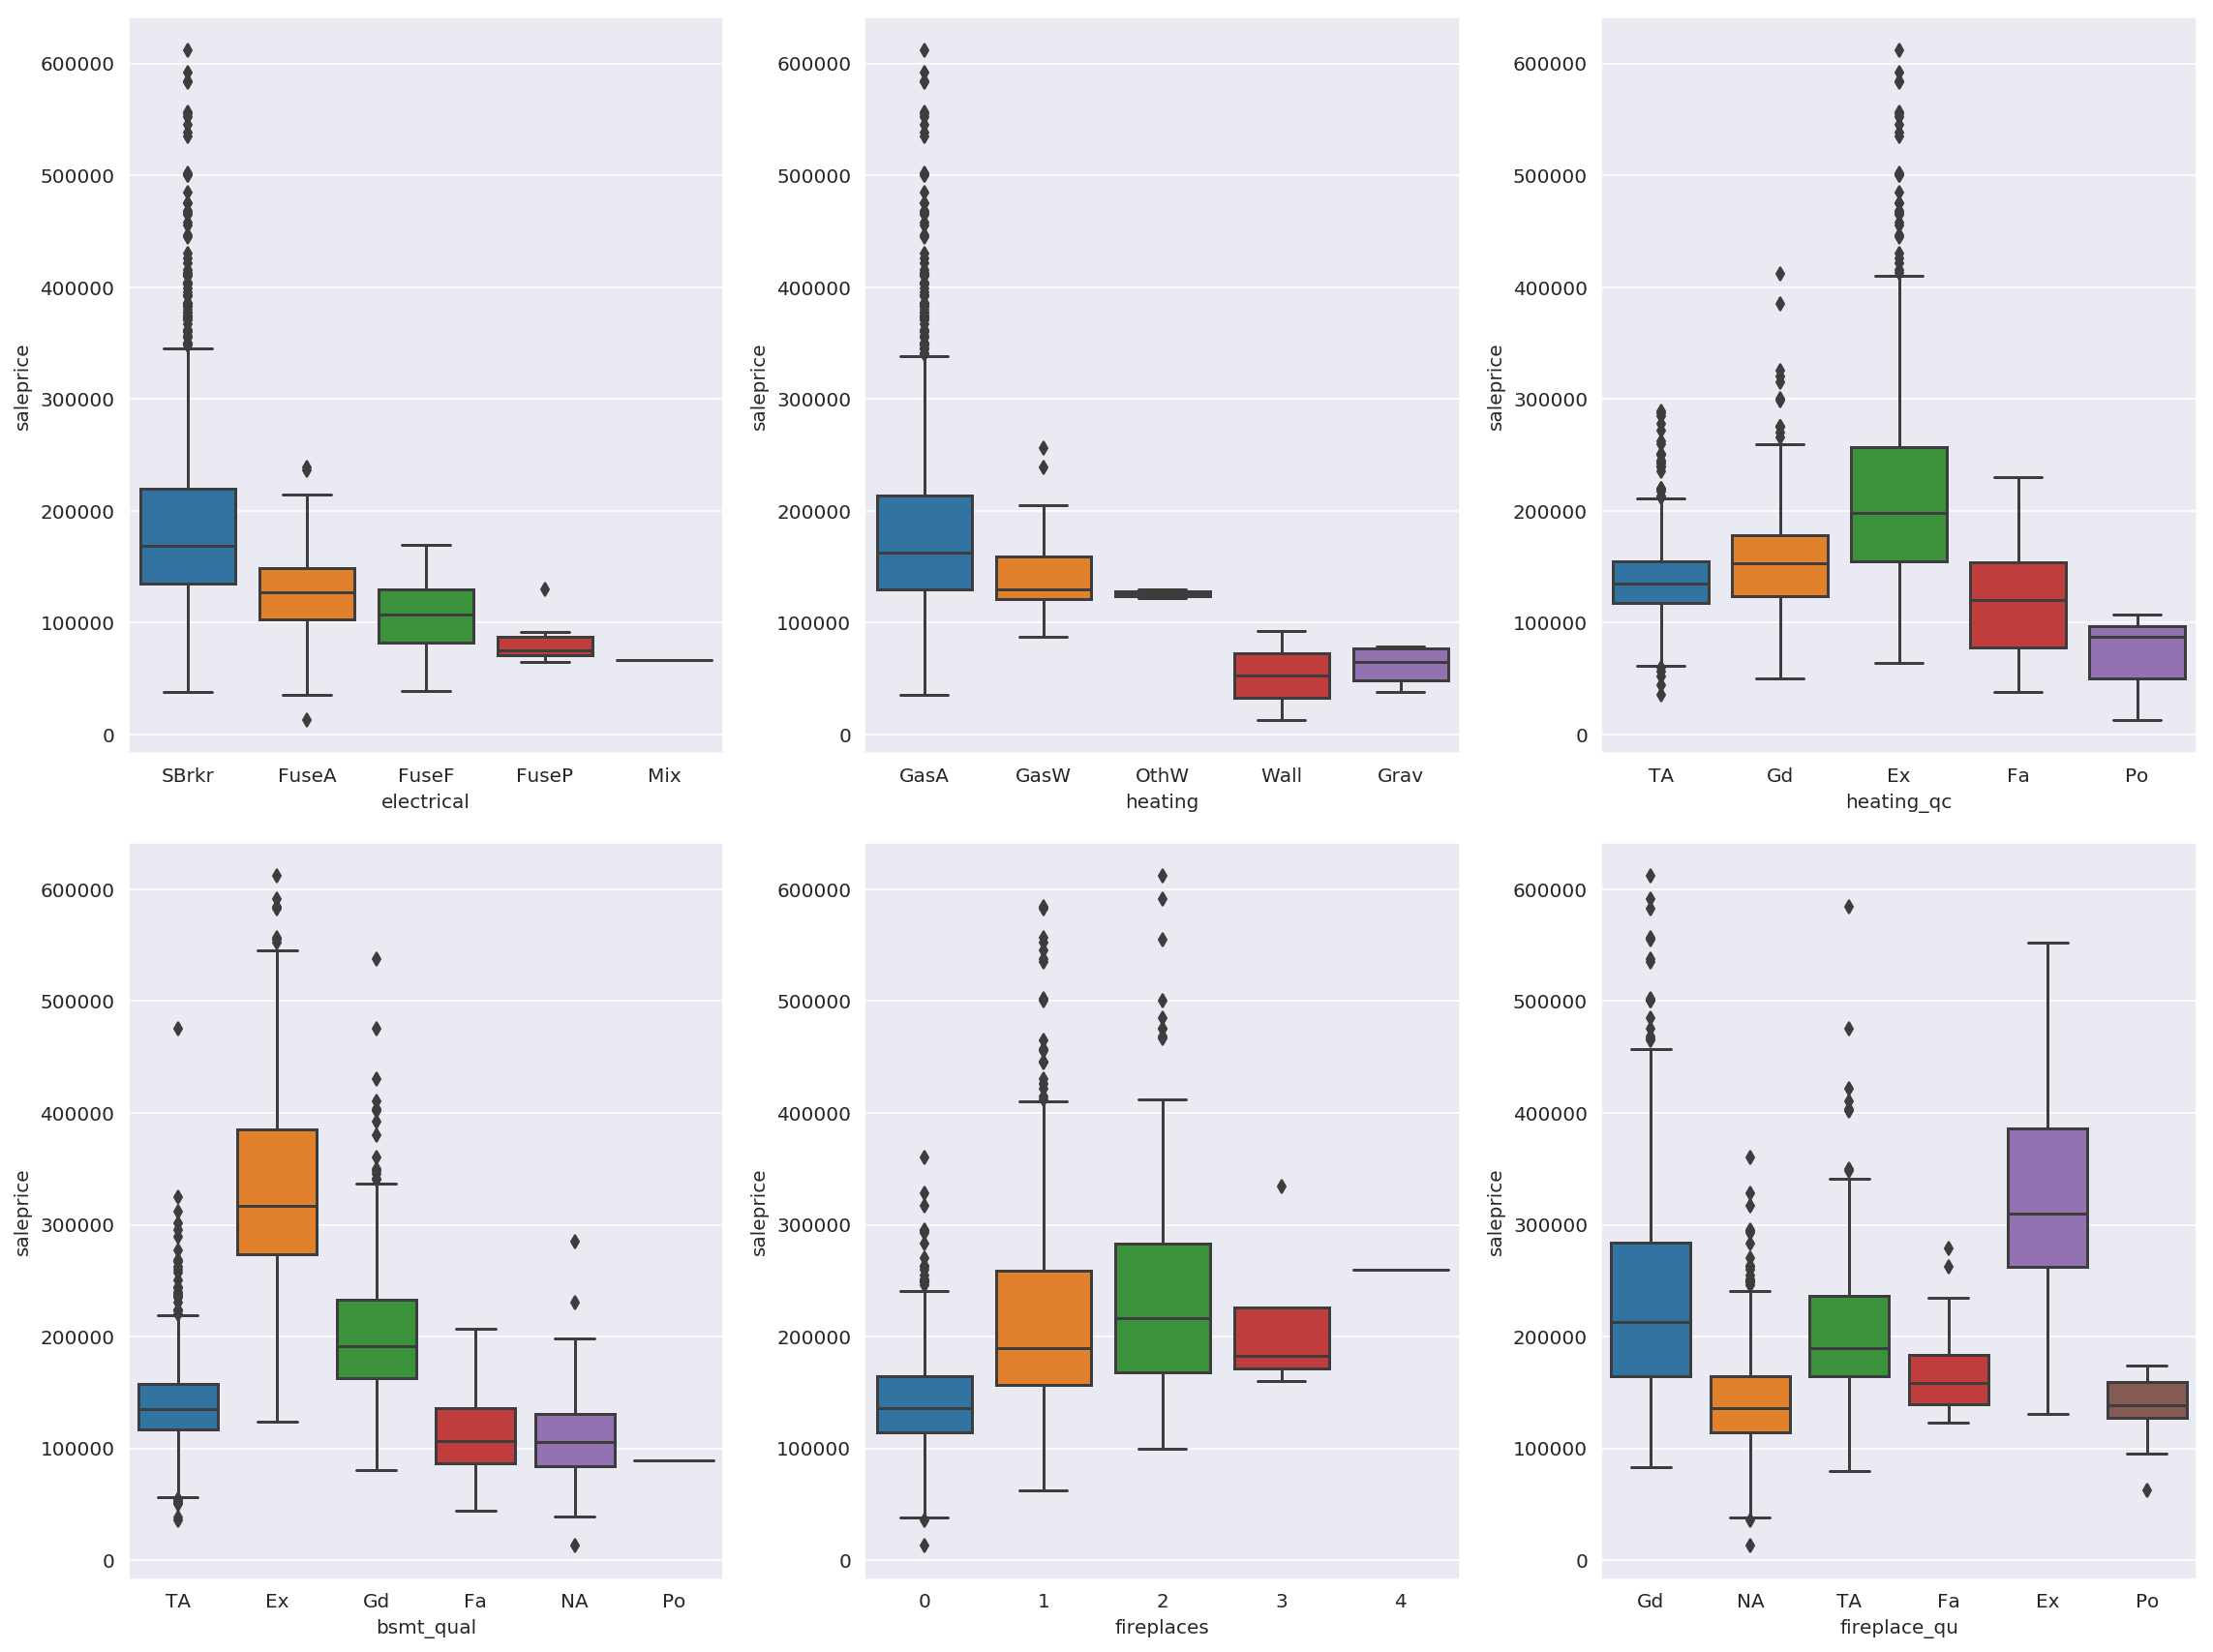

In [32]:
fig, ax = plt.subplots(figsize =(16,12), nrows = 2, ncols = 3)

sns.boxplot(x = 'electrical', y = 'saleprice', data = ames_train, ax = ax[0][0])
sns.boxplot(x = 'heating', y = 'saleprice', data = ames_train, ax = ax[0][1])
sns.boxplot(x = 'heating_qc', y = 'saleprice', data = ames_train, ax = ax[0][2])
sns.boxplot(x = 'bsmt_qual', y = 'saleprice', data = ames_train, ax = ax[1][0])
sns.boxplot(x = 'fireplaces', y = 'saleprice', data = ames_train, ax = ax[1][1])
sns.boxplot(x = 'fireplace_qu', y = 'saleprice', data = ames_train, ax = ax[1][2])

plt.tight_layout();

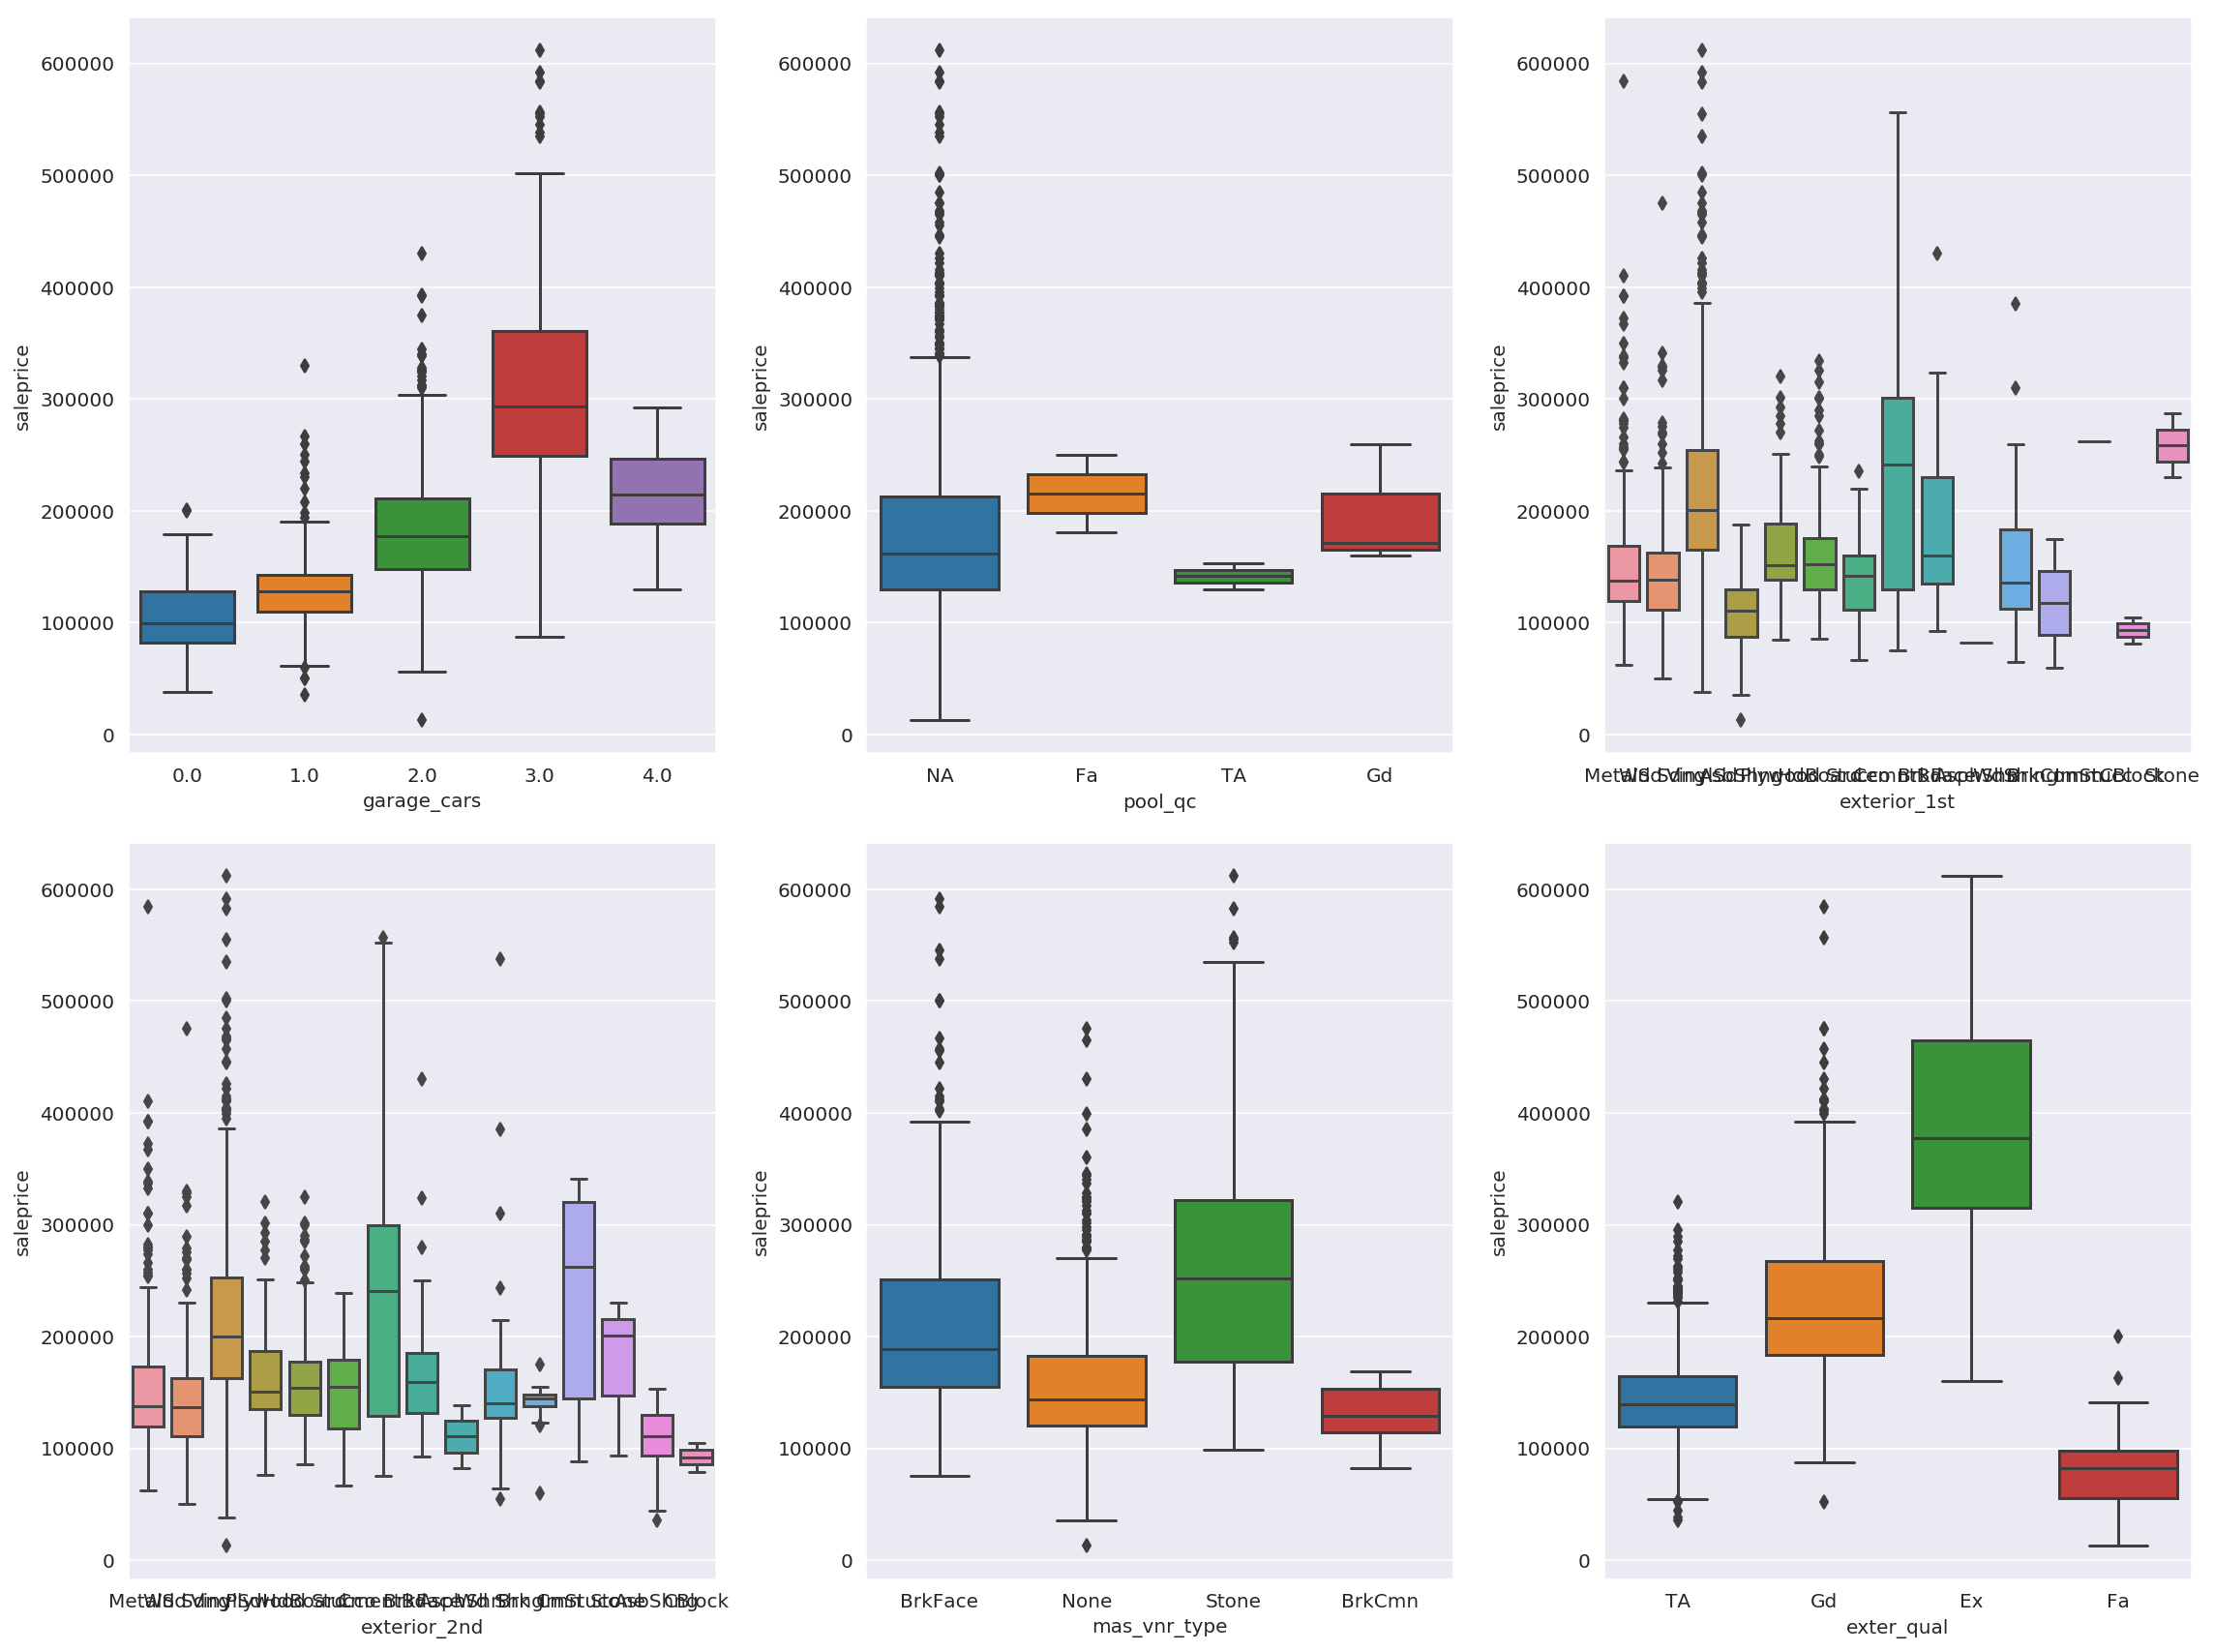

In [33]:
fig, ax = plt.subplots(figsize =(16,12), nrows = 2, ncols = 3)

sns.boxplot(x = 'garage_cars', y = 'saleprice', data = ames_train, ax = ax[0][0])
sns.boxplot(x = 'pool_qc', y = 'saleprice', data = ames_train, ax = ax[0][1])
sns.boxplot(x = 'exterior_1st', y = 'saleprice', data = ames_train, ax = ax[0][2])
sns.boxplot(x = 'exterior_2nd', y = 'saleprice', data = ames_train, ax = ax[1][0])
sns.boxplot(x = 'mas_vnr_type', y = 'saleprice', data = ames_train, ax = ax[1][1])
sns.boxplot(x = 'exter_qual', y = 'saleprice', data = ames_train, ax = ax[1][2])

plt.tight_layout();

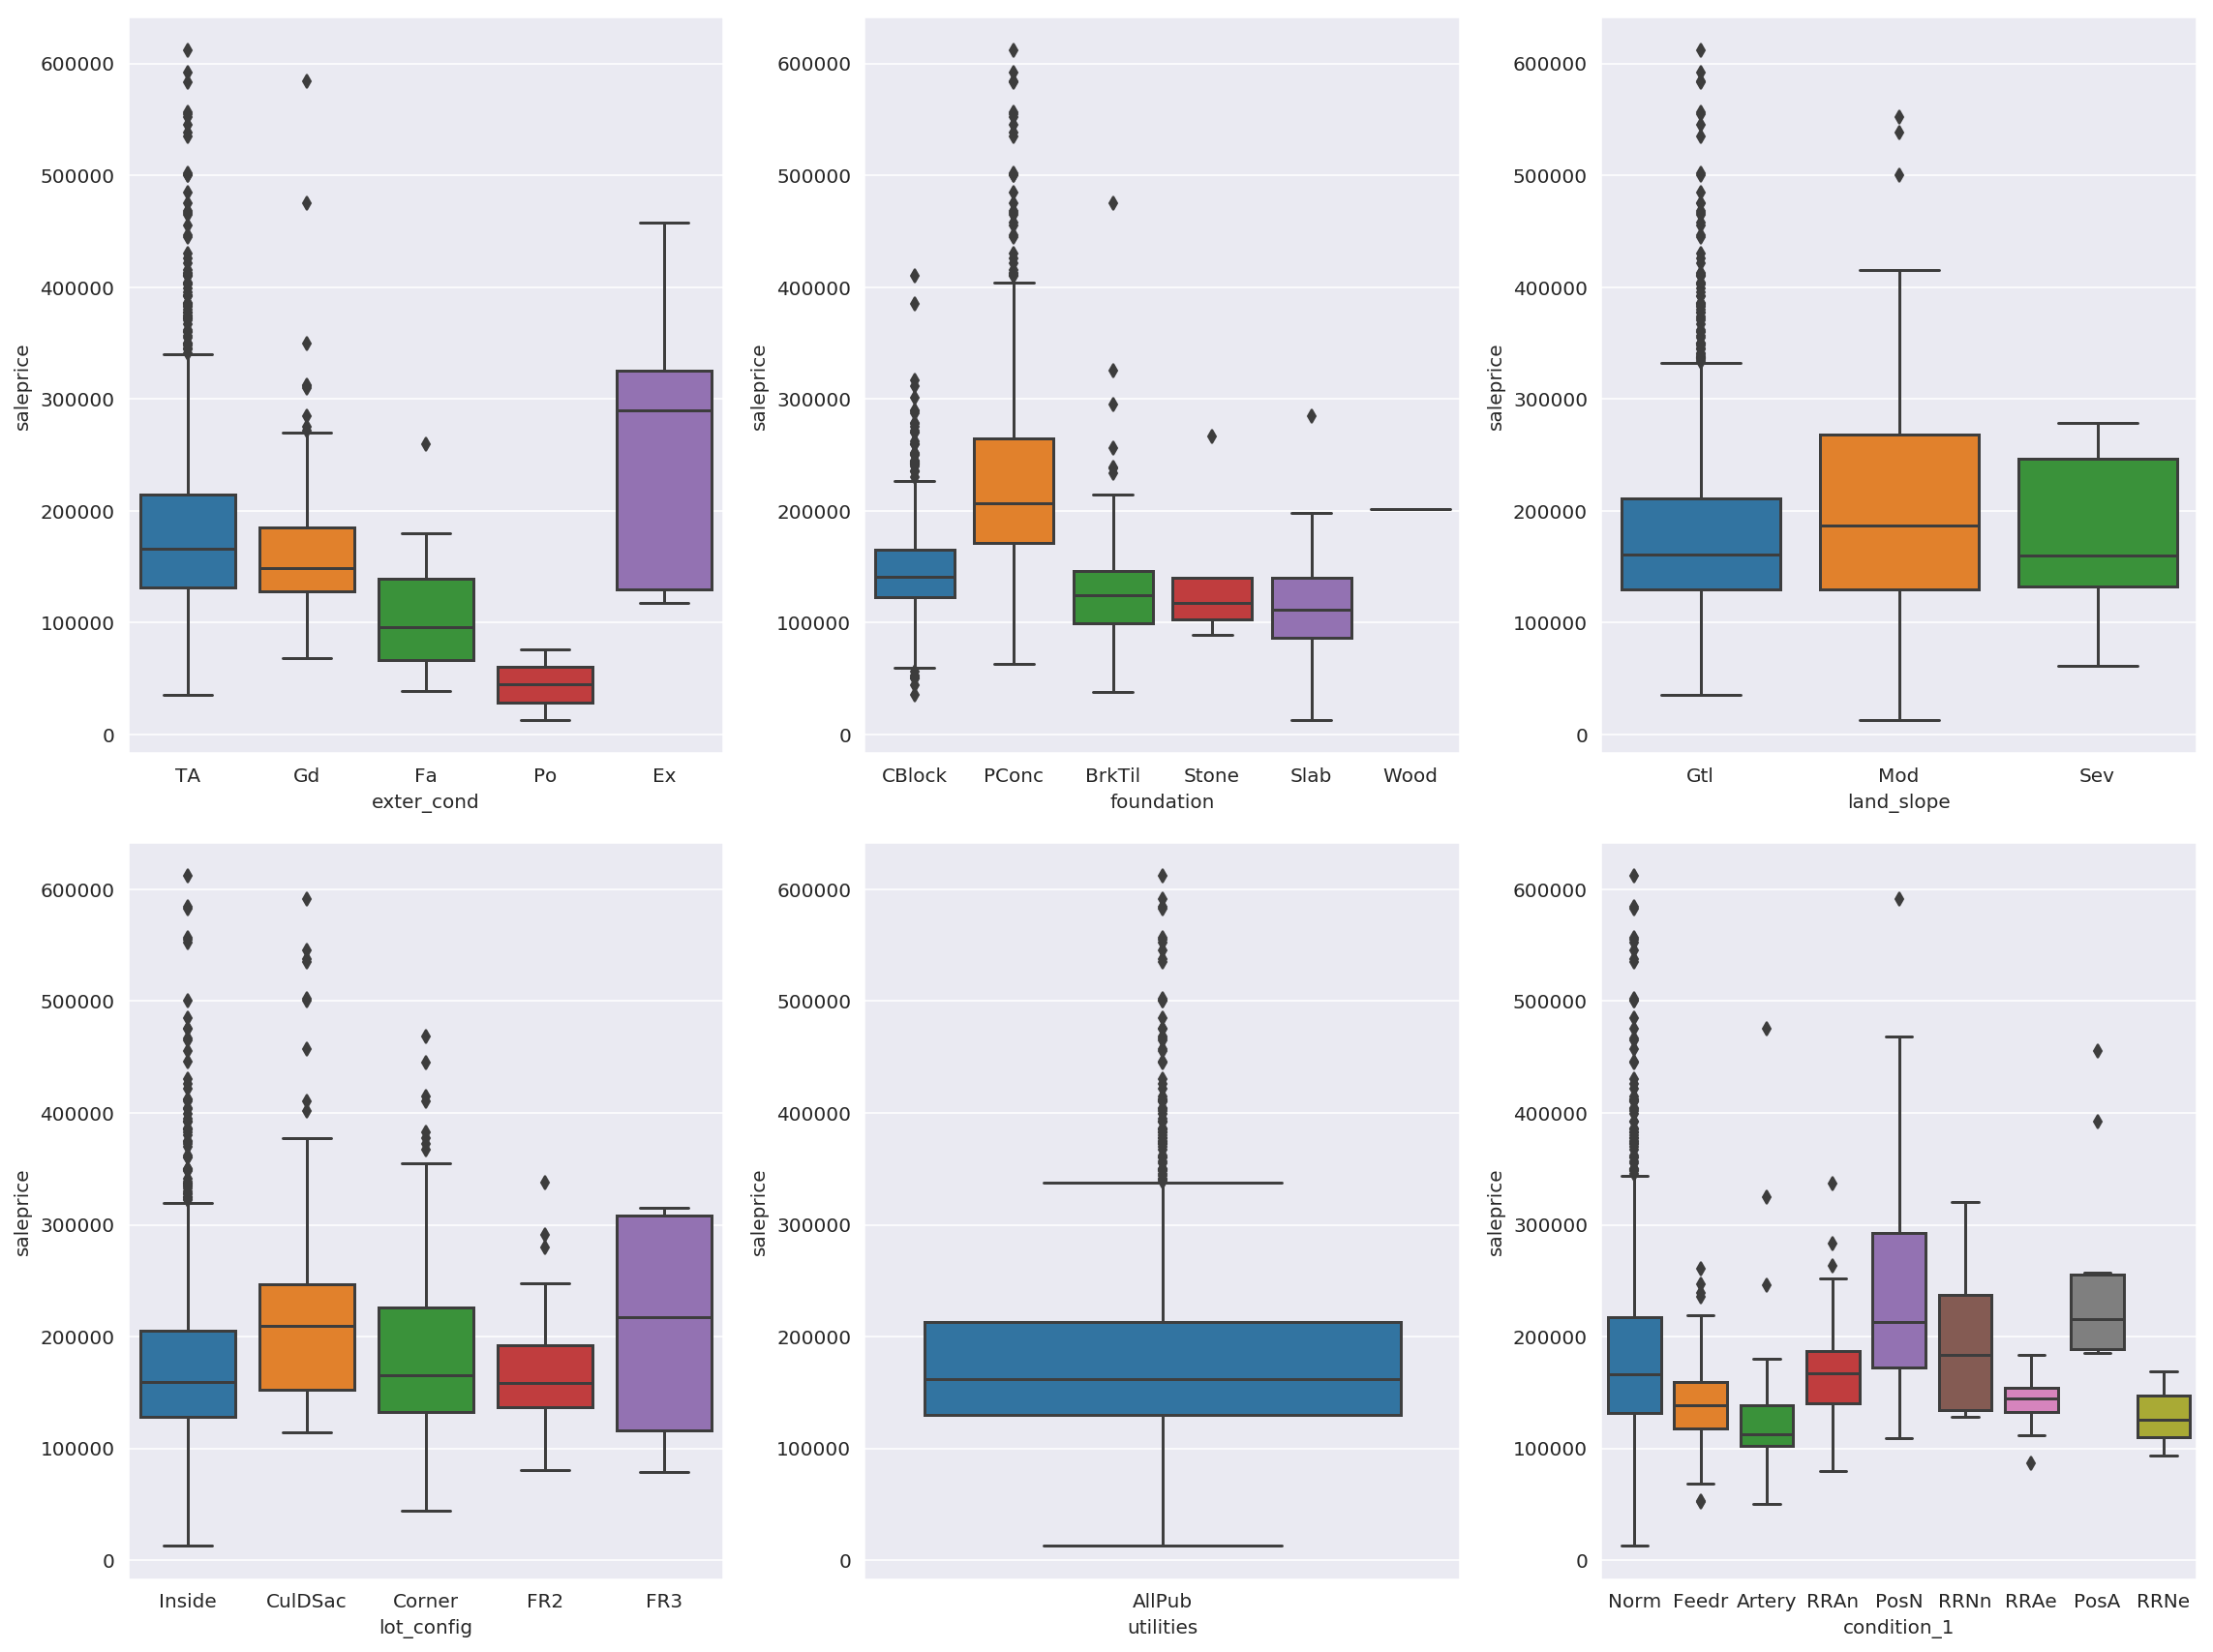

In [34]:
fig, ax = plt.subplots(figsize =(16,12), nrows = 2, ncols = 3)

sns.boxplot(x = 'exter_cond', y = 'saleprice', data = ames_train, ax = ax[0][0])
sns.boxplot(x = 'foundation', y = 'saleprice', data = ames_train, ax = ax[0][1])
sns.boxplot(x = 'land_slope', y = 'saleprice', data = ames_train, ax = ax[0][2])
sns.boxplot(x = 'lot_config', y = 'saleprice', data = ames_train, ax = ax[1][0])
sns.boxplot(x = 'utilities', y = 'saleprice', data = ames_train, ax = ax[1][1])
sns.boxplot(x = 'condition_1', y = 'saleprice', data = ames_train, ax = ax[1][2])

plt.tight_layout();

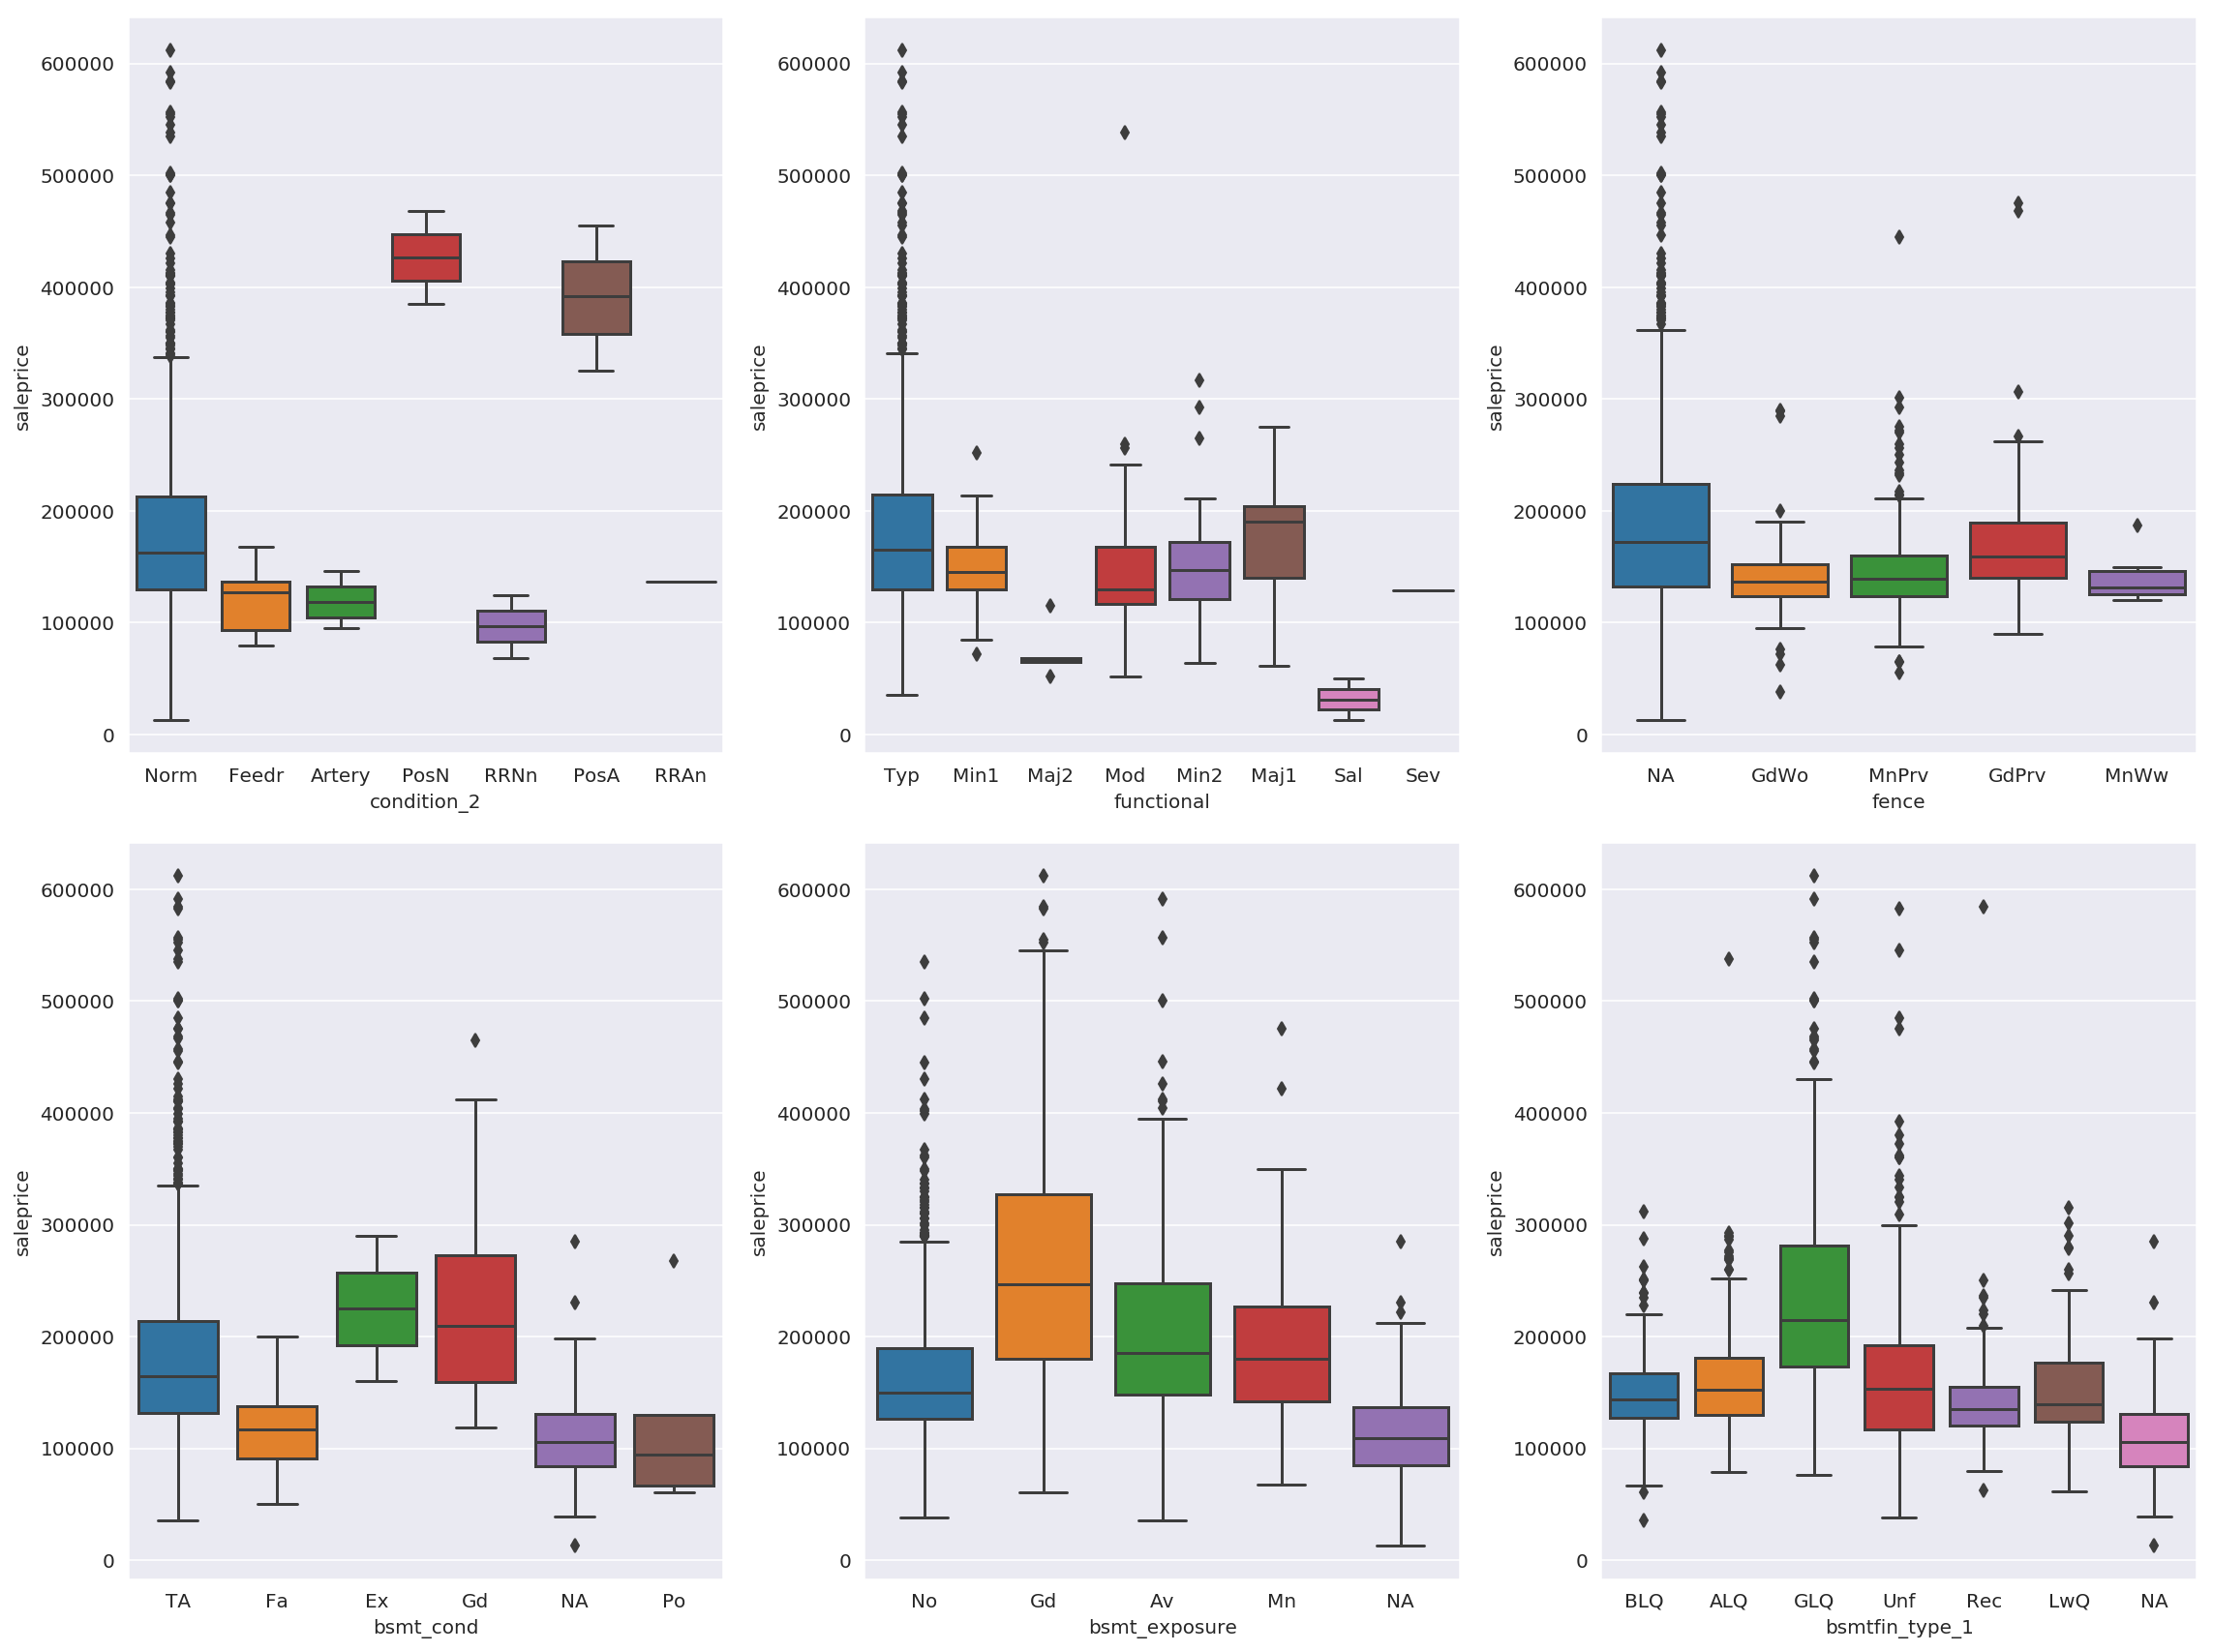

In [39]:
fig, ax = plt.subplots(figsize =(16,12), nrows = 2, ncols = 3)

sns.boxplot(x = 'condition_2', y = 'saleprice', data = ames_train, ax = ax[0][0])
sns.boxplot(x = 'functional', y = 'saleprice', data = ames_train, ax = ax[0][1])
sns.boxplot(x = 'fence', y = 'saleprice', data = ames_train, ax = ax[0][2])
sns.boxplot(x = 'bsmt_cond', y = 'saleprice', data = ames_train, ax = ax[1][0])
sns.boxplot(x = 'bsmt_exposure', y = 'saleprice', data = ames_train, ax = ax[1][1])
sns.boxplot(x = 'bsmtfin_type_1', y = 'saleprice', data = ames_train, ax = ax[1][2])

plt.tight_layout();

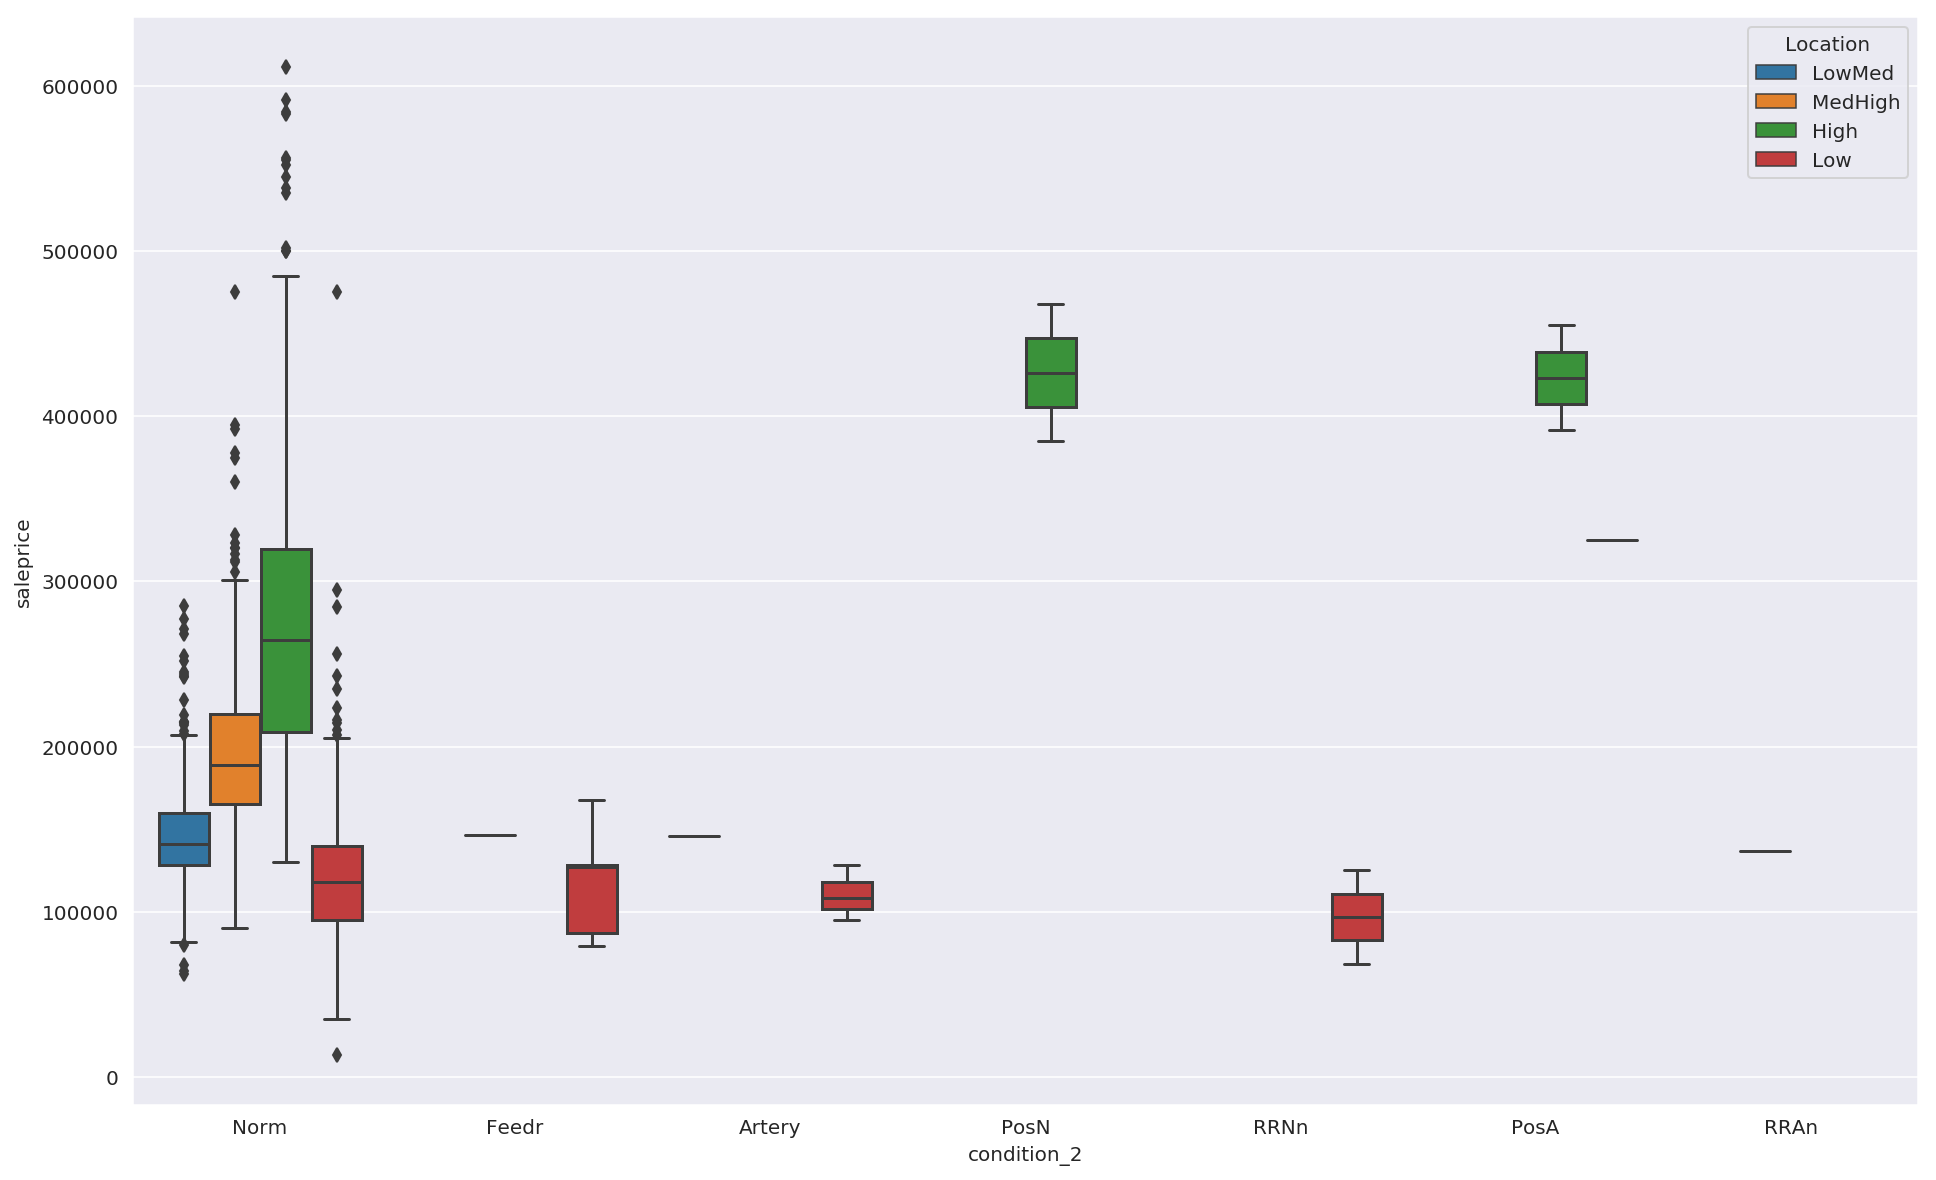

In [41]:
fig, ax = plt.subplots(figsize = (16,10))
sns.boxplot(x = 'condition_2', y = 'saleprice',hue = 'Location', data = ames_train, ax = ax)

# DUMMY VARIABLE CANDIDATES

## Observations from the boxplots above

1. House style doesn't seem to be that useful, BUT 2.5 Fin does seem to a useful predictor.
2. Number of full baths is a useful predictor.
3. As expected, total rooms above grade is a good predictor of salesprice.
4. Sale type might be useful.
5. Central air appears to be a good predictor, although the variance is high.
6. Electrical appears useful
7. Basement quality - specifically having a value of Ex, seems to be a useful predictor.
8. Neighborhood might be useful dummy variable, but I need to look at it more closely. (NOTE ABOVE: I decided to account for this by creating the 'LOCATION' category, which I will create dummy variables for).
9. MS ZONING could be a useful group of dummy variables.
10. Garage cars appears to be a strong predictor.
11. Exter quality appears like a useful predictor.
12. Condition 2, with values of PosN and PosA appears to be a great categorical variable, which I definitely want to include in my model. Being near, or adjacent to a positive off-site feature seems to be an excellent predictor of house price quality. I need to create a dummy variable to include PosN and PosA.
13. Funtional could be useful. Mostly only 'Sal', so I probably want to create a dummy for inclusion in that group.